这个notebook是利用bulk-amp-data-processing.ipynb处理后的数据，进一步探索和作图。  
to do：  
- [x] 加一个开关，可以方便设置是不是要正则化等；
- [x] 更改sio2的筛选限制。既然用深度作图，可以考虑去掉硅含量的限制条件;
- [ ] uncert values of depths and elements
- [x] add REE vs depth fig
- [ ] 钙碱系数、里特曼指数、碱度 vs depth
- [ ] 微量元素标准化（MORB）后 vs depth

In [1]:
thick_normalization = False
thickness_formula = "CaO"  # Sr_Y
dpmin = 0  # depth min
dpmax = 40
chondrite_normalized = "geometric"  # 'arithmetic'
exclude_outliers = "global"  # or 'sectional'
if thick_normalization:
    dpmin = 0  # depth min
    dpmax = 1  # depth max

In [2]:
import math
import os
import random
import re
import shutil

import imageio
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import numpy as np
import pandas as pd
import scipy
from scipy.interpolate import interp1d
import seaborn as sns
from icecream import ic
from matplotlib.patches import Rectangle
from scipy import stats

from julia.api import Julia
jl = Julia(compiled_modules=False)

from julia import Base
from julia.StatGeochem import histcounts
from julia.StatGeochem import draw_from_distribution

import multiprocessing


%matplotlib inline

In [3]:
# vol_plu_bulk = pd.read_csv('vol_plu_dp.csv')
# vol_plu_bulk = pd.read_csv('vol_plu_dp_replaced.csv')
# vol_plu_bulk = pd.read_csv('vol_plu_dp_R21.csv')
vol_plu_bulk = pd.read_csv("vol_plu_comprehensive.csv")

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
vol_plu_bulk.count()

UNIQUE_ID           24198
LATITUDE MIN        23320
LONGITUDE MIN       23320
MAX. AGE (YRS.)      2356
TECTONIC SETTING    23320
                    ...  
mK2O2               24198
mAl2O3              24198
KdFeMg              24198
DEPTH               23884
T                   24198
Length: 79, dtype: int64

In [5]:
manual_vp = pd.read_csv("vol_plu_comprehensive_manual_max.csv")
manual_vp = manual_vp.rename(
    columns={
        "LATITUDE": "LATITUDE MIN",
        "LONGITUDE": "LONGITUDE MIN",
        "AGE(MA)": "MAX. AGE (YRS.)",
    }
)
vol_plu_bulk = vol_plu_bulk.append(manual_vp, ignore_index=True)
vol_plu_bulk.count()

UNIQUE_ID           31462
LATITUDE MIN        30583
LONGITUDE MIN       30583
MAX. AGE (YRS.)      8450
TECTONIC SETTING    30584
                    ...  
mK2O2               31462
mAl2O3              31462
KdFeMg              31462
DEPTH               31144
T                   31462
Length: 79, dtype: int64

In [6]:
vol_plu_bulk.to_csv("vol_plu_all.csv", index=False, header=True)

(35.0, 81.0)

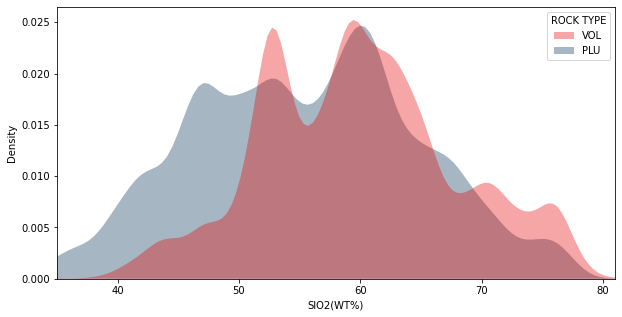

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.kdeplot(
    data=vol_plu_bulk.loc[vol_plu_bulk["SIO2(WT%)"].notna()],
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=["#E60000", "#003153"],
)
plt.xlim(35, 81)

In [8]:
## 删去没有深度的行
vol_plu_bulk.dropna(subset=["DEPTH"], inplace=True)

In [9]:
vol_plu_bulk[vol_plu_bulk["SIO2(WT%)"].notna()].groupby("ROCK TYPE").count()

UNIQUE_ID  LATITUDE MIN  LONGITUDE MIN  MAX. AGE (YRS.)  \
ROCK TYPE                                                            
PLU            16203         16185          16185             4835   
VOL            13590         13566          13566             3525   

           TECTONIC SETTING  SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  FEOT(WT%)  \
ROCK TYPE                                                                  
PLU                   16186      16203      16182       16203      10959   
VOL                   13566      13590      12734       12734      11192   

           MGO(WT%)  ...  mFeO2   mMgO  mCaO1  mCaO2  mK2O1  mK2O2  mAl2O3  \
ROCK TYPE            ...                                                     
PLU           16203  ...  16203  16203  16203  16203  16203  16203   16203   
VOL           12732  ...  13590  13590  13590  13590  13590  13590   13590   

           KdFeMg  DEPTH      T  
ROCK TYPE                        
PLU         16203  16203  16203  
VOL         13590  13590  13590  

[2 rows x 78 columns]

## 计算微量元素比值

In [10]:
C1 = {
    "LA(PPM)": 0.237,
    "YB(PPM)": 0.170,
    "SM(PPM)": 0.153,
    "EU(PPM)": 0.058,
    "GD(PPM)": 0.2055,
}  # Sun and McDonough, 1989

In [11]:
if chondrite_normalized == "geometric":
    vol_plu_bulk["Eu/Eu*"] = (vol_plu_bulk["EU(PPM)"] / C1["EU(PPM)"]) / np.sqrt(
        (vol_plu_bulk["SM(PPM)"] / C1["SM(PPM)"])
        * (vol_plu_bulk["GD(PPM)"] / C1["GD(PPM)"])
    )
elif chondrite_normalized == "arithmetic":
    vol_plu_bulk["Eu/Eu*"] = (
        2
        * (vol_plu_bulk["EU(PPM)"] / C1["EU(PPM)"])
        / (
            (vol_plu_bulk["SM(PPM)"] / C1["SM(PPM)"])
            + (vol_plu_bulk["GD(PPM)"] / C1["GD(PPM)"])
        )
    )

In [12]:
vol_plu_bulk["(La/Yb)N"] = (vol_plu_bulk["LA(PPM)"] / C1["LA(PPM)"]) / (
    vol_plu_bulk["YB(PPM)"] / C1["YB(PPM)"]
)

In [13]:
## 岩浆演化分异指标
vol_plu_bulk["Sr/Y"] = vol_plu_bulk["SR(PPM)"] / vol_plu_bulk["Y(PPM)"]
vol_plu_bulk["Rb/Sr"] = vol_plu_bulk["RB(PPM)"] / vol_plu_bulk["SR(PPM)"]
vol_plu_bulk["Ba/Rb"] = vol_plu_bulk["BA(PPM)"] / vol_plu_bulk["RB(PPM)"]
vol_plu_bulk["Ba/Rb"] = vol_plu_bulk["BA(PPM)"] / vol_plu_bulk["RB(PPM)"]
vol_plu_bulk["Ba/Sr"] = vol_plu_bulk["BA(PPM)"] / vol_plu_bulk["SR(PPM)"]
vol_plu_bulk["Ni/Co"] = vol_plu_bulk["NI(PPM)"] / vol_plu_bulk["CO(PPM)"]
vol_plu_bulk["Nb/Ta"] = vol_plu_bulk["NB(PPM)"] / vol_plu_bulk["TA(PPM)"]
vol_plu_bulk["La/Yb"] = vol_plu_bulk["LA(PPM)"] / vol_plu_bulk["YB(PPM)"]
vol_plu_bulk["ree"] = (
    vol_plu_bulk["LA(PPM)"]
    + vol_plu_bulk["CE(PPM)"]
    + vol_plu_bulk["PR(PPM)"]
    + vol_plu_bulk["ND(PPM)"]
    + vol_plu_bulk["SM(PPM)"]
    + vol_plu_bulk["EU(PPM)"]
    + vol_plu_bulk["GD(PPM)"]
    + vol_plu_bulk["TB(PPM)"]
    + vol_plu_bulk["DY(PPM)"]
    + vol_plu_bulk["HO(PPM)"]
    + vol_plu_bulk["ER(PPM)"]
    + vol_plu_bulk["TM(PPM)"]
    + vol_plu_bulk["YB(PPM)"]
    + vol_plu_bulk["LU(PPM)"]
)
# vol_plu_bulk['Ga/Sc'] = vol_plu_bulk['GA(PPM)'] /  vol_plu_bulk['SC(PPM)']

In [14]:
# ## 异常值删除
# elements = ['SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)', 'FEOT(WT%)', 'MGO(WT%)', 'CAO(WT%)', 'MNO(WT%)', 'NA2O(WT%)', 'K2O(WT%)', 'P2O5(WT%)', \
#             'CR(PPM)', 'CO(PPM)', 'NI(PPM)', 'LA(PPM)', 'CE(PPM)', 'PR(PPM)', 'ND(PPM)', 'SM(PPM)', 'EU(PPM)', 'GD(PPM)', 'TB(PPM)', \
#             'DY(PPM)', 'HO(PPM)', 'ER(PPM)', 'TM(PPM)', 'YB(PPM)', 'LU(PPM)', 'Y(PPM)', 'SC(PPM)', 'V(PPM)', 'ZR(PPM)', 'HF(PPM)',\
#             'RB(PPM)', 'SR(PPM)', 'BA(PPM)', 'NB(PPM)', 'TA(PPM)', 'U(PPM)', 'TH(PPM)']
# vol_plu_ele = vol_plu_bulk[elements]
# z_abs = np.abs(stats.zscore(vol_plu_ele, nan_p))
# z_abs < 3
# vol_plu_ele = vol_plu_ele.mask((vol_plu_ele - vol_plu_ele.mean()).abs() > 3 * vol_plu_ele.std())

# vol_plu_bulk[elements] = vol_plu_ele
# vol_plu_bulk

# 深度/地壳厚度正则化
利用Sr/Y或者La/YbN等指标计算地壳厚度，然后用前面计算的深度除这个厚度，来计算相对深度。  
要注意地壳厚度指标的适用范围，如Sr/Y或者La/YbN可能要求要是中性岩（55-68）。

In [15]:
print(vol_plu_bulk["SR(PPM)"].count())
print(vol_plu_bulk["Y(PPM)"].count())
print(vol_plu_bulk["LA(PPM)"].count())
print(vol_plu_bulk["YB(PPM)"].count())

28225
26084
25426
24189


Sr和Y的数据相对多，且公式较简单，先用Sr/Y做做看吧。

In [16]:
if thick_normalization:
    if thickness_formula == "Sr_Y":
        vol_plu_bulk["THICKNESS"] = (
            1.11 * (vol_plu_bulk["SR(PPM)"] / vol_plu_bulk["Y(PPM)"]) + 8.05
        )
        vol_plu_bulk["THICKNESS"] = vol_plu_bulk["THICKNESS"].replace(
            [np.inf, -np.inf], np.nan
        )
    elif thickness_formula == "CaO":  # 适用范围：SiO2 45-55
        # crust(km) = 185.77-15.64 * CaO(wt%) from Ganne et al., 2018
        vol_plu_bulk["THICKNESS"] = 185.77 - 15.64 * vol_plu_bulk["CAO(WT%)"]
    vol_plu_bulk = vol_plu_bulk[
        (vol_plu_bulk["THICKNESS"] <= 80) & (vol_plu_bulk["THICKNESS"] >= 0)
    ]
    vol_plu_bulk["DEPTH"] = vol_plu_bulk["DEPTH"] / vol_plu_bulk["THICKNESS"]
    vol_plu_bulk = vol_plu_bulk[vol_plu_bulk["DEPTH"] <= 1]
    sns.distplot(
        vol_plu_bulk["THICKNESS"].dropna(axis=0),
        kde=True,
        bins=int(100),
        color="darkblue",
    )

## 作图看看

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DEPTH', ylabel='Density'>

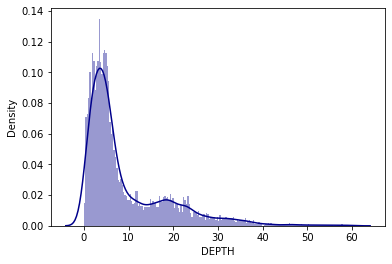

In [17]:
sns.distplot(
    vol_plu_bulk[(vol_plu_bulk["ROCK TYPE"] == "PLU") & (vol_plu_bulk["DEPTH"] <= 60)][
        "DEPTH"
    ],
    kde=True,
    bins=int(200),
    color="darkblue",
)

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DEPTH', ylabel='Density'>

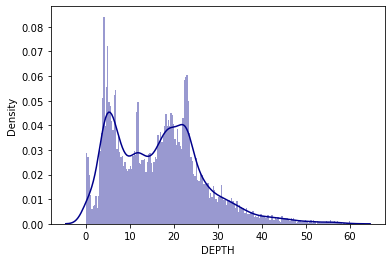

In [18]:
sns.distplot(
    vol_plu_bulk[(vol_plu_bulk["ROCK TYPE"] == "VOL") & (vol_plu_bulk["DEPTH"] <= 60)][
        "DEPTH"
    ],
    kde=True,
    bins=int(200),
    color="darkblue",
)

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DEPTH', ylabel='Density'>

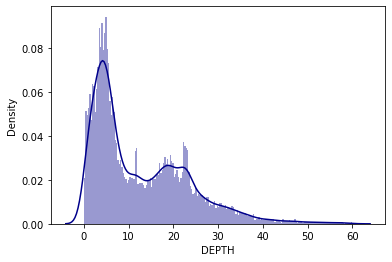

In [19]:
sns.distplot(
    vol_plu_bulk[vol_plu_bulk["DEPTH"] <= 60]["DEPTH"],
    kde=True,
    bins=int(200),
    color="darkblue",
)

(0.0, 3000.0)

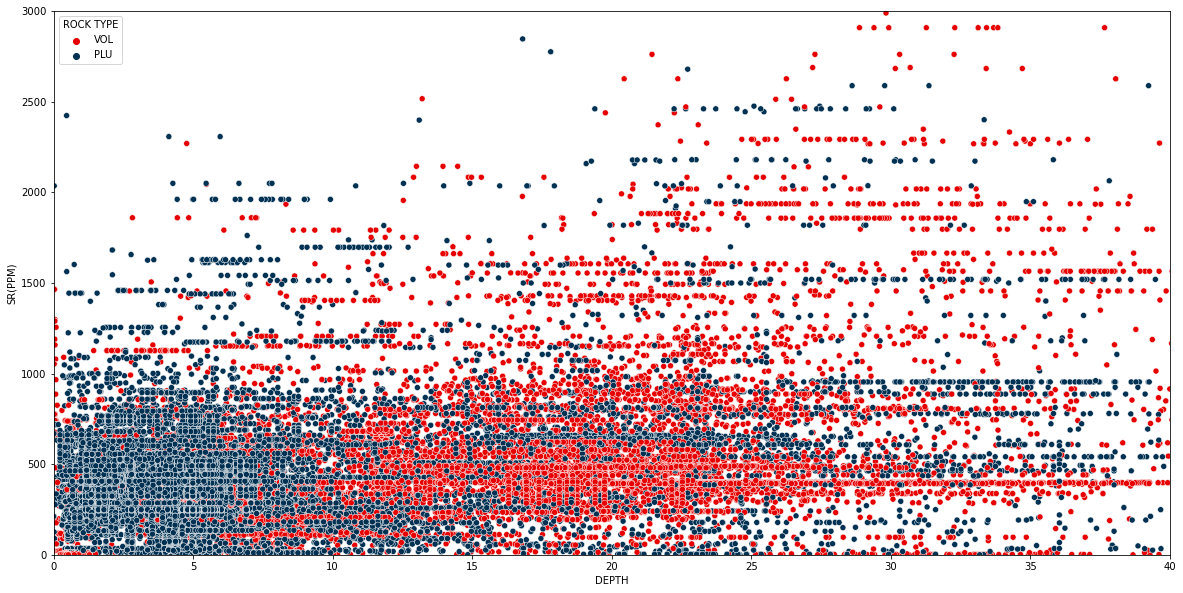

In [20]:
fig = plt.figure(figsize=(20, 10))
colors = ["#E60000", "#003153"]  # 故宫红(230,0,0)，中国蓝(0,49,83)
ax = sns.scatterplot(
    x="DEPTH", y="SR(PPM)", hue="ROCK TYPE", data=vol_plu_bulk, palette=colors
)
plt.xlim(dpmin, dpmax)
plt.ylim(0,3000)

(0.0, 2000.0)

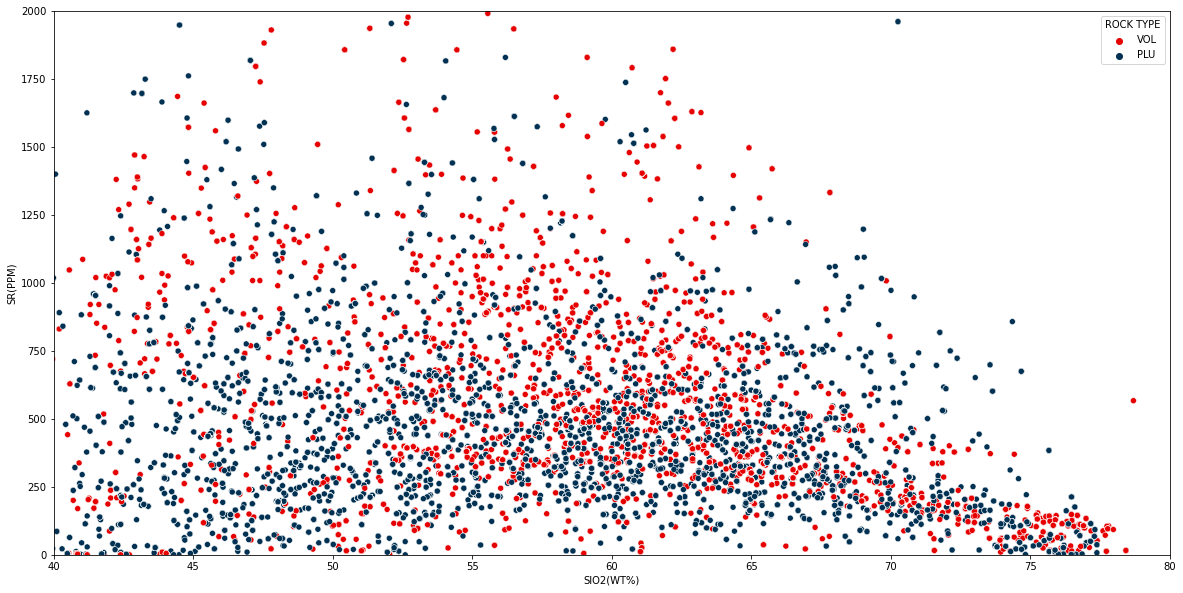

In [21]:
fig = plt.figure(figsize=(20, 10))
colors = ["#E60000", "#003153"]  # 故宫红(230,0,0)，中国蓝(0,49,83)
ax = sns.scatterplot(
    x="SIO2(WT%)", y="SR(PPM)", hue="ROCK TYPE", data=vol_plu_bulk, palette=colors
)
plt.xlim(40, 80)
plt.ylim(0, 2000)

In [22]:
if thick_normalization:
    bins = np.arange(0, 1.1, 0.1)
else:
    bins = np.arange(dpmin, dpmax, 2)
vol_plu_bulk["depth_group"] = pd.cut(vol_plu_bulk["DEPTH"], bins)
vol_df = vol_plu_bulk[vol_plu_bulk["ROCK TYPE"] == "VOL"]
plu_df = vol_plu_bulk[vol_plu_bulk["ROCK TYPE"] == "PLU"]

In [23]:
# def plot_line(element, df):
#     # 作图
#     plt.figure(dpi = 100)
#     ax = plt.subplot(111)
#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)

#     ax.get_xaxis().tick_bottom()
#     ax.get_yaxis().tick_left()


#     # 获得哈克图解的横坐标、平均值和标准差
#     for d in df:
#         sio2 = d.groupby("depth_group")['DEPTH'].mean().values
#         mean_PlyCount = d.groupby("depth_group")[element].mean().values
#         sem_PlyCount = d.groupby("depth_group")[element].std().values
#         if d is vol_df:
#             c = "red"
#             l = "VOL"
#         elif d is plu_df:
#             c = "blue"
#             l = "PLU"
#         plt.fill_between(sio2, mean_PlyCount - sem_PlyCount,
#                          mean_PlyCount + sem_PlyCount, color=c, alpha = 0.3)

#         plt.plot(sio2, mean_PlyCount, color=c, lw=2, label = l)

#     plt.legend()
# #     plt.title(element + "- SiO2", fontsize=22)
#     plt.xlabel("DEPTH", fontsize=16)
#     plt.ylabel(element, fontsize=16)
#     plt.show()
# #     plt.savefig('img/' + e + '_line' + '.svg')

#     # plt.savefig("line_plots_with_error_bars.svg", bbox_inches="tight")

In [24]:
# simitemsin=['LATITUDE MIN', 'LONGITUDE MIN', 'MAX. AGE (YRS.)', 'TECTONIC SETTING', \
#             'SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)', 'FEOT(WT%)', 'MGO(WT%)', 'CAO(WT%)', 'MNO(WT%)', 'NA2O(WT%)', 'K2O(WT%)', 'P2O5(WT%)', \
#             'CR(PPM)', 'CO(PPM)', 'NI(PPM)', 'LA(PPM)', 'CE(PPM)', 'PR(PPM)', 'ND(PPM)', 'SM(PPM)', 'EU(PPM)', 'GD(PPM)', 'TB(PPM)', \
#             'DY(PPM)', 'HO(PPM)', 'ER(PPM)', 'TM(PPM)', 'YB(PPM)', 'LU(PPM)', 'Y(PPM)', 'SC(PPM)', 'V(PPM)', 'ZR(PPM)', 'HF(PPM)',\
#             'RB(PPM)', 'SR(PPM)', 'BA(PPM)', 'NB(PPM)', 'TA(PPM)', 'U(PPM)', 'TH(PPM)', 'DEPTH'] #'TECTONIC SETTING'
# df = [vol_df, plu_df]

# for e in simitemsin[4:]:
#     plot_line(e, df)

In [25]:
# fig = plt.figure(figsize=(20, 10))
# sns.lineplot(x='DEPTH', y='SIO2(WT%)', data=vol_plu_bulk, )
# plt.xlim(dpmin,dpmax)

## Add crust composition to compare

In [26]:
# [upper, middle, lower, bulk] avg continental crust elements data from [0]Rudnick and Gao, 2003
cc_avg = {
    "SIO2(WT%)": [66.62, 63.5, 53.4, 60.6],
    "TIO2(WT%)": [0.64, 0.69, 0.82, 0.72],
    "AL2O3(WT%)": [15.4, 15.0, 16.9, 15.9],
    "FEOT(WT%)": [5.04, 6.02, 8.57, 6.7],
    "MGO(WT%)": [2.48, 3.59, 7.24, 4.7],
    "CAO(WT%)": [3.59, 5.25, 9.59, 6.4],
    "MNO(WT%)": [0.10, 0.10, 0.10, 0.1],
    "NA2O(WT%)": [3.27, 3.39, 2.65, 3.1],
    "K2O(WT%)": [2.80, 2.30, 0.61, 1.8],
    "P2O5(WT%)": [0.15, 0.15, 0.10, 0.1],
    "CR(PPM)": [92, 76, 215, 135],
    "CO(PPM)": [17.3, 22, 38, 26.6],
    "NI(PPM)": [47, 33.5, 88, 59],
    "LA(PPM)": [31, 24, 8, 20],
    "CE(PPM)": [63, 53, 20, 43],
    "PR(PPM)": [7.1, 5.8, 2.4, 4.9],
    "ND(PPM)": [27, 25, 11, 20],
    "SM(PPM)": [4.7, 4.6, 2.8, 3.9],
    "EU(PPM)": [1.0, 1.4, 1.1, 1.1],
    "GD(PPM)": [4.0, 4.0, 3.1, 3.7],
    "TB(PPM)": [0.7, 0.7, 0.48, 0.6],
    "DY(PPM)": [3.9, 3.8, 3.1, 3.6],
    "HO(PPM)": [0.83, 0.82, 0.68, 0.77],
    "ER(PPM)": [2.3, 2.3, 1.9, 2.1],
    "TM(PPM)": [0.30, 0.32, 0.24, 0.28],
    "YB(PPM)": [2.0, 2.2, 1.5, 1.9],
    "LU(PPM)": [0.31, 0.4, 0.25, 0.30],
    "Y(PPM)": [21, 20, 16, 19],
    "SC(PPM)": [14, 19, 31, 21.9],
    "V(PPM)": [97, 107, 196, 138],
    "ZR(PPM)": [193, 149, 68, 132],
    "HF(PPM)": [5.3, 4.4, 1.9, 3.7],
    "RB(PPM)": [84, 65, 11, 49],
    "SR(PPM)": [320, 282, 348, 320],
    "BA(PPM)": [624, 532, 259, 456],
    "NB(PPM)": [12, 10, 5, 8],
    "TA(PPM)": [0.88, 0.6, 0.6, 0.7],
    "U(PPM)": [2.7, 1.3, 0.2, 1.3],
    "TH(PPM)": [10.5, 6.5, 1.2, 5.6],
}
uc_bt = 12  # upper crust bottom depth
mc_bt = 24
lc_bt = 40

In [27]:
"""
Compositional estimates for average upper continental crust, from (Shaw et al., 1967,1976,1986), 
(Fahrig and Eade, 1968 & Eade and Fahrig, 1973), (Condie, 1993), (Gao et al.,1998), (Wedepohl, 1995),
(Taylor and McLennan, 1985, 1995), (Togashi et al.,2000), (Rudnick and Gao, 2003), (Kamber et al., 2005),
(Hu and Gao, 2008), (Gaschnig et al., 2016 & Chen et al., 2016)
"""
uc_avg = {
    "SIO2(WT%)": [
        66.8,
        66.2,
        67.0,
        67.97,
        66.8,
        65.89,
        67.53,
        66.62,
        68.5,
        np.nan,
        70.4,
    ],
    "TIO2(WT%)": [0.54, 0.54, 0.56, 0.67, 0.54, 0.50, 0.62, 0.64, 1.38, np.nan, 0.7],
    "AL2O3(WT%)": [
        15.05,
        16.11,
        15.14,
        14.17,
        15.05,
        15.17,
        14.67,
        15.4,
        17.6,
        np.nan,
        14.6,
    ],
    "FEOT(WT%)": [4.09, 4.41, 4.76, 5.33, 4.09, 4.49, 4.85, 5.04, 7.1, np.nan, 5.5],
    "MGO(WT%)": [2.30, 2.23, 2.45, 2.62, 2.30, 2.20, 2.53, 2.48, 1.6, np.nan, 2.0],
    "CAO(WT%)": [4.24, 3.44, 3.64, 3.44, 4.24, 4.19, 3.90, 3.59, 1.1, np.nan, 1.4],
    "MNO(WT%)": [0.07, 0.08, np.nan, 0.10, 0.07, 0.07, 0.11, 0.10, 0.14, np.nan, 0.1],
    "NA2O(WT%)": [3.56, 3.95, 3.55, 2.86, 3.56, 3.89, 2.72, 3.27, 0.8, np.nan, 1.6],
    "K2O(WT%)": [3.19, 2.91, 2.76, 2.68, 3.19, 3.39, 2.42, 2.80, 1.6, np.nan, 3.6],
    "P2O5(WT%)": [0.15, 0.16, 0.12, 0.16, 0.15, 0.20, 0.12, 0.15, 0.18, np.nan, 0.2],
    "CR(PPM)": [
        np.nan,
        76,
        112,
        80,
        np.nan,
        85,
        84,
        92,
        65,
        73,
        53,
    ],  # replace Shaw's 35 to NaN because of too low
    "CO(PPM)": [12, np.nan, 18, 17, 12, 17, 15, 17.3, 22.4, 15, 11.8],
    "NI(PPM)": [19, 19, 60, 38, 19, 44, 38, 47, 31.6, 34, 26.3],
    "LA(PPM)": [
        32.3,
        np.nan,
        28.4,
        34.8,
        32.3,
        30,
        21.7,
        31,
        32.5,
        np.nan,
        37,
    ],  # replace Eade and Fahrig, 1973's value to NaN because of analytical issue
    "CE(PPM)": [65.6, np.nan, 57.5, 66.4, 65.7, 64, 46.4, 63, 71.1, np.nan, 73],
    "PR(PPM)": [np.nan, np.nan, np.nan, np.nan, 6.3, 7.1, 5.54, 7.1, 8.5, np.nan, 8.54],
    "ND(PPM)": [25.9, np.nan, 25.6, 30.4, np.nan, 26, 20.8, 27, 32.9, np.nan, 33.3],
    "SM(PPM)": [4.61, np.nan, 4.59, 5.09, 4.7, 4.5, 4.28, 4.7, 6.88, np.nan, 6.84],
    "EU(PPM)": [0.937, np.nan, 1.05, 1.21, 0.95, 0.88, 1.07, 1.0, 1.57, np.nan, 1.37],
    "GD(PPM)": [np.nan, np.nan, 4.21, np.nan, 2.8, 3.8, 3.65, 4.0, 6.36, np.nan, 6.05],
    "TB(PPM)": [0.481, np.nan, 0.66, 0.82, 0.5, 0.64, 0.70, 0.7, 0.99, np.nan, 0.98],
    "DY(PPM)": [2.9, np.nan, np.nan, np.nan, 2.9, 3.5, 3.94, 3.9, 5.89, np.nan, 5.57],
    "HO(PPM)": [
        0.62,
        np.nan,
        np.nan,
        np.nan,
        0.62,
        0.8,
        0.72,
        0.83,
        1.22,
        np.nan,
        1.13,
    ],
    "ER(PPM)": [
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        2.3,
        2.39,
        2.3,
        3.37,
        2.3,
        3.27,
    ],
    "TM(PPM)": [
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        0.33,
        0.39,
        0.30,
        0.51,
        0.37,
        0.51,
    ],
    "YB(PPM)": [1.47, np.nan, 1.91, 2.26, 1.5, 2.2, 2.57, 2.0, 3.25, 2.34, 3.07],
    "LU(PPM)": [0.233, np.nan, 0.32, 0.35, 0.27, 0.32, 0.4, 0.31, 0.49, 0.36, 0.48],
    "Y(PPM)": [21, 21, 24, 17.4, 21, 22, 26, 21, 32, np.nan, 33.2],
    "SC(PPM)": [
        np.nan,
        12,
        13.4,
        15,
        np.nan,
        13.6,
        16,
        14,
        16.5,
        14,
        12.1,
    ],  # replace Shaw's 7 to NaN because of too low
    "V(PPM)": [53, 59, 86, 98, 53, 107, 110, 97, 120, 106, 74],
    "ZR(PPM)": [237, 190, 160, 188, 237, 190, 135, 193, 199, np.nan, 220],
    "HF(PPM)": [5.8, np.nan, 4.3, 5.12, 5.8, 5.8, 4.1, 5.3, 5.3, np.nan, 6.50],
    "RB(PPM)": [110, 85, 83, 82, 110, 112, 85, 84, 80, 94, 110],
    "SR(PPM)": [316, 380, 289, 266, 316, 350, 225, 320, 142, np.nan, 91.5],
    "BA(PPM)": [1070, 730, 633, 678, 668, 550, 458, 624, 396, np.nan, 731],
    "NB(PPM)": [
        np.nan,
        np.nan,
        9.8,
        12,
        26,
        12,
        9,
        12,
        15,
        11.6,
        12.7,
    ],  # replace Shaw's value to NaN because of analytical issue
    "TA(PPM)": [
        np.nan,
        np.nan,
        0.79,
        0.74,
        1.5,
        1.0,
        0.72,
        0.88,
        1.12,
        0.92,
        0.94,
    ],  # replace Shaw's value to NaN because of analytical issue
    "U(PPM)": [2.45, 1.5, 2.2, 1.55, 2.5, 2.8, 2.32, 2.7, 3.27, 2.6, 2.66],
    "TH(PPM)": [10.3, 10.8, 8.6, 8.95, 10.3, 10.7, 8.3, 10.5, 11.1, np.nan, 11.3],
}

In [28]:
"""
Compositional estimates for average middle continental crust, from (Weaver an Tarney, 1984),
(Shaw et al., 1994), (Rudnick and Fountain, 1995), (Gao et al., 1998), (Rudnick and Gao, 2003)
"""
mc_avg = {
    "SIO2(WT%)": [68.1, 69.4, 62.4, 64.6, 63.5],
    "TIO2(WT%)": [0.31, 0.33, 0.72, 0.67, 0.69],
    "AL2O3(WT%)": [16.33, 16.21, 15.96, 14.08, 15.0],
    "FEOT(WT%)": [3.27, 2.72, 6.59, 5.45, 6.02],
    "MGO(WT%)": [1.43, 1.27, 3.50, 3.67, 3.59],
    "CAO(WT%)": [3.27, 2.96, 5.25, 5.24, 5.25],
    "MNO(WT%)": [0.04, 0.03, 0.10, 0.11, 0.10],
    "NA2O(WT%)": [5.00, 3.55, 3.30, 3.48, 3.39],
    "K2O(WT%)": [2.14, 3.36, 2.07, 2.52, 2.30],
    "P2O5(WT%)": [0.14, 0.15, 0.10, 0.19, 0.15],
    "CR(PPM)": [32, 43, 83, 69, 76],
    "CO(PPM)": [np.nan, 30, 25, 18, 22],
    "NI(PPM)": [20, 18, 33, 34, 33.5],
    "LA(PPM)": [36, 22.9, 17, 30.8, 24],
    "CE(PPM)": [69, 42.1, 45, 60.3, 53],
    "PR(PPM)": [np.nan, np.nan, 5.8, np.nan, 5.8],
    "ND(PPM)": [30, 18.3, 24, 26.2, 25],
    "SM(PPM)": [4.4, 2.8, 4.4, 4.74, 4.6],
    "EU(PPM)": [1.09, 0.78, 1.5, 1.20, 1.4],
    "GD(PPM)": [np.nan, 2.11, 4.0, np.nan, 4.0],
    "TB(PPM)": [0.41, 0.28, 0.58, 0.76, 0.7],
    "DY(PPM)": [np.nan, 1.54, 3.8, np.nan, 3.8],
    "HO(PPM)": [np.nan, np.nan, 0.82, np.nan, 0.82],
    "ER(PPM)": [np.nan, np.nan, 2.3, np.nan, 2.3],
    "TM(PPM)": [0.14, np.nan, np.nan, np.nan, 0.32],
    "YB(PPM)": [0.76, 0.63, 2.3, 2.17, 2.2],
    "LU(PPM)": [0.1, 0.12, 0.41, 0.32, 0.4],
    "Y(PPM)": [9, 16, 22, 17.0, 20],
    "SC(PPM)": [np.nan, 5.4, 22, 15, 19],
    "V(PPM)": [np.nan, 46, 118, 95, 107],
    "ZR(PPM)": [193, 129, 125, 173, 149],
    "HF(PPM)": [3.8, 3.3, 4.0, 4.79, 4.4],
    "RB(PPM)": [74, 92, 62, 67, 65],
    "SR(PPM)": [580, 465, 281, 283, 282],
    "BA(PPM)": [713, 1376, 402, 661, 532],
    "NB(PPM)": [6, 8.7, 8, 11, 10],
    "TA(PPM)": [np.nan, 1.8, 0.6, 0.55, 0.6],
    "U(PPM)": [2.2, 0.9, 1.6, 1.02, 1.3],
    "TH(PPM)": [8.4, 6.4, 6.1, 6.84, 6.5],
}

In [29]:
"""
Compositional estimates for average lower continental crust, from (Weaver and Tarney, 1984),
(Rudnick and Fountain, 1995), (Wedepohl, 1995), (Gao et al., 1998), (Taylor and McLennan, 1985, 1995), 
(Rudnick and Gao, 2003), ~~(Hacker et al., 2011), (Hacker et al., 2015, felsic), (Hacker et al., 2015, mafic)~~
- removed Hacker 2011 & 2015 for lumping middle and lower crust together
"""
lc_avg = {
    "SIO2(WT%)": [62.9, 53.4, 59.0, 59.8, 54.3, 53.4],
    "TIO2(WT%)": [0.5, 0.82, 0.85, 1.04, 0.97, 0.82],
    "AL2O3(WT%)": [16.0, 16.9, 15.8, 14.0, 16.1, 16.9],
    "FEOT(WT%)": [5.4, 8.57, 7.47, 9.30, 10.6, 8.57],
    "MGO(WT%)": [3.5, 7.24, 5.32, 4.46, 6.28, 7.24],
    "CAO(WT%)": [5.8, 9.59, 6.92, 6.20, 8.48, 9.59],
    "MNO(WT%)": [0.08, 0.10, 0.12, 0.16, 0.22, 0.10],
    "NA2O(WT%)": [4.5, 2.65, 2.91, 3.00, 2.79, 2.65],
    "K2O(WT%)": [1.0, 0.61, 1.61, 1.75, 0.64, 0.61],
    "P2O5(WT%)": [0.19, 0.10, np.nan, 0.21, np.nan, 0.10],
    "CR(PPM)": [88, 215, 228, 123, 219, 215],
    "CO(PPM)": [np.nan, 38, 38, 36, 33, 38],
    "NI(PPM)": [58, 88, 99, 64, 156, 88],
    "LA(PPM)": [22, 8, 27, 29, 11, 8],
    "CE(PPM)": [44, 20, 53, 53, 23, 20],
    "PR(PPM)": [np.nan, np.nan, 7.4, np.nan, 2.8, 2.4],
    "ND(PPM)": [19, 11, 28, 25, 13, 11],
    "SM(PPM)": [3.3, 2.8, 6.0, 4.65, 3.17, 2.8],
    "EU(PPM)": [1.18, 1.1, 1.6, 1.39, 1.17, 1.1],
    "GD(PPM)": [np.nan, 3.1, 5.4, np.nan, 3.13, 3.1],
    "TB(PPM)": [0.43, 0.48, 0.81, 0.86, 0.59, 0.48],
    "DY(PPM)": [np.nan, 3.1, 4.7, np.nan, 3.6, 3.1],
    "HO(PPM)": [np.nan, 0.68, 0.99, np.nan, 0.77, 0.68],
    "ER(PPM)": [np.nan, 1.9, np.nan, np.nan, 2.2, 1.9],
    "TM(PPM)": [0.19, np.nan, np.nan, np.nan, 0.32, 0.24],
    "YB(PPM)": [1.2, 1.5, 2.5, 2.29, 2.2, 1.5],
    "LU(PPM)": [0.18, 0.25, 0.43, 0.38, 0.29, 0.25],
    "Y(PPM)": [7, 16, 27, 18, 19, 16],
    "SC(PPM)": [np.nan, 31, 25, 26, 35, 31],
    "V(PPM)": [np.nan, 196, 149, 185, 271, 196],
    "ZR(PPM)": [202, 68, 165, 162, 70, 68],
    "HF(PPM)": [3.6, 1.9, 4.0, 4.2, 2.1, 1.9],
    "RB(PPM)": [11, 11, 41, 56, 12, 11],
    "SR(PPM)": [569, 348, 352, 308, 230, 348],
    "BA(PPM)": [757, 259, 568, 509, 150, 259],
    "NB(PPM)": [5, 5.0, 11, 10, 6.7, 5],
    "TA(PPM)": [np.nan, 0.6, 0.8, 0.6, 0.7, 0.6],
    "U(PPM)": [0.05, 0.2, 0.93, 0.86, 0.53, 0.2],
    "TH(PPM)": [0.42, 1.2, 6.6, 5.23, 2.0, 1.2],
}

In [30]:
"""
Compositional estimates for average bulk continental crust, from (Taylor, 1964), (Weaver and Tarney, 1984),
(Shaw et al., 1986), (Christensen and Mooney, 1995), (Rudnick and Fountain, 1995), (Wedepohl, 1995), (Gao et al., 1998), (Taylor and McLennan, 1985, 1995), 
(Rudnick and Gao, 2003, 2014), (Hacker et al., 2011), (Hacker et al., 2015, felsic), (Hacker et al., 2015, mafic)
"""
bc_avg = {
    "SIO2(WT%)": [
        60.4,
        63.9,
        64.5,
        62.4,
        60.1,
        62.8,
        64.2,
        57.1,
        60.6,
        65.2,
        56.0,
        65.4,
    ],
    "TIO2(WT%)": [1.0, 0.6, 0.7, 0.9, 0.7, 0.7, 0.8, 0.9, 0.72, 0.7, 1.1, 0.7],
    "AL2O3(WT%)": [
        15.6,
        16.3,
        15.1,
        14.9,
        16.1,
        15.4,
        14.1,
        15.9,
        15.9,
        15.0,
        16.7,
        15.7,
    ],
    "FEOT(WT%)": [7.3, 5.0, 5.7, 6.9, 6.7, 5.7, 6.8, 9.1, 6.7, 5.8, 8.7, 5.3],
    "MGO(WT%)": [3.9, 2.8, 3.2, 3.1, 4.5, 3.8, 3.5, 5.3, 4.7, 2.5, 5.2, 2.4],
    "CAO(WT%)": [5.8, 4.8, 4.8, 5.8, 6.5, 5.6, 4.9, 7.4, 6.4, 3.4, 7.1, 4.3],
    "MNO(WT%)": [0.12, 0.08, 0.09, 0.10, 0.11, 0.10, 0.12, 0.18, 0.10, 0.10, 0.17, 0.1],
    "NA2O(WT%)": [3.2, 4.2, 3.4, 3.6, 3.3, 3.3, 3.1, 3.1, 3.1, 3.0, 3.2, 3.7],
    "K2O(WT%)": [2.5, 2.1, 2.4, 2.1, 1.9, 2.7, 2.3, 1.3, 1.8, 1.9, 1.75, 2.21],
    "P2O5(WT%)": [
        0.24,
        0.19,
        0.14,
        0.20,
        0.20,
        np.nan,
        0.18,
        np.nan,
        0.1,
        0.1,
        0.2,
        0.2,
    ],
    "CR(PPM)": [100, 56, 90, np.nan, 119, 126, 92, 185, 135, 65, np.nan, np.nan],
    "CO(PPM)": [25, np.nan, 26, np.nan, 25, 24, 24, 29, 26.6, 21.3, np.nan, np.nan],
    "NI(PPM)": [75, 35, 54, np.nan, 51, 56, 46, 105, 59, 31, np.nan, np.nan],
    "LA(PPM)": [30, 28, np.nan, np.nan, 18, 30, 31.6, 16, 20, 23, 17, 23],
    "CE(PPM)": [60, 57, np.nan, np.nan, 42, 60, 60.0, 33, 43, 56, 36, 49],
    "PR(PPM)": [
        8.2,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        6.7,
        np.nan,
        3.9,
        4.9,
        8,
        4.5,
        5.5,
    ],
    "ND(PPM)": [28, 23, np.nan, np.nan, 20, 27, 27.4, 16, 20, 26, 19, 23],
    "SM(PPM)": [6, 4.1, np.nan, np.nan, 3.9, 5.3, 4.84, 3.5, 3.9, 5.1, 3.9, 4.1],
    "EU(PPM)": [1.2, 1.09, np.nan, np.nan, 1.2, 1.3, 1.27, 1.1, 1.1, 1.4, 1.1, 1.1],
    "GD(PPM)": [
        5.4,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        4.0,
        np.nan,
        3.3,
        3.7,
        4.4,
        3.8,
        3.6,
    ],
    "TB(PPM)": [0.9, 0.53, np.nan, np.nan, 0.56, 0.65, 0.82, 0.60, 0.6, 0.8, 0.6, 0.59],
    "DY(PPM)": [
        3,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        3.8,
        np.nan,
        3.7,
        3.6,
        3.5,
        3.9,
        3.0,
    ],
    "HO(PPM)": [
        1.2,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        0.80,
        np.nan,
        0.78,
        0.77,
        0.73,
        0.84,
        0.61,
    ],
    "ER(PPM)": [
        2.8,
        np.nan,
        np.nan,
        np.nan,
        np.nan,
        2.1,
        np.nan,
        2.2,
        2.1,
        2.1,
        2.3,
        1.7,
    ],
    "TM(PPM)": [
        0.48,
        0.24,
        np.nan,
        np.nan,
        np.nan,
        0.30,
        np.nan,
        0.32,
        0.28,
        np.nan,
        np.nan,
        np.nan,
    ],
    "YB(PPM)": [3.0, 1.5, np.nan, np.nan, 2.0, 2.0, 2.2, 2.2, 1.9, 2.3, 2.1, 1.6],
    "LU(PPM)": [
        0.50,
        0.23,
        np.nan,
        np.nan,
        0.33,
        0.35,
        0.35,
        0.30,
        0.30,
        0.4,
        0.33,
        0.24,
    ],
    "Y(PPM)": [33, 14, 26, np.nan, 20, 24, 17.5, 20, 19, 24, 22, 18],
    "SC(PPM)": [22, np.nan, 13, np.nan, 22, 16, 19, 30, 21.9, 19, np.nan, np.nan],
    "V(PPM)": [135, np.nan, 96, np.nan, 131, 98, 128, 230, 138, 89, np.nan, np.nan],
    "ZR(PPM)": [165, 210, 203, np.nan, 123, 203, 175, 100, 132, 169, 120, 148],
    "HF(PPM)": [3, 4.7, 5, np.nan, 3.7, 4.9, 4.71, 3.0, 3.7, 4.0, 3.1, 4],
    "RB(PPM)": [90, 61, 76, np.nan, 58, 78, 69, 37, 49, 55, 39, 41],
    "SR(PPM)": [375, 503, 317, np.nan, 325, 333, 285, 260, 320, 246, 276, 385],
    "BA(PPM)": [425, 707, 764, np.nan, 390, 584, 614, 250, 456, 473, 329, 534],
    "NB(PPM)": [20, 13, 20, np.nan, 8, 19, 11, 8, 8, 11, 7.4, 8.1],
    "TA(PPM)": [2, np.nan, 4, np.nan, 0.7, 1.1, 0.6, 0.8, 0.7, 0.6, 0.54, 0.52],
    "U(PPM)": [2.7, 1.3, 1.8, np.nan, 1.4, 1.7, 1.2, 1.1, 1.3, 1.4, 1.13, 1.09],
    "TH(PPM)": [9.6, 5.7, 9, np.nan, 5.6, 8.5, 7.1, 4.2, 5.6, 7.3, 4.29, 4.20],
}

In [31]:
# Primitive mantle, Sun_McDonough_GSL_1989
pm = {
    "CS(PPM)": 0.032,
    "TL(PPM)": 0.005,
    "RB(PPM)": 0.635,
    "BA(PPM)": 6.989,
    "W(PPM)": 0.020,
    "TH(PPM)": 0.085,
    "U(PPM)": 0.021,
    "NB(PPM)": 0.713,
    "TA(PPM)": 0.041,
    "K(PPM)": 250,
    "LA(PPM)": 0.687,
    "CE(PPM)": 1.775,
    "PB(PPM)": 0.185,
    "PR(PPM)": 0.276,
    "MO(PPM)": 0.063,
    "SR(PPM)": 21.1,
    "P(PPM)": 95,
    "ND(PPM)": 1.354,
    "F(PPM)": 26,
    "SM(PPM)": 0.444,
    "ZR(PPM)": 11.2,
    "HF(PPM)": 0.309,
    "EU(PPM)": 0.168,
    "SN(PPM)": 0.170,
    "SB(PPM)": 0.005,
    "TI(PPM)": 1300,
    "GD(PPM)": 0.596,
    "TB(PPM)": 0.108,
    "DY(PPM)": 0.737,
    "LI(PPM)": 1.60,
    "Y(PPM)": 4.55,
    "HO(PPM)": 0.164,
    "ER(PPM)": 0.480,
    "TM(PPM)": 0.074,
    "YB(PPM)": 0.493,
    "LU(PPM)": 0.074,
}

In [32]:
# Elements error: 2 standard error

elerr = {
    "SIO2(WT%)": 0.01,
    "TIO2(WT%)": 0.01,
    "AL2O3(WT%)": 0.01,
    "FEOT(WT%)": 0.01,
    "MGO(WT%)": 0.01,
    "CAO(WT%)": 0.01,
    "MNO(WT%)": 0.02,
    "NA2O(WT%)": 0.01,
    "K2O(WT%)": 0.01,
    "P2O5(WT%)": 0.02,
    "CR(PPM)": 0.01,
    "CO(PPM)": 0.01,
    "NI(PPM)": 0.01,
    "LA(PPM)": 0.01,
    "CE(PPM)": 0.01,
    "PR(PPM)": 0.01,
    "ND(PPM)": 0.01,
    "SM(PPM)": 0.01,
    "EU(PPM)": 0.01,
    "GD(PPM)": 0.01,
    "TB(PPM)": 0.02,
    "DY(PPM)": 0.01,
    "HO(PPM)": 0.01,
    "ER(PPM)": 0.01,
    "TM(PPM)": 0.01,
    "YB(PPM)": 0.01,
    "LU(PPM)": 0.01,
    "Y(PPM)": 0.01,
    "SC(PPM)": 0.02,
    "V(PPM)": 0.01,
    "ZR(PPM)": 0.02,
    "HF(PPM)": 0.02,
    "RB(PPM)": 0.02,
    "SR(PPM)": 0.02,
    "BA(PPM)": 0.02,
    "NB(PPM)": 0.02,
    "TA(PPM)": 0.02,
    "U(PPM)": 0.02,
    "TH(PPM)": 0.02,
    "T": 0.1,
    "DEPTH": 0.23,
}

# 在某个构造分类下看火山岩和侵入岩在不同深度下的区别

## 反加权重采样和蒙特卡洛

In [33]:
vol_plu_bulk.groupby("TECTONIC SETTING").count()

UNIQUE_ID  LATITUDE MIN  \
TECTONIC SETTING                                                       
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)        911           911   
COMPLEX VOLCANIC SETTINGS                           40            40   
CONTINENTAL FLOOD BASALT                           519           519   
CONVERGENT MARGIN                                17857         17856   
INTRAPLATE VOLCANICS                              8493          8493   
OCEAN ISLAND                                      1611          1611   
OCEANIC PLATEAU                                     28            28   
RIFT VOLCANICS                                     535           535   
SEAMOUNT                                           308           308   
SUBMARINE RIDGE                                      9             9   

                                             LONGITUDE MIN  MAX. AGE (YRS.)  \
TECTONIC SETTING                                                              
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)            911              110   
COMPLEX VOLCANIC SETTINGS                               40               14   
CONTINENTAL FLOOD BASALT                               519               36   
CONVERGENT MARGIN                                    17856             7777   
INTRAPLATE VOLCANICS                                  8493              336   
OCEAN ISLAND                                          1611               46   
OCEANIC PLATEAU                                         28                0   
RIFT VOLCANICS                                         535               99   
SEAMOUNT                                               308                0   
SUBMARINE RIDGE                                          9                0   

                                             ROCK TYPE  SIO2(WT%)  TIO2(WT%)  \
TECTONIC SETTING                                                               
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)        911        911        911   
COMPLEX VOLCANIC SETTINGS                           40         40         40   
CONTINENTAL FLOOD BASALT                           519        491        491   
CONVERGENT MARGIN                                17857      17465      16635   
INTRAPLATE VOLCANICS                              8493       8367       8345   
OCEAN ISLAND                                      1611       1611       1611   
OCEANIC PLATEAU                                     28         28         28   
RIFT VOLCANICS                                     535        531        531   
SEAMOUNT                                           308        308        308   
SUBMARINE RIDGE                                      9          0          0   

                                             AL2O3(WT%)  FEOT(WT%)  MGO(WT%)  \
TECTONIC SETTING                                                               
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)         911        869       911   
COMPLEX VOLCANIC SETTINGS                            40          6        40   
CONTINENTAL FLOOD BASALT                            491        414       491   
CONVERGENT MARGIN                                 16611      10789     16610   
INTRAPLATE VOLCANICS                               8365       7764      8364   
OCEAN ISLAND                                       1611       1493      1611   
OCEANIC PLATEAU                                      28         27        28   
RIFT VOLCANICS                                      531        475       531   
SEAMOUNT                                            308        299       308   
SUBMARINE RIDGE                                       0          0         0   

                                             ...  (La/Yb)N   Sr/Y  Rb/Sr  \
TECTONIC SETTING                             ...                           
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)  ...       882    864    864   
COMPLEX VOLCANIC SETTINGS                    ...        15     29     35   
CONTI

In [34]:
# sum_df = pd.read_csv('vol_plu_bulk_with_depth.csv')
sum_df = vol_plu_bulk
sum_df.loc[
    sum_df["TECTONIC SETTING"] == "convergent margin", "TECTONIC SETTING"
] = "CONVERGENT MARGIN"

In [35]:
# 选择构造背景
sum_df = sum_df[sum_df['TECTONIC SETTING'] == 'CONVERGENT MARGIN']
# sum_df = sum_df[sum_df['TECTONIC SETTING'] == 'INTRAPLATE VOLCANICS']

In [36]:
sum_df.groupby("ROCK TYPE").count()

UNIQUE_ID  LATITUDE MIN  LONGITUDE MIN  MAX. AGE (YRS.)  \
ROCK TYPE                                                            
PLU             8763          8762           8762             4651   
VOL             9094          9094           9094             3126   

           TECTONIC SETTING  SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  FEOT(WT%)  \
ROCK TYPE                                                                  
PLU                    8763       8514       8513        8514       3747   
VOL                    9094       8951       8122        8097       7042   

           MGO(WT%)  ...  (La/Yb)N  Sr/Y  Rb/Sr  Ba/Rb  Ba/Sr  Ni/Co  Nb/Ta  \
ROCK TYPE            ...                                                      
PLU            8514  ...      6504  7092   7566   7015   7474   4202   5447   
VOL            8096  ...      7000  7199   8179   7290   7308   3364   5285   

           La/Yb   ree  depth_group  
ROCK TYPE                            
PLU         6504  5521         8710  
VOL         7000  4373         8902  

[2 rows x 89 columns]

In [37]:
sum_df[sum_df["SIO2(WT%)"] <= 52].groupby("ROCK TYPE").count()

UNIQUE_ID  LATITUDE MIN  LONGITUDE MIN  MAX. AGE (YRS.)  \
ROCK TYPE                                                            
PLU             1717          1717           1717               22   
VOL              550           550            550               16   

           TECTONIC SETTING  SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  FEOT(WT%)  \
ROCK TYPE                                                                  
PLU                    1717       1717       1717        1717       1592   
VOL                     550        550        550         550        498   

           MGO(WT%)  ...  (La/Yb)N  Sr/Y  Rb/Sr  Ba/Rb  Ba/Sr  Ni/Co  Nb/Ta  \
ROCK TYPE            ...                                                      
PLU            1717  ...      1206  1234   1240   1234   1371   1186   1058   
VOL             550  ...       475   519    524    520    520    299    433   

           La/Yb   ree  depth_group  
ROCK TYPE                            
PLU         1206  1132         1682  
VOL          475   402          539  

[2 rows x 89 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


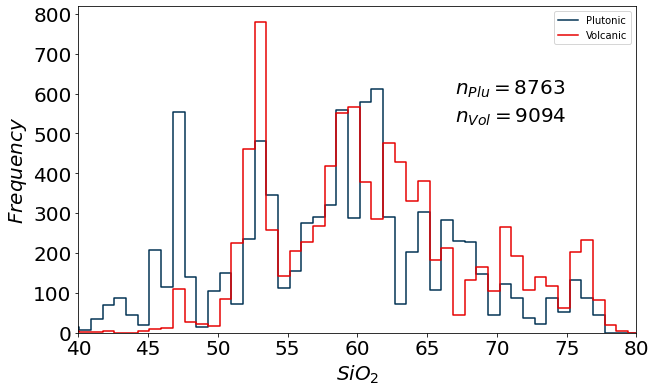

In [38]:
# sum_df_plot = sum_df.loc[sum_df["SIO2(WT%)"].notna()]
# sum_df_plot.iloc[:,6] = sum_df_plot.iloc[:,6] + 0.01 * sum_df_plot.iloc[:,6]* np.random.randn()
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.histplot(
    data=sum_df.loc[sum_df["SIO2(WT%)"].notna()],
#     data=sum_df_plot,
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=False,
    common_norm=True,
#     alpha=.5,
#     linewidth=0,
    element="step",
    palette=["#E60000", "#003153"],
)
plt.text(67, 600, r'$n_{Plu} = 8763$', fontsize=20)
plt.text(67, 530, r'$n_{Vol} = 9094$', fontsize=20)
plt.legend(labels = ["Plutonic", "Volcanic"])
plt.xlabel('$SiO_2$', fontsize=20)
plt.ylabel('$Frequency$', fontsize=20)
plt.xlim(40, 80)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('./figures/figures_geology/hist.eps', format='eps')

### 1. 准备

In [39]:
# Range of silica values to examine （Keller）
# SiO2min = 55 # 岩石学书上是45
# SiO2min = 68
SiO2min = 40  # 取中酸性岩
SiO2max = 80

In [40]:
# simitemsin=['LATITUDE MIN', 'LONGITUDE MIN','MIN. AGE (YRS.)', 'MAX. AGE (YRS.)', 'SIO2(WT%)','FEOT(WT%)','MGO(WT%)','NI(PPM)','CAO(WT%)','AL2O3(WT%)','NA2O(WT%)','K2O(WT%)','TIO2(WT%)',\
#             'ZR(PPM)','HF(PPM)','YB(PPM)','RB(PPM)','BA(PPM)','SR(PPM)','EU(PPM)']
simitemsin = [
    "LATITUDE MIN",
    "LONGITUDE MIN",
    "MAX. AGE (YRS.)",
    "ROCK TYPE",
    "SIO2(WT%)",
    "TIO2(WT%)",
    "AL2O3(WT%)",
    "FEOT(WT%)",
    "MGO(WT%)",
    "CAO(WT%)",
    "MNO(WT%)",
    "NA2O(WT%)",
    "K2O(WT%)",
    "P2O5(WT%)",
    "CR(PPM)",
    "CO(PPM)",
    "NI(PPM)",
    "LA(PPM)",
    "CE(PPM)",
    "PR(PPM)",
    "ND(PPM)",
    "SM(PPM)",
    "EU(PPM)",
    "GD(PPM)",
    "TB(PPM)",
    "DY(PPM)",
    "HO(PPM)",
    "ER(PPM)",
    "TM(PPM)",
    "YB(PPM)",
    "LU(PPM)",
    "Y(PPM)",
    "SC(PPM)",
    "V(PPM)",
    "ZR(PPM)",
    "HF(PPM)",
    "RB(PPM)",
    "SR(PPM)",
    "BA(PPM)",
    "NB(PPM)",
    "TA(PPM)",
    "U(PPM)",
    "TH(PPM)",
    "mSiO23",
    "Eu/Eu*",
    "(La/Yb)N",
    "La/Yb",
    "Sr/Y",
    "Rb/Sr",
    "Ba/Rb",
    "Ba/Sr",
    "Ni/Co",
    "Nb/Ta",
    "ree",
    "T",
    "DEPTH",
]  #'TECTONIC SETTING'
len(simitemsin)

56

In [41]:
# data = sum_df[(sum_df['SIO2(WT%)'] > SiO2min) & (sum_df['SIO2(WT%)'] < SiO2max)]
data = sum_df[~((sum_df["SIO2(WT%)"] < SiO2min) | (sum_df["SIO2(WT%)"] > SiO2max))]
data = data.dropna(subset=["LATITUDE MIN", "LONGITUDE MIN"])

data = data[simitemsin]
data.reset_index(inplace=True, drop=True)  # 一定要重置，不然下面会出错
print(data.shape)

(17765, 56)


In [42]:
data.describe()

LATITUDE MIN  LONGITUDE MIN     SIO2(WT%)     TIO2(WT%)    AL2O3(WT%)  \
count  17765.000000   17765.000000  17373.000000  16543.000000  16519.000000   
mean      18.156917      41.984151     59.968932      0.660727     16.493851   
std       31.431710     108.428873      7.764618      0.335138      2.318260   
min      -62.640000    -177.920000     40.010000      0.000000      0.644000   
25%       -9.170000     -67.700000     53.800000      0.460000     15.235000   
50%       30.830000      80.075500     59.546033      0.620000     16.570000   
75%       41.372200     130.850000     64.700000      0.780000     17.664185   
max      138.250000     243.780000     79.300000      6.510000     29.690000   

          FEOT(WT%)      MGO(WT%)      CAO(WT%)      MNO(WT%)     NA2O(WT%)  \
count  10710.000000  16518.000000  16519.000000  16370.000000  15929.000000   
mean       5.751757      3.955438      6.309281      0.117132      3.498239   
std        2.719164      4.110993      3.043097      0.055017      1.082386   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.600000      1.787890      4.040000      0.080000      3.070000   
50%        5.790000      3.230000      6.280000      0.110000      3.550000   
75%        7.432104      5.290000      8.220000      0.146609      4.120000   
max       18.880000    239.000000     21.510000      1.890000      9.130000   

       ...         La/Yb          Sr/Y         Rb/Sr         Ba/Rb  \
count  ...  1.343200e+04  14221.000000  15674.000000  1.423500e+04   
mean   ...           inf     37.213075      0.449996           inf   
std    ...           NaN     51.412475      7.847542           NaN   
min    ...  3.897059e-01      0.016667      0.000000  6.410256e-03   
25%    ...  5.461538e+00     15.714286      0.040673  7.892857e+00   
50%    ...  8.697917e+00     24.137707      0.088398  1.376971e+01   
75%    ...  1.605263e+01     36.714286      0.264865  2.043902e+01   
max    ...           inf    912.500000    553.658537           inf   

              Ba/Sr        Ni/Co         Nb/Ta          ree             T  \
count  14712.000000  7496.000000  1.072000e+04  9823.000000  17765.000000   
mean       1.692197          inf           inf   112.068750    848.472409   
std        2.760090          NaN           NaN   197.779387     93.245773   
min        0.005649     0.000000  0.000000e+00     2.650000    483.235199   
25%        0.702205     0.428212  1.200000e+01    56.601607    778.512698   
50%        1.066922     0.921986  1.444444e+01    79.318920    830.137161   
75%        1.735481     1.464159  1.953333e+01   116.552636    934.959593   
max       38.000000          inf           inf  5509.240000   1115.141646   

              DEPTH  
count  17765.000000  
mean      11.669777  
std        9.617965  
min        0.010198  
25%        4.347360  
50%        7.423870  
75%       18.527041  
max       73.532246  

[8 rows x 54 columns]

In [43]:
# remove outliers
def remove_outliers(cols):
    q1 = cols.quantile(0.25)
    q3 = cols.quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    cols.loc[(cols < fence_low) | (cols > fence_high)] = np.nan
    return cols


if exclude_outliers == "global":
    for c in data.columns[4:]:
        remove_outliers(data[c])

In [44]:
data.count()

LATITUDE MIN       17765
LONGITUDE MIN      17765
MAX. AGE (YRS.)     7773
ROCK TYPE          17765
SIO2(WT%)          17373
TIO2(WT%)          16028
AL2O3(WT%)         15906
FEOT(WT%)          10650
MGO(WT%)           15473
CAO(WT%)           16360
MNO(WT%)           16099
NA2O(WT%)          14602
K2O(WT%)           17220
P2O5(WT%)          15116
CR(PPM)            11916
CO(PPM)             8585
NI(PPM)            11940
LA(PPM)            13275
CE(PPM)            13374
PR(PPM)            10455
ND(PPM)            13107
SM(PPM)            12976
EU(PPM)            12569
GD(PPM)            11386
TB(PPM)            11818
DY(PPM)            11190
HO(PPM)            10494
ER(PPM)            11022
TM(PPM)            10077
YB(PPM)            12714
LU(PPM)            11790
Y(PPM)             13293
SC(PPM)            10828
V(PPM)             12711
ZR(PPM)            13964
HF(PPM)            11287
RB(PPM)            15502
SR(PPM)            15137
BA(PPM)            14195
NB(PPM)            12837


#### 查看数据分布

##### Depth

In [45]:
# for e in simitemsin[4:]:
#     fig, ax = plt.subplots()
#     ax = sns.kdeplot(data = data.loc[data[e].notna()], x = 'DEPTH', hue = 'ROCK TYPE', fill = True, common_norm=True, alpha=.35, linewidth=0, palette = colors)
#     ax.set_title(e)
#     plt.show()

<AxesSubplot:xlabel='DEPTH', ylabel='Density'>

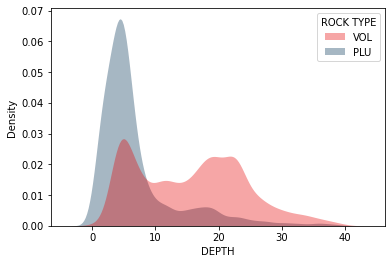

In [46]:
sns.kdeplot(
    data=data.loc[data["SIO2(WT%)"].notna()],
    x="DEPTH",
    hue = 'ROCK TYPE',
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

##### SiO2

<AxesSubplot:xlabel='SIO2(WT%)', ylabel='Density'>

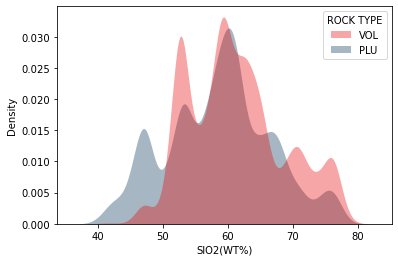

In [47]:
sns.kdeplot(
    data=data.loc[data["SIO2(WT%)"].notna()],
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

[0.005387803433984606, 0.009117821195973949, 0.013558318531675547, 0.04227353463587922, 0.011486086441681469, 0.01580817051509769, 0.05358200118413262, 0.023386619301361752, 0.04061574896388395, 0.06027235050325636, 0.07756068679692125, 0.02557726465364121, 0.02670219064535228, 0.03641207815275311, 0.017998815867377147, 0.013262285375962107, 0.006216696269982238, 0.01290704558910598, 0.007874481941977502, 0.0]
[40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80]


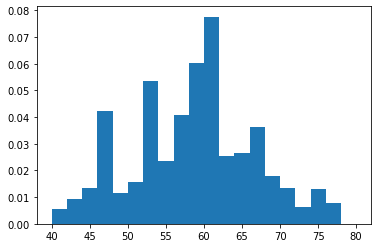

In [48]:
his = plt.hist(
    data.loc[
        (data["SIO2(WT%)"] >= 40)
        & (data["SIO2(WT%)"] <= 80)
        & (data["ROCK TYPE"] == "PLU")
    ]["SIO2(WT%)"],
    bins=np.arange(40, 81, 2),
    density=True,
)
p_density, bins, patches = his
print(list(p_density))
print(bins)

[0.00022401433691756272, 0.00022401433691756272, 0.0007280465949820789, 0.007448476702508961, 0.002800179211469534, 0.018313172043010754, 0.07935707885304659, 0.023129480286738353, 0.029961917562724014, 0.07913306451612903, 0.04491487455197132, 0.05398745519713262, 0.043290770609319, 0.01472894265232975, 0.020105286738351255, 0.027665770609318997, 0.013832885304659499, 0.021337365591397848, 0.018369175627240143, 0.00044802867383512545]
[40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80]


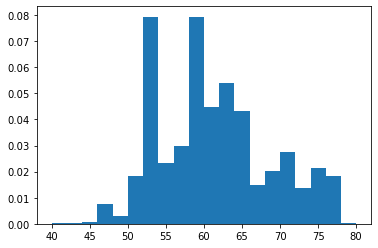

In [49]:
his = plt.hist(
    data.loc[
        (data["SIO2(WT%)"] >= 40)
        & (data["SIO2(WT%)"] <= 80)
        & (data["ROCK TYPE"] == "VOL")
    ]["SIO2(WT%)"],
    bins=np.arange(40, 81, 2),
    density=True,
)
p_density, bins, patches = his
print(list(p_density))
print(bins)

<AxesSubplot:xlabel='SIO2(WT%)', ylabel='Density'>

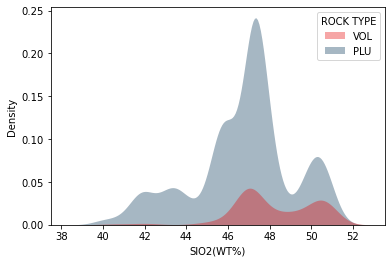

In [50]:
sns.kdeplot(
    data=data.loc[data["SIO2(WT%)"] <= 51],
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

<AxesSubplot:xlabel='SIO2(WT%)', ylabel='Density'>

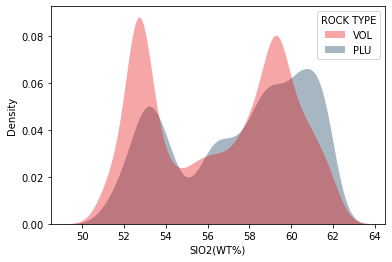

In [51]:
sns.kdeplot(
    data=data.loc[(data["SIO2(WT%)"] >= 51) & (data["SIO2(WT%)"] <= 62)],
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

<AxesSubplot:xlabel='SIO2(WT%)', ylabel='Density'>

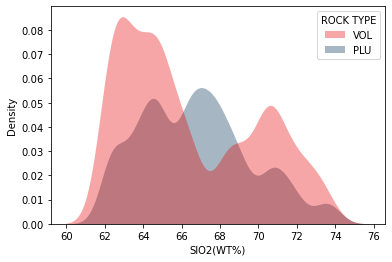

In [52]:
sns.kdeplot(
    data=data.loc[(data["SIO2(WT%)"] >= 62) & (data["SIO2(WT%)"] <= 74)],
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

<AxesSubplot:xlabel='SIO2(WT%)', ylabel='Density'>

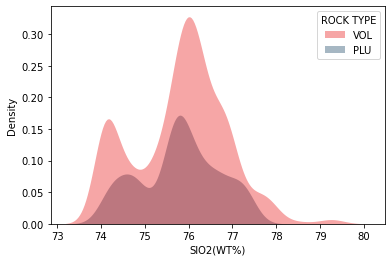

In [53]:
sns.kdeplot(
    data=data.loc[(data["SIO2(WT%)"] >= 74) & (data["SIO2(WT%)"] <= 80)],
    x="SIO2(WT%)",
    hue="ROCK TYPE",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

<AxesSubplot:xlabel='SIO2(WT%)', ylabel='Density'>

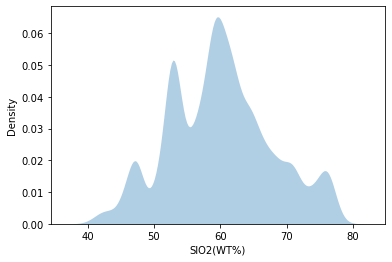

In [54]:
sns.kdeplot(
    data=data.loc[data["SIO2(WT%)"].notna()],
    x="SIO2(WT%)",
    fill=True,
    common_norm=True,
    alpha=0.35,
    linewidth=0,
    palette=colors,
)

### 2. 反加权

In [55]:
def invweight(data, lat, lon):
    data["k"] = np.nan
    if data["k"].count() == lat.count():
        pass
    else:
        for i in range(len(lat)):
            data.loc[i, "k"] = np.nansum(
                1
                / (
                    (
                        180
                        / np.pi
                        * np.arccos(
                            np.sin(lat[i] * np.pi / 180) * np.sin(lat * np.pi / 180)
                            + np.cos(lat[i] * np.pi / 180)
                            * np.cos(lat * np.pi / 180)
                            * np.cos(lon[i] * np.pi / 180 - lon * np.pi / 180)
                        )
                    )
                    ** 2
                    + 1
                )
            )
            print("\r counting k value of line %d" % (i + 1), end="")

In [56]:
invweight(
    data, data["LATITUDE MIN"], data["LONGITUDE MIN"]
)  # this line will spend about 30 min

 counting k value of line 82

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


 counting k value of line 17765

上面这行用循环，还是太慢了，有时间改成map函数试试

In [57]:
prob = 1 / (data["k"] * ((5 / data["k"]).median()) + 1)

In [58]:
prob.describe()

count    17765.000000
mean         0.242021
std          0.193255
min          0.067948
25%          0.079156
50%          0.166667
75%          0.374053
max          0.952570
Name: k, dtype: float64

#### Resampling the samples weighted by silica relative to the silica distribution of all-of-georoc for volcanics and plutonics.

In [59]:
# # Silica distribution density in arc, 20 bins, 40-80, calculated from Keller2015, VolcanicPlutonic.ipynb
# v_density_original = [
#     8.318083513558476e-05,
#     0.00033272334054233906,
#     0.0009149891864914324,
#     0.010730327732490434,
#     0.0032440525702878056,
#     0.023290633837963735,
#     0.0223756446514723,
#     0.025786058892031276,
#     0.02653468640825154,
#     0.09632340708700715,
#     0.05464980868407919,
#     0.05606388288138413,
#     0.06180336050573948,
#     0.020545666278489437,
#     0.029612377308268174,
#     0.03684910996506405,
#     0.00682082848111795,
#     0.012809848610880054,
#     0.010979870237897189,
#     0.00024954250540675427,
# ]
# p_density_original = [
#     0.00421093547551179,
#     0.038740606374708476,
#     0.01444674786214045,
#     0.014122829748639544,
#     0.011401917595231926,
#     0.006413578647317958,
#     0.051826898160145116,
#     0.024682560248769112,
#     0.0400362788287121,
#     0.06420057009587976,
#     0.0769629437678155,
#     0.026107799948173104,
#     0.02869914485618036,
#     0.03945322622441047,
#     0.01891681782845297,
#     0.014511531484840632,
#     0.006802280383519046,
#     0.009847110650427572,
#     0.008616221819124125,
#     0.0,
# ]

# # Georoc arc
# vol_density = [
#     0.0009595677287125024,
#     0.0023616545556176633,
#     0.00572479970188187,
#     0.01655487236817589,
#     0.036379727967207,
#     0.05068474007825601,
#     0.052939258431153345,
#     0.04769890068939817,
#     0.044093534563070615,
#     0.04355785354946898,
#     0.04155953046394634,
#     0.02980715483510341,
#     0.022922489286379726,
#     0.018208496366685298,
#     0.01645705235699646,
#     0.0174864915222657,
#     0.021627538662194894,
#     0.01865101546487796,
#     0.00990776970374511,
#     0.002417551704863052,
# ]
# plu_density = [
#     0.011806130903065452,
#     0.016518227009113505,
#     0.02640845070422535,
#     0.02998135874067937,
#     0.033709610604805304,
#     0.02749585749792875,
#     0.026667357083678542,
#     0.02324979287489644,
#     0.020764291632145816,
#     0.02117854183927092,
#     0.026563794531897267,
#     0.028013670256835127,
#     0.03427920463960232,
#     0.03609154929577465,
#     0.03246685998342999,
#     0.030809859154929578,
#     0.030654515327257662,
#     0.027910107705053852,
#     0.01335956917978459,
#     0.002071251035625518,
# ]
# # # earthchem arc
# # vol_density = [0.0008544542589551245, 0.001753295752141684, 0.0049158861911314305, 0.021516711793688137, 0.046207110834923876, 0.057492565138266234, 0.06172044919881042, 0.050046606595943004, 0.044808912956633674, 0.04321097252430201, 0.0397154778285765, 0.03270229482000977, 0.02281503839495761, 0.01475875538195215, 0.01368236495183985, 0.011940166008256026, 0.013937591548670603, 0.0110857117493009, 0.005526210661813662, 0.0013094234098273336]
# # plu_density = [0.003006012024048096, 0.005792835671342685, 0.008610971943887775, 0.013057364729458917, 0.01747244488977956, 0.023922845691382765, 0.031437875751503, 0.035539829659318636, 0.0375438376753507, 0.04186497995991984, 0.04574774549098196, 0.04746993987975952, 0.03638527054108216, 0.03316007014028056, 0.0313439378757515, 0.026772294589178357, 0.02971568136272545, 0.019476452905811622, 0.010270541082164329, 0.0014090681362725452]

# v_density_original = np.array(v_density_original)
# p_density_original = np.array(p_density_original)
# vol_density = np.array(vol_density)
# plu_density = np.array(plu_density)

# vol_density = vol_density / v_density_original
# plu_density = plu_density / p_density_original

# si_range = np.arange(40, 81, 2)
# for i in range(len(si_range) - 1):
#     p_si_range = (
#         (data["SIO2(WT%)"] >= si_range[i])
#         & (data["SIO2(WT%)"] <= si_range[i + 1])
#         & (data["ROCK TYPE"] == "PLU")
#     )
#     v_si_range = (
#         (data["SIO2(WT%)"] >= si_range[i])
#         & (data["SIO2(WT%)"] <= si_range[i + 1])
#         & (data["ROCK TYPE"] == "VOL")
#     )
#     prob.loc[p_si_range] = prob.loc[p_si_range] * plu_density[i]
#     prob.loc[v_si_range] = prob.loc[v_si_range] * vol_density[i]

In [60]:
prob.describe()

count    17765.000000
mean         0.242021
std          0.193255
min          0.067948
25%          0.079156
50%          0.166667
75%          0.374053
max          0.952570
Name: k, dtype: float64

### 3. 蒙特卡罗

In [61]:
# Number of simulations
nsims = 1000

ndata = len(simitemsin)

nbins = 20

# binedges = np.linspace(agemin,agemax, num=(nbins + 1))
binedges = np.linspace(dpmin, dpmax, num=(nbins + 1))

In [62]:
data["dp_bins"] = pd.cut(data["DEPTH"], binedges)
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    data_count = data.groupby(["ROCK TYPE", "dp_bins"]).count()
    display(data_count)

LATITUDE MIN  LONGITUDE MIN  MAX. AGE (YRS.)  \
ROCK TYPE dp_bins                                                      
PLU       (0.0, 2.0]            1176           1176              511   
          (2.0, 4.0]            2017           2017             1326   
          (4.0, 6.0]            2508           2508             1703   
          (6.0, 8.0]             990            990              543   
          (8.0, 10.0]            433            433              156   
          (10.0, 12.0]           270            270               89   
          (12.0, 14.0]           156            156               42   
          (14.0, 16.0]           195            195               41   
          (16.0, 18.0]           200            200               41   
          (18.0, 20.0]           222            222               47   
          (20.0, 22.0]           104            104               18   
          (22.0, 24.0]           107            107               43   
          (24.0, 26.0]            69             69               12   
          (26.0, 28.0]            57             57               23   
          (28.0, 30.0]            28             28                7   
          (30.0, 32.0]            35             35               16   
          (32.0, 34.0]            26             26               12   
          (34.0, 36.0]            23             23                6   
          (36.0, 38.0]            29             29                1   
          (38.0, 40.0]            16             16                4   
VOL       (0.0, 2.0]              29             29                2   
          (2.0, 4.0]             503            503              395   
          (4.0, 6.0]            1232           1232              825   
          (6.0, 8.0]             717            717              357   
          (8.0, 10.0]            442            442              136   
          (10.0, 12.0]           571            571              146   
          (12.0, 14.0]           436            436              122   
          (14.0, 16.0]           491            491              104   
          (16.0, 18.0]           666            666              186   
          (18.0, 20.0]           847            847              282   
          (20.0, 22.0]           699            699              142   
          (22.0, 24.0]           910            910              192   
          (24.0, 26.0]           383            383               73   
          (26.0, 28.0]           299            299               57   
          (28.0, 30.0]           193            193               29   
          (30.0, 32.0]           162            162               22   
          (32.0, 34.0]           137            137               17   
          (34.0, 36.0]            96             96               10   
          (36.0, 38.0]            70             70                7   
          (38.0, 40.0]            35             35                1   

                        SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  FEOT(WT%)  MGO(WT%)  \
ROCK TYPE dp_bins                                                               
PLU       (0.0, 2.0]         1034        990         992        532       989   
          (2.0, 4.0]         1964       1904        1902        619      1885   
          (4.0, 6.0]         2477       2429        2355        742      2326   
          (6.0, 8.0]          983        967         944        448       820   
          (8.0, 10.0]         431        418         392        219       336   
          (10.0, 12.0]        267        252         244        158       216   
          (12.0, 14.0]        154        150         125        111       123   
          (14.0, 16.0]        195        187         147        137       153   
          (16.0, 18.0]        198        191         154        157       157   
          (18.0, 20.0]        220        212         172        169       181   
          (20.0, 22.0]     

In [63]:
# remove outliers
if exclude_outliers == "sectional":
    for b in range(len(binedges) - 1):
        for r in ["VOL", "PLU"]:
            col = data.loc[
                (data["DEPTH"] > binedges[b])
                & (data["DEPTH"] <= binedges[b + 1])
                & (data["ROCK TYPE"] == r)
            ]
            for c in col.columns[4:-3]:
                data.loc[
                    (data["DEPTH"] > binedges[b])
                    & (data["DEPTH"] <= binedges[b + 1])
                    & (data["ROCK TYPE"] == r),
                    c,
                ] = remove_outliers(col[c])

#### Resampling by SiO2 of all-of-Georoc

In [64]:
all_whole_rock = pd.read_csv('drop_duplicates_data_2021.csv')
# vol_whole_rock = all_whole_rock[all_whole_rock['ROCK TYPE'] == 'VOL']
# plu_whole_rock = all_whole_rock[all_whole_rock['ROCK TYPE'] == 'PLU']

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13,14,15,24,25,170) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


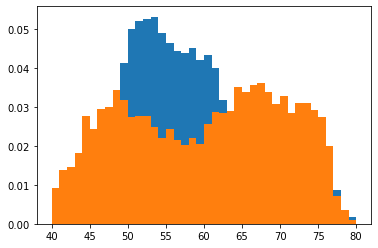

In [65]:
v_his = plt.hist(
    all_whole_rock.loc[
        (all_whole_rock["SIO2(WT%)"] >= 40)
        & (all_whole_rock["SIO2(WT%)"] <= 80)
        & (all_whole_rock["ROCK TYPE"] == "VOL")
        & (all_whole_rock['TECTONIC SETTING'] == 'CONVERGENT MARGIN')
    ]["SIO2(WT%)"],
    bins=np.arange(40, 81, 1),
    density=True,
)
v_distribution, bins, patches = v_his

p_his = plt.hist(
    all_whole_rock.loc[
        (all_whole_rock["SIO2(WT%)"] >= 40)
        & (all_whole_rock["SIO2(WT%)"] <= 80)
        & (all_whole_rock["ROCK TYPE"] == "PLU")
        & (all_whole_rock['TECTONIC SETTING'] == 'CONVERGENT MARGIN')
    ]["SIO2(WT%)"],
    bins=np.arange(40, 81, 1),
    density=True,
)
p_distribution, bins, patches = p_his

In [66]:
n = 10**5
v_si_to_draw = (draw_from_distribution(v_distribution, n) * 40) + 40
p_si_to_draw = (draw_from_distribution(p_distribution, n) * 40) + 40
data.loc[:, "prob"] = prob

In [67]:
# v_rows_drawn = pd.DataFrame()
# for i in range(len(v_si_to_draw)):
#     t = (data["ROCK TYPE"] == "VOL") & (data['SIO2(WT%)'] > v_si_to_draw[i] - 1) & (data['SIO2(WT%)'] < v_si_to_draw[i] + 1)
#     v_data_drawn = data[t]
#     if len(v_data_drawn) > 0:
#         v_row_drawn = data[t].sample(n = 1, replace=True, weights = 'prob', axis=0)
#         v_rows_drawn = v_rows_drawn.append(v_row_drawn)
# #     print("\r" + str(i + 1), end="")
    
# v_rows_drawn.reset_index(drop = True, inplace = True)

In [68]:
# p_rows_drawn = pd.DataFrame()
# for i in range(len(p_si_to_draw)):
#     t = (data["ROCK TYPE"] == "PLU") & (data['SIO2(WT%)'] > p_si_to_draw[i] - 1) & (data['SIO2(WT%)'] < p_si_to_draw[i] + 1)
#     p_data_drawn = data[t]
#     if len(p_data_drawn) > 0:
#         p_row_drawn = p_data_drawn.sample(n = 1, replace=True, weights = 'prob', axis=0)
#         p_rows_drawn = p_rows_drawn.append(p_row_drawn)
# #     print("\r" + str(i + 1), end="")
    
# p_rows_drawn.reset_index(drop = True, inplace = True)

In [69]:
def resample_by_si_loc(df, rock_type):
    rows_drawn = pd.DataFrame()
    if rock_type == 'PLU':
        si_to_draw = p_si_to_draw
    elif rock_type == 'VOL':
        si_to_draw = v_si_to_draw
    for i in range(len(si_to_draw)):
        t = (df["ROCK TYPE"] == rock_type) & (df['SIO2(WT%)'] > si_to_draw[i] - 1) & (df['SIO2(WT%)'] < si_to_draw[i] + 1)
        data_drawn = df[t]
        if len(data_drawn) > 0:
            row_drawn = data_drawn.sample(n = 1, replace=True, weights = 'prob', axis=0)
            rows_drawn = rows_drawn.append(row_drawn)
    rows_drawn.reset_index(drop = True, inplace = True)
    return rows_drawn

In [70]:
%%time
v_rows_drawn = resample_by_si_loc(data, 'VOL')
p_rows_drawn = resample_by_si_loc(data, 'PLU')
# pool = multiprocessing.Pool(processes=4)
# v_rows_drawn = pool.apply_async(resample_by_si_loc, (data, 'VOL',))
# p_rows_drawn = pool.apply_async(resample_by_si_loc, (data, 'PLU',))
# pool.close()
# pool.join()
# print("Sub-process(es) done.")

CPU times: user 22min 20s, sys: 9.35 s, total: 22min 30s
Wall time: 22min 29s


In [71]:
vp_resampling = [v_rows_drawn, p_rows_drawn]
data_resampling = pd.concat(vp_resampling)
data_resampling.reset_index(drop = True, inplace=True)

(array([1132.,  254.,  503., 3598., 4656., 4062., 3336., 2543., 2225.,
        1820., 2305., 3664., 2506., 3089., 3561., 3328., 4245., 3923.,
        4841., 4376., 4894., 3996., 7161., 5398., 2285., 2545., 1950.,
        1807.,  946., 1189., 1063.,  686.,  838.,  709.,  789.,  558.,
         571.,  460.,   93.,  356.]),
 array([3.46370032e-02, 1.02825299e+00, 2.02186898e+00, 3.01548497e+00,
        4.00910096e+00, 5.00271695e+00, 5.99633294e+00, 6.98994893e+00,
        7.98356492e+00, 8.97718091e+00, 9.97079690e+00, 1.09644129e+01,
        1.19580289e+01, 1.29516449e+01, 1.39452609e+01, 1.49388768e+01,
        1.59324928e+01, 1.69261088e+01, 1.79197248e+01, 1.89133408e+01,
        1.99069568e+01, 2.09005728e+01, 2.18941888e+01, 2.28878048e+01,
        2.38814208e+01, 2.48750367e+01, 2.58686527e+01, 2.68622687e+01,
        2.78558847e+01, 2.88495007e+01, 2.98431167e+01, 3.08367327e+01,
        3.18303487e+01, 3.28239647e+01, 3.38175806e+01, 3.48111966e+01,
        3.58048126e+01, 3.6798

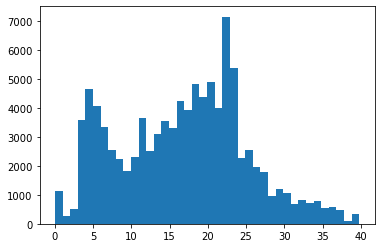

In [72]:
plt.hist(data_resampling[data_resampling['ROCK TYPE'] == 'VOL']['DEPTH'] ,bins = 40)

In [73]:
def bins(df, bin_type, binedges):
    if bin_type == 'dp_bins':
        bin_by = 'DEPTH'
    elif bin_type == 'si_bins':
        bin_by = 'SIO2(WT%)'
    df.iloc[:, 4:-16] = df.iloc[:, 4:-16] + df.iloc[:, 4:-16] * (list(elerr.values())[:-2] * np.random.randn(len(elerr) - 2))
    df.loc[:, "DEPTH"] = df.loc[:, "DEPTH"] + df.loc[:, "DEPTH"] * elerr["DEPTH"] * np.random.randn(df.loc[:, "DEPTH"].shape[0])
    
    df.loc[:, bin_type] = pd.cut(df.loc[:, bin_by], binedges)
    df_eve = (df.groupby(["ROCK TYPE", bin_type])).mean()
    df_num = df.groupby(["ROCK TYPE", bin_type]).count()
    df_std = df.groupby(["ROCK TYPE", bin_type]).std()
    df_err = df_eve.copy()
    df_err[simitemsin[4:]] = (1.96 * df_std[simitemsin[4:]] / df_num[simitemsin[4:]].apply(np.sqrt))
    df_eve.reset_index(inplace=True)
    df_err.reset_index(inplace=True)
    return df_eve, df_err

sim_mean, sim_err = bins(data_resampling, 'dp_bins', binedges)

In [74]:
# # mc:Monte Carlo
# data.loc[:, "prob"] = prob


# def mc(data, prob, binedges, nbins):  # uncert,
#     # 生成形状为 len(prob) ✖ 1 的随机数
#     data.loc[:, "r"] = np.random.rand(len(prob), 1)

#     # Randomize elements
#     ssdata = data.loc[data.loc[:, "prob"] > data.loc[:, "r"]]
#     # Resampling by Si distribution of all-of-Georoc
#     ssdata.iloc[:, 4:-16] = ssdata.iloc[:, 4:-16] + ssdata.iloc[:, 4:-16] * (list(elerr.values())[:-1] * np.random.randn(len(elerr) - 1))
#     ssdata.loc[:, "DEPTH"] = ssdata.loc[:, "DEPTH"] + ssdata.loc[:, "DEPTH"] * elerr["DEPTH"] * np.random.randn(ssdata.loc[:, "DEPTH"].shape[0])

#     # calculate average group by age bins
#     ssdata.loc[:, "dp_bins"] = pd.cut(ssdata.loc[:, "DEPTH"], binedges)
#     ssdata_ave = (
#         ssdata.groupby(["ROCK TYPE", "dp_bins"])
#     ).mean()  # ['TECTONIC SETTING','dp_bins']
#     ssdata_num = ssdata.groupby(["ROCK TYPE", "dp_bins"]).count()

#     # ssdata_ave = (ssdata.groupby('dp_bins')).mean()
#     ssdata_ave.reset_index(inplace=True)
#     ssdata_num.reset_index(inplace=True)

#     return ssdata_ave, ssdata_num
#     # done

In [75]:
# %%capture --no-stdout
# %%time

# simaverage_dict = []
# simnum_dict = []
# for i in range(nsims):
#     avg, num = mc(data, prob, binedges, nbins)

#     simaverage_dict.append(avg)
#     simnum_dict.append(num)
#     print("\r" + str(i + 1), end="")

# simaverage = pd.concat(simaverage_dict, keys=list(range(nsims)))
# simnum = pd.concat(simnum_dict, keys=list(range(nsims)))

In [76]:
# simaverage.groupby("ROCK TYPE").count()

In [77]:
# simaverage

### 作图

#### 火山岩和侵入岩随深度的成分变化

In [78]:
# 为画图设置颜色和构造背景
# tec 是分类方式
# tec = 'TECTONIC SETTING'
tec = "ROCK TYPE"
# clrs = ['E60000', '003153']
clrs = colors  # list(map(lambda a: '#' + a, colors))
# tect_set = list(set(simaverage[tec]))
# tect_set = ['CONVERGENT MARGIN', 'INTRAPLATE VOLCANICS', 'OCEAN ISLAND', 'RIFT VOLCANICS']
# tect_set = ['CONVERGENT MARGIN']
tect_set = ["VOL", "PLU"]

In [79]:
# sim_mean = simaverage.groupby([tec, "dp_bins"]).mean()  # or median
# sim_mean.reset_index(inplace=True)
# # sim_mean = sim_mean[simitemsin[5:]]

# sim_std = simaverage.groupby([tec, "dp_bins"]).std()
# sim_std.reset_index(inplace=True)
# # sim_std = sim_std[simitemsin[5:]]

# sim_num = simnum.groupby([tec, "dp_bins"]).mean()
# sim_num.reset_index(inplace=True)
# # sim_num = sim_num[simitemsin[5:]]

# # sim_stat = simaverage.groupby(['TECTONIC SETTING', 'si_bins']).agg(['mean', 'std', 'count'])

# sim_err = sim_mean.copy()
# sim_err[simitemsin[4:]] = (
#     1.96 * sim_std[simitemsin[4:]] / sim_num[simitemsin[4:]].apply(np.sqrt)
# )

SIO2(WT%)
 # of tectonic setting: 2 

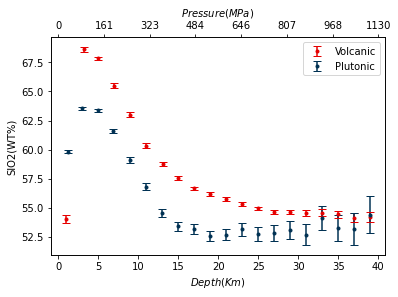

TIO2(WT%)
 # of tectonic setting: 2 

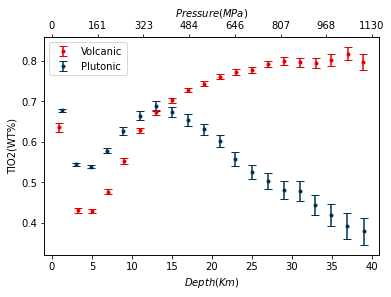

AL2O3(WT%)
 # of tectonic setting: 2 

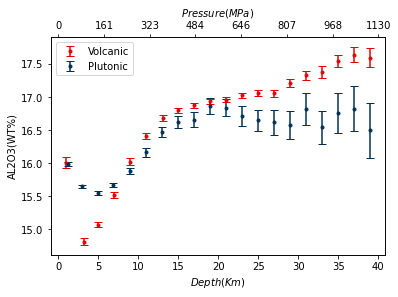

FEOT(WT%)
 # of tectonic setting: 2 

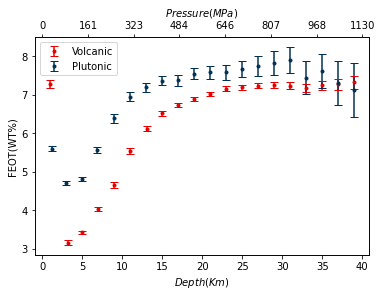

MGO(WT%)
 # of tectonic setting: 2 

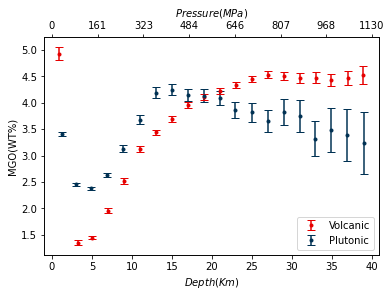

CAO(WT%)
 # of tectonic setting: 2 

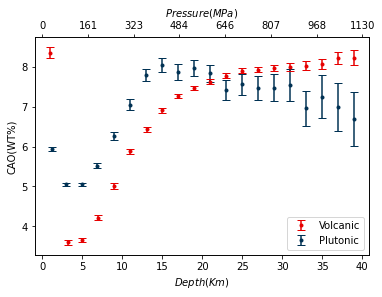

MNO(WT%)
 # of tectonic setting: 2 

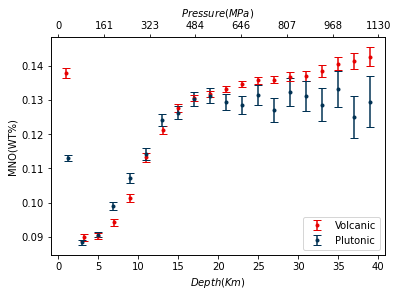

NA2O(WT%)
 # of tectonic setting: 2 

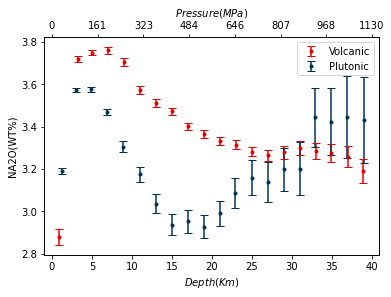

K2O(WT%)
 # of tectonic setting: 2 

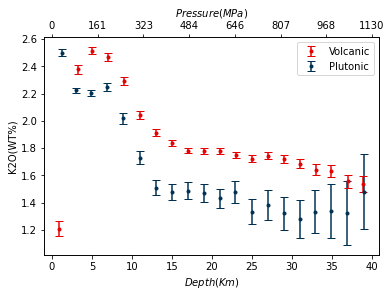

P2O5(WT%)
 # of tectonic setting: 2 

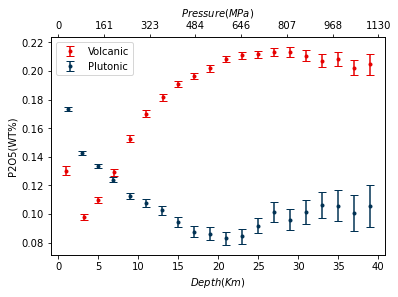

CR(PPM)
 # of tectonic setting: 2 

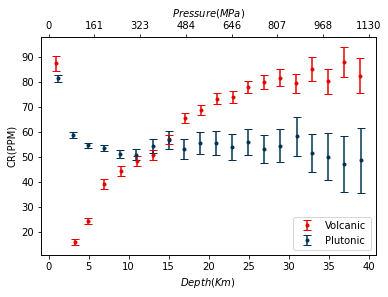

CO(PPM)
 # of tectonic setting: 2 

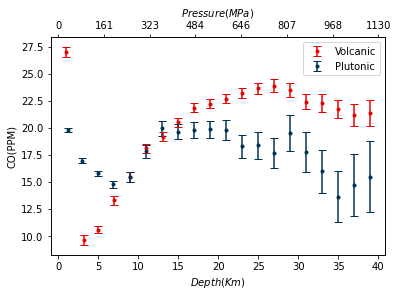

NI(PPM)
 # of tectonic setting: 2 

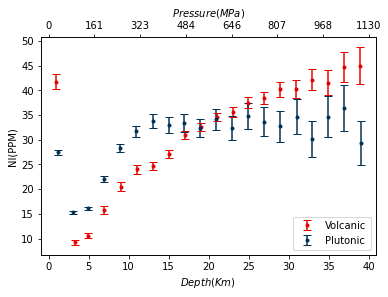

LA(PPM)
 # of tectonic setting: 2 

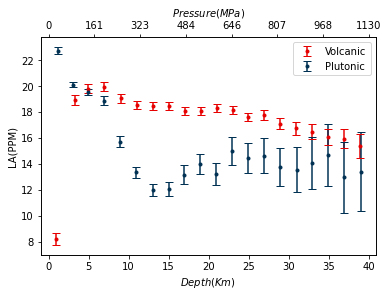

CE(PPM)
 # of tectonic setting: 2 

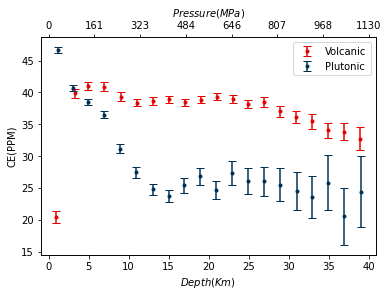

PR(PPM)
 # of tectonic setting: 2 

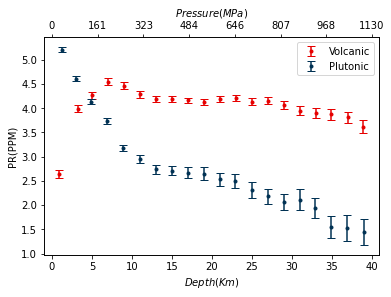

ND(PPM)
 # of tectonic setting: 2 

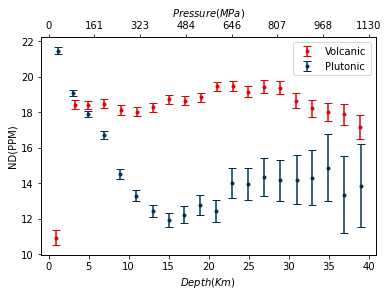

SM(PPM)
 # of tectonic setting: 2 

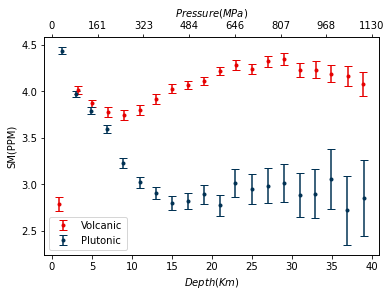

EU(PPM)
 # of tectonic setting: 2 

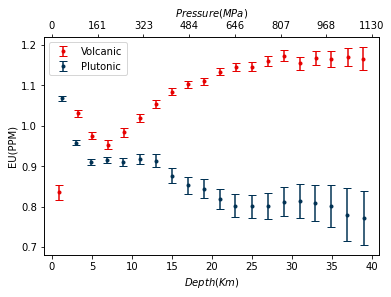

GD(PPM)
 # of tectonic setting: 2 

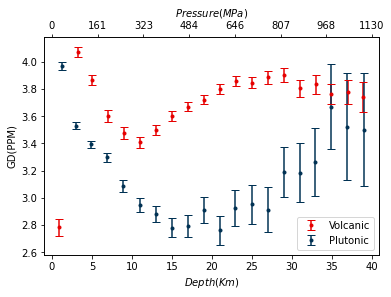

TB(PPM)
 # of tectonic setting: 2 

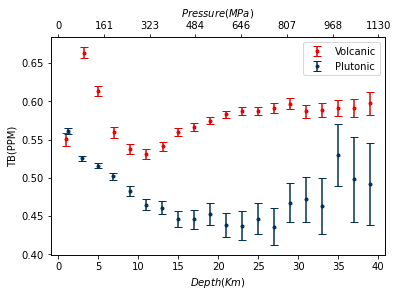

DY(PPM)
 # of tectonic setting: 2 

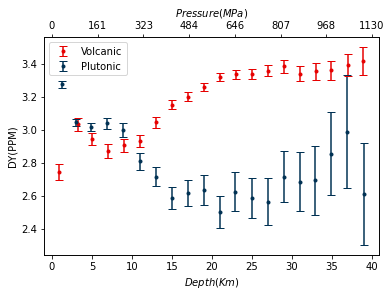

HO(PPM)
 # of tectonic setting: 2 

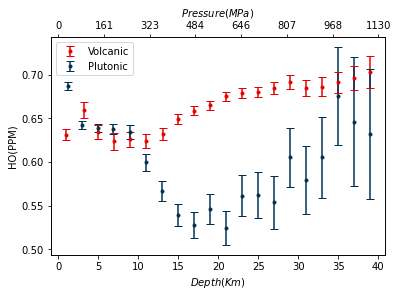

ER(PPM)
 # of tectonic setting: 2 

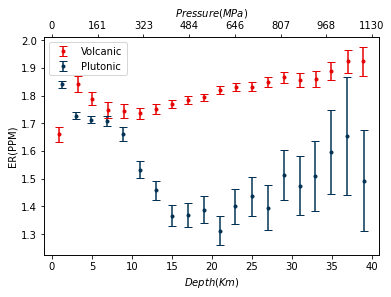

TM(PPM)
 # of tectonic setting: 2 

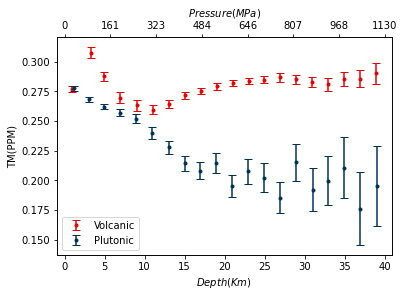

YB(PPM)
 # of tectonic setting: 2 

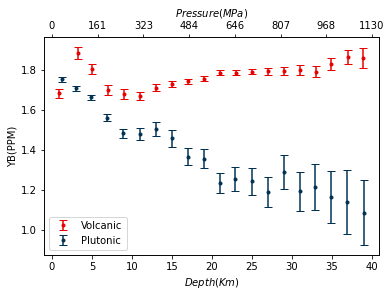

LU(PPM)
 # of tectonic setting: 2 

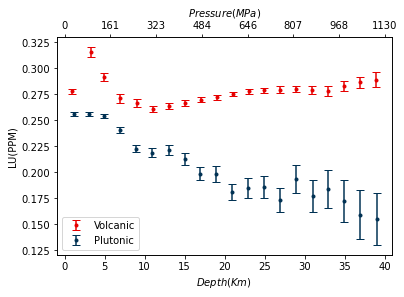

Y(PPM)
 # of tectonic setting: 2 

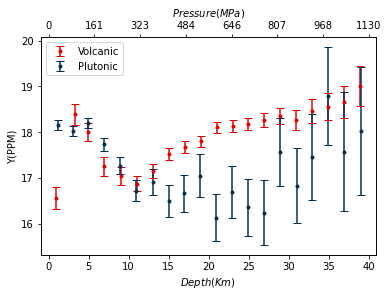

SC(PPM)
 # of tectonic setting: 2 

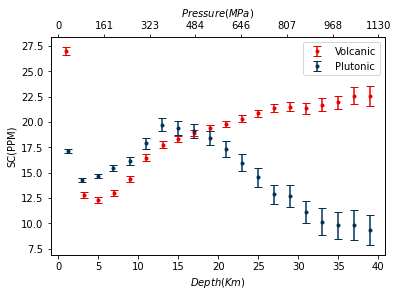

V(PPM)
 # of tectonic setting: 2 

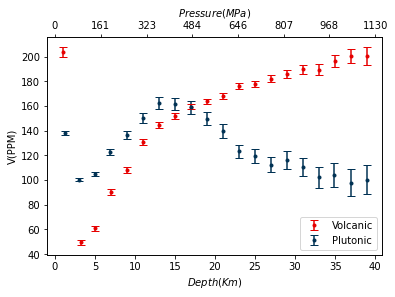

ZR(PPM)
 # of tectonic setting: 2 

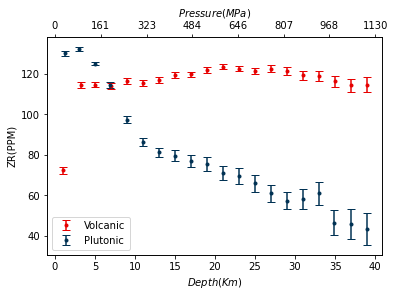

HF(PPM)
 # of tectonic setting: 2 

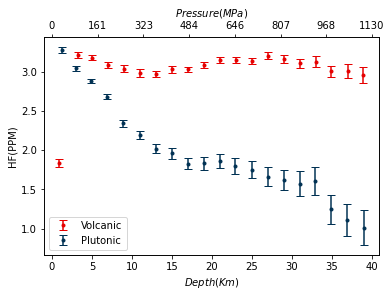

RB(PPM)
 # of tectonic setting: 2 

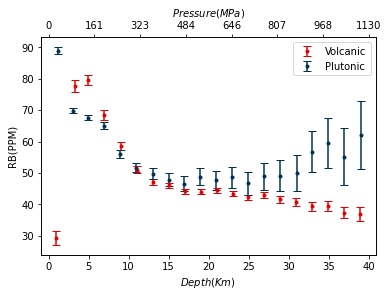

SR(PPM)
 # of tectonic setting: 2 

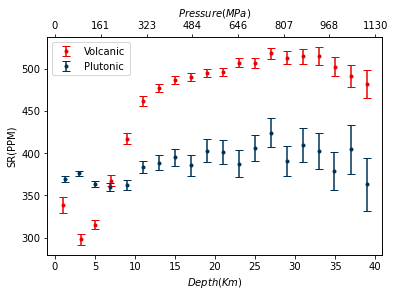

BA(PPM)
 # of tectonic setting: 2 

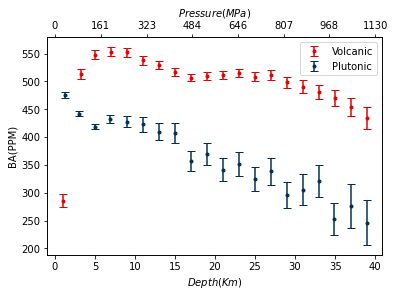

NB(PPM)
 # of tectonic setting: 2 

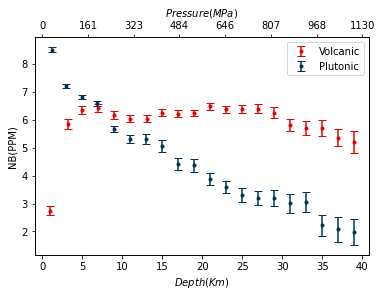

TA(PPM)
 # of tectonic setting: 2 

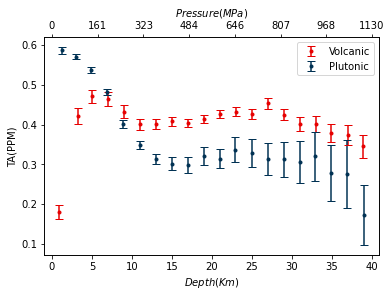

U(PPM)
 # of tectonic setting: 2 

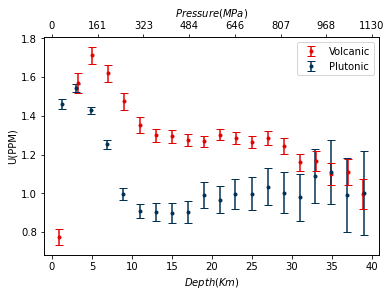

TH(PPM)
 # of tectonic setting: 2 

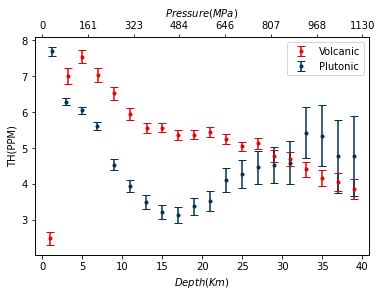

mSiO23
 # of tectonic setting: 2 

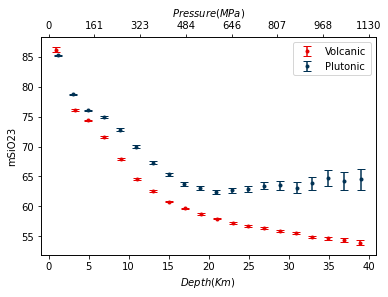

Eu/Eu*
 # of tectonic setting: 2 

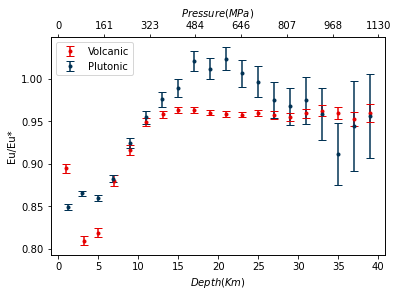

(La/Yb)N
 # of tectonic setting: 2 

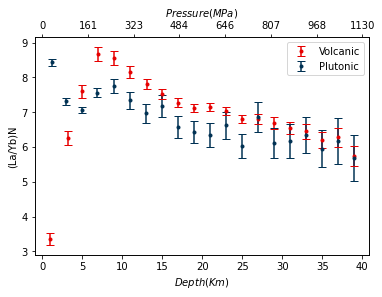

La/Yb
 # of tectonic setting: 2 

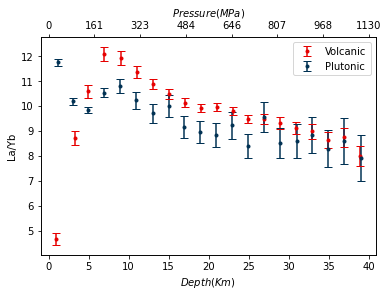

Sr/Y
 # of tectonic setting: 2 

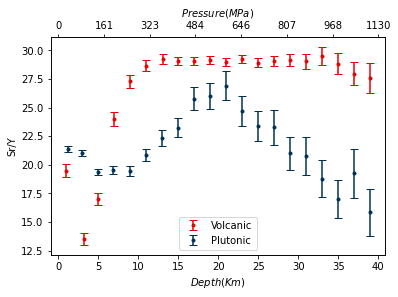

Rb/Sr
 # of tectonic setting: 2 

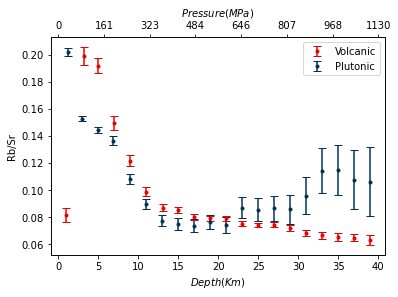

Ba/Rb
 # of tectonic setting: 2 

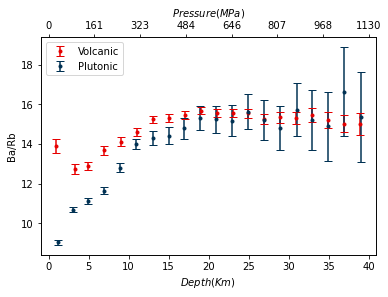

Ba/Sr
 # of tectonic setting: 2 

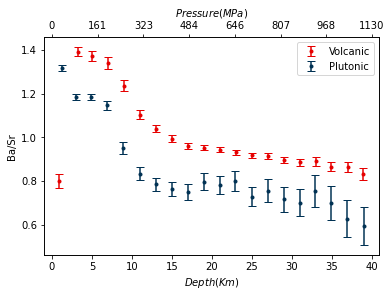

Ni/Co
 # of tectonic setting: 2 

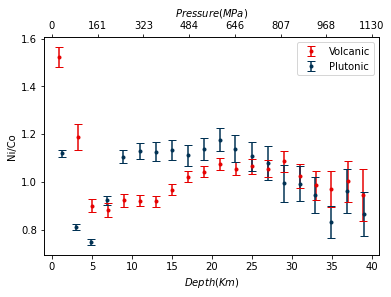

Nb/Ta
 # of tectonic setting: 2 

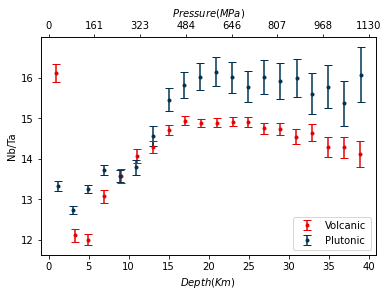

ree
 # of tectonic setting: 2 

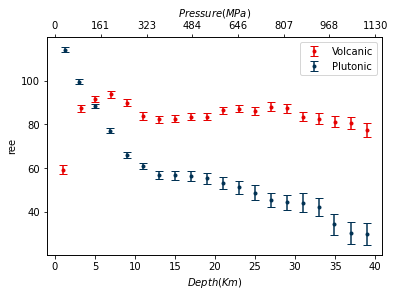

T
 # of tectonic setting: 2 

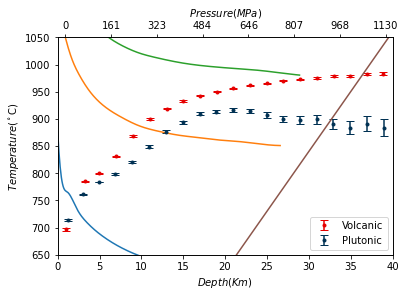

DEPTH
 # of tectonic setting: 2 

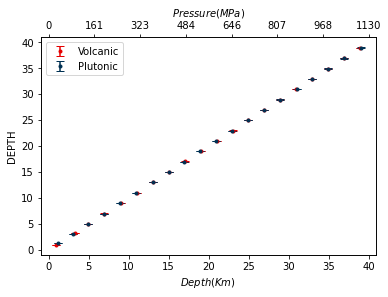

CPU times: user 10.7 s, sys: 212 ms, total: 10.9 s
Wall time: 10.7 s


In [80]:
%%time

# 根据构造背景分类的barplot
for i in simitemsin[4:]:
    print(i)
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax2 = ax1.twiny()
    #     # add horizontal lines of R&G 2003
    #     if i in cc_avg.keys():
    #         ax1.hlines(cc_avg[i][0], 0, uc_bt, colors = 'gray', linewidth = 8, alpha = 0.4)
    #         ax1.hlines(cc_avg[i][1], uc_bt, mc_bt, colors = 'gray', linewidth = 8, alpha = 0.4)
    #         ax1.hlines(cc_avg[i][2], mc_bt, lc_bt, colors = 'gray', linewidth = 8, alpha = 0.4)
    #         ax1.hlines(cc_avg[i][3], 0, lc_bt, colors = 'gray')

    #     # add horizontal lines of primitive mantle
    #     if i in pm.keys():
    #         ax1.hlines(pm[i], 0, lc_bt, colors = 'black')

    #     # add horizontal lines of upper, middle, lower, and bulk crust.
    #     if i in uc_avg.keys():
    #         for l in range(len(uc_avg[i])):
    #             ax1.hlines(uc_avg[i][l], 0, uc_bt, colors = 'darkgreen', alpha = l/len(uc_avg[i])*.7, linewidth = 4)
    #         for l in range(len(mc_avg[i])):
    #             ax1.hlines(mc_avg[i][l], uc_bt, mc_bt, colors = 'darkgreen', alpha = l/len(mc_avg[i])*.7, linewidth = 4)
    #         for l in range(len(lc_avg[i])):
    #             ax1.hlines(lc_avg[i][l], mc_bt, lc_bt, colors = 'darkgreen', alpha = l/len(lc_avg[i])*.7, linewidth = 4)
    #         for l in range(len(bc_avg[i])):
    #             ax1.hlines(bc_avg[i][l], 0, lc_bt, colors = 'gray', alpha = l/len(bc_avg[i]))

    #     # Add composition range of upper, middle, and lower crust
    #     if i in uc_avg.keys():
    #         uc_q1, uc_q3 = np.nanpercentile(uc_avg[i][2: -3], [25, 75]) # [2:-3] exclude old and upper-most data
    #         uc_iqr = uc_q3 - uc_q1
    #         mc_q1, mc_q3 = np.nanpercentile(mc_avg[i][2:], [25, 75]) # [2:]exclude old data
    #         mc_iqr = mc_q3 - mc_q1
    #         lc_q1, lc_q3 = np.nanpercentile(lc_avg[i][1:], [25, 75]) # [1:]exclude old data
    #         lc_iqr = lc_q3 - lc_q1

    #         ax1.add_patch(Rectangle((0, uc_q1), uc_bt, uc_iqr,facecolor = 'gray', alpha = 0.2))
    #         ax1.add_patch(Rectangle((uc_bt, mc_q1), mc_bt - uc_bt, mc_iqr,facecolor = 'gray', alpha = 0.2))
    #         ax1.add_patch(Rectangle((mc_bt, lc_q1), lc_bt - mc_bt, lc_iqr,facecolor = 'gray', alpha = 0.2))

    for j in range(len(tect_set)):
        clr = clrs[j]
        ax1.errorbar(
            x=sim_mean[sim_mean[tec] == tect_set[j]]["DEPTH"],
            y=sim_mean[sim_mean[tec] == tect_set[j]][i],
            yerr=sim_err[sim_err[tec] == tect_set[j]][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )  # , color = clr
        #         ax1.plot(sim_mean[sim_mean[tec] == tect_set[j]]['DEPTH'], sim_mean[sim_mean[tec] == tect_set[j]][i], color = clr)
        # plt.xlim(0, 40)
        plt.xlim(dpmin, dpmax)
        print("\r # of tectonic setting: %d" % (j + 1), end=" ")
    ax1.set_xlabel("$Depth (Km)$")
    ax1.set_ylabel(i)
    ax1.legend(labels=["Volcanic","Plutonic"])
    
    pressure_range = np.linspace(0, 40, 8)

    def depth2pressure(depth):
        pressure = depth * 2.88 * 9.807
        return ["%.0f" % z for z in pressure]

    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(pressure_range)
    ax2.set_xticklabels(depth2pressure(pressure_range))
    ax2.set_xlabel(r"$Pressure (MPa)$")

    if i == 'T':
        # Plot solidus
        ## Water-saturated solidi from Keller2015
        p_sld = np.array([-1.0321101, -0.8979358, -0.7603211, -0.6519495, -0.5315367, -0.38876146, -0.25802752, -0.15997706, -0.094610095, -0.065366976, -0.032683488, -0.008600918, 0.0]) # in GPa
        t_sld = np.array([594.02985, 596.5885, 603.4115, 607.6759, 612.79315, 628.99786, 652.0256, 681.02344, 711.72705, 733.9019, 765.45844, 809.8081, 877.1855])
        d_sld = p_sld * -1000 / 2.88 / 9.807
        ## Water-saturated basalt solidus from Latypov2003
        p_sld_bst = np.array([7.5069, 6.8189, 6.1309, 5.4429, 4.7549, 4.0944, 3.4061, 2.7452, 2.1389, 1.5599, 1.0904, 0.7308, 0.4535, 0.2586, 0.0913]) # in kbar
        t_sld_bst = np.array([850.98, 853.89, 858.26, 861.17, 865.54, 869.91, 877.19, 887.38, 903.4, 923.79, 950, 980.59, 1014.08, 1049.04, 1082.53])
        d_sld_bst = p_sld_bst * 100 / 2.88 / 9.807
        ## Water-saturated basalt liquidus from Latypov2003
        p_lqd_bst = np.array([8.1597, 7.4705, 6.7824, 6.0945, 5.4065, 4.2506, 3.5624, 3.2149, 2.8189, 2.1852, 1.7402, 1.6338, 1.1644, 1.1219]) # in kbar
        t_lqd_bst = np.array([980.59, 984.96, 989.33, 992.24, 995.16, 1002.44, 1009.72, 1014.08, 1019.91, 1034.47, 1049.04, 1053.41, 1079.62, 1082.53])
        d_lqd_bst = p_lqd_bst * 100 / 2.88 / 9.807
        ## Shield geotherm from Rothstein2003
        t_sld_gthm = np.array([201.33, 204.874, 212.7, 214.17, 223.466, 224.586, 232.763, 236.471, 242.575, 248.356, 251.354, 260.65, 260.758, 269.946, 272.643, 279.242, 284.528, 288.537, 295.895, 297.317, 305.196, 306.612, 315.39, 317.082, 323.651, 328.967, 331.912, 340.173, 340.852, 347.917, 352.737, 356.178, 364.438, 365.139, 372.699, 377.024, 380.96, 388.704, 388.909, 396.965, 401.826, 403.675, 411.641, 412.454, 420.198, 421.971, 428.458, 431.785, 436.202, 442.116, 443.946, 451.414, 452.207, 456.579, 459.95, 466.393, 467.694, 475.955, 476.724, 483.698, 486.538, 491.442, 496.352, 499.186, 506.682, 507.446, 515.19, 516.497, 522.933, 526.311, 531.195, 534.573, 538.938, 544.392, 545.423, 546.682, 554.942, 555.762, 559.369, 562.686, 569.183, 570.43, 578.69, 579.514, 586.434, 589.328, 594.177, 599.142, 602.438, 609.473, 610.182, 617.926, 619.287, 626.186, 629.101, 633.93, 638.915, 641.674, 649.246, 649.934, 657.678, 665.422, 673.682, 676.106, 681.426, 685.919, 689.17, 695.733, 727.242, 737.573])
        d_sld_gthm = np.array([9.3543, 9.5349, 9.9374, 10.0154, 10.5259, 10.5879, 11.0364, 11.238, 11.5769, 11.9148, 12.0874, 12.5979, 12.604, 13.1385, 13.2884, 13.649, 13.9531, 14.1895, 14.6185, 14.7, 15.1552, 15.2406, 15.8111, 15.927, 16.3817, 16.747, 16.9523, 17.5529, 17.6035, 18.1234, 18.4557, 18.694, 19.2946, 19.3448, 19.8652, 20.155, 20.4357, 21.0363, 21.0507, 21.6069, 22.062, 22.2075, 22.64, 22.688, 23.2886, 23.4258, 23.8892, 24.128, 24.4597, 24.9216, 25.0603, 25.6021, 25.6609, 25.9983, 26.2615, 26.7384, 26.8321, 27.4327, 27.4907, 28.0333, 28.256, 28.6339, 28.9987, 29.2045, 29.7483, 29.8051, 30.4057, 30.5102, 31.0063, 31.2406, 31.5768, 31.8304, 32.1774, 32.6058, 32.6841, 32.778, 33.3786, 33.4406, 33.7205, 33.9792, 34.4599, 34.5498, 35.1504, 35.2122, 35.751, 35.9821, 36.3516, 36.6933, 36.9221, 37.4661, 37.5227, 38.1233, 38.2244, 38.7239, 38.9346, 39.2945, 39.6841, 39.8951, 40.4446, 40.4957, 41.0963, 41.6669, 42.2675, 42.4536, 42.8681, 43.2028, 43.4386, 43.9196, 49.2306, 64.7592])
        
        ## Smooth curve
        ### Keller2015 solidus
        cubic_interploation_model = interp1d(d_sld, t_sld, kind = "cubic")
        d_sld_smth = np.linspace(d_sld.min(), d_sld.max(), 500)
        t_sld_smth = cubic_interploation_model(d_sld_smth)
        ax1.plot(d_sld_smth, t_sld_smth)
        ### Latypov2003 Solidus
        cubic_interploation_model_bst = interp1d(d_sld_bst, t_sld_bst, kind = "cubic")
        d_sld_bst_smth = np.linspace(d_sld_bst.min(), d_sld_bst.max(), 500)
        t_sld_bst_smth = cubic_interploation_model_bst(d_sld_bst_smth)
        ax1.plot(d_sld_bst_smth, t_sld_bst_smth)
        ### Latypov2003 Liquidus
        cubic_interploation_model_lqd = interp1d(d_lqd_bst, t_lqd_bst, kind = "cubic")
        d_lqd_bst_smth = np.linspace(d_lqd_bst.min(), d_lqd_bst.max(), 500)
        t_lqd_bst_smth = cubic_interploation_model_lqd(d_lqd_bst_smth)
        ax1.plot(d_lqd_bst_smth, t_lqd_bst_smth)
        ### Rothstein2003 Shield geotherm
        cubic_interploation_model_sg = interp1d(d_sld_gthm, t_sld_gthm, kind = "cubic")
        d_sld_gthm_smth = np.linspace(d_sld_gthm.min(), d_sld_gthm.max(), 500)
        t_sld_gthm_smth = cubic_interploation_model_sg(d_sld_gthm_smth)
        ax1.plot(d_sld_gthm_smth, t_sld_gthm_smth)

        ## Max backgroud geotherm from Rothstein2003
        d_mbg_1 = np.array([0, 10])
        t_mbg_1 = np.array([0, 400])
        ax1.plot(d_mbg_1, t_mbg_1)
        
        d_mbg_2 = np.array([10, 40])
        t_mbg_2 = np.array([400, 1060])
        ax1.plot(d_mbg_2, t_mbg_2)
        
        ax1.set_xlim(0,40)
        ax1.set_ylim(650,1050)
        ax1.set_ylabel(r'$Temperature (^\circ$C)')
        plt.savefig('./figures/figures_geology/depth_temp.svg', format="svg", transparent=True)

#     file_name = 'figures/errbar/' + 'CM' + '_' + i[:-5] + '_' + 'depth' + '.jpg'
#     plt.rcParams['savefig.dpi'] = 200
#     plt.savefig(file_name)
    plt.show()

#### 尝试区别部分熔融和分离结晶

##### la/sm-la

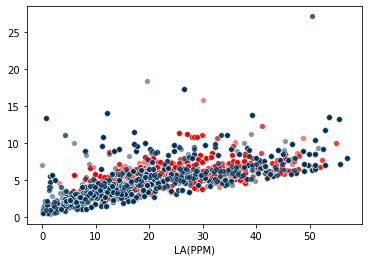

In [81]:
la_sm = data["LA(PPM)"] / data["SM(PPM)"]
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=data.loc[data["ROCK TYPE"] == "VOL", "LA(PPM)"],
    y=la_sm,
    color="#E60000",
    alpha=0.5,
    s=30,
)
ax = sns.scatterplot(
    x=data.loc[data["ROCK TYPE"] == "PLU", "LA(PPM)"],
    y=la_sm,
    color="#003153",
    alpha=0.5,
    s=30,
)

所以说是部分熔融？

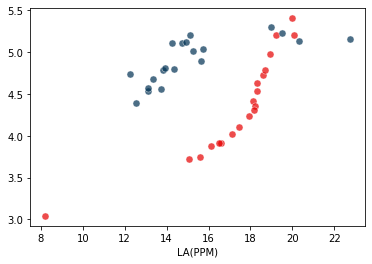

In [82]:
la_sm = sim_mean["LA(PPM)"] / sim_mean["SM(PPM)"]
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=sim_mean.loc[sim_mean["ROCK TYPE"] == "VOL", "LA(PPM)"],
    y=la_sm.loc[sim_mean["ROCK TYPE"] == "VOL"],
    color="#E60000",
    alpha=0.7,
    s=50,
)
ax = sns.scatterplot(
    x=sim_mean.loc[sim_mean["ROCK TYPE"] == "PLU", "LA(PPM)"],
    y=la_sm.loc[sim_mean["ROCK TYPE"] == "PLU"],
    color="#003153",
    alpha=0.7,
    s=50,
)

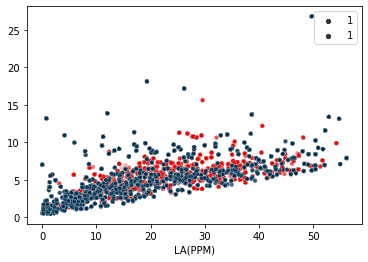

In [83]:
la_sm = data_resampling["LA(PPM)"] / data_resampling["SM(PPM)"]
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=data_resampling.loc[data_resampling["ROCK TYPE"] == "VOL", "LA(PPM)"],
    y=la_sm,
    color="#E60000",
    alpha=0.1,
    size=1,
)
ax = sns.scatterplot(
    x=data_resampling.loc[data_resampling["ROCK TYPE"] == "PLU", "LA(PPM)"],
    y=la_sm,
    color="#003153",
    alpha=0.1,
    size=1,
)

##### Rb-Th

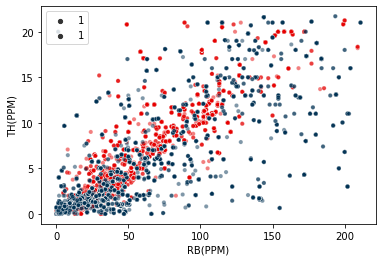

In [84]:
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=data.loc[data["ROCK TYPE"] == "VOL", "RB(PPM)"],
    y=data.loc[data["ROCK TYPE"] == "VOL", "TH(PPM)"],
    color="#E60000",
    alpha=0.5,
    size=1,
)
ax = sns.scatterplot(
    x=data.loc[data["ROCK TYPE"] == "PLU", "RB(PPM)"],
    y=data.loc[data["ROCK TYPE"] == "PLU", "TH(PPM)"],
    color="#003153",
    alpha=0.5,
    size=1,
)

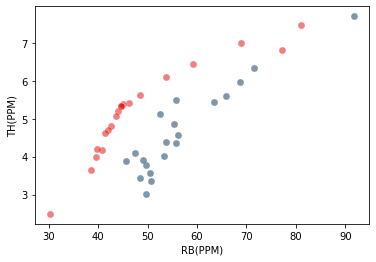

In [85]:
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=sim_mean.loc[sim_mean["ROCK TYPE"] == "VOL", "RB(PPM)"],
    y=sim_mean.loc[sim_mean["ROCK TYPE"] == "VOL", "TH(PPM)"],
    color="#E60000",
    alpha=0.5,
    s=50,
)
ax = sns.scatterplot(
    x=sim_mean.loc[sim_mean["ROCK TYPE"] == "PLU", "RB(PPM)"],
    y=sim_mean.loc[sim_mean["ROCK TYPE"] == "PLU", "TH(PPM)"],
    color="#003153",
    alpha=0.5,
    s=50,
)

但这样看又是分离结晶,或者，更仔细一点看的话，好像火山岩是分离结晶（过原点）而侵入岩是部分熔融（不过原点）？

##### log(Ni,Cr)-log(U,Rb,La, Th, Ta, Hf)

(0.1, 100)

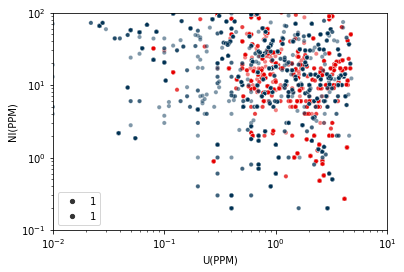

In [86]:
fig, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
ax = sns.scatterplot(
    x=data.loc[data["ROCK TYPE"] == "VOL", "U(PPM)"],
    y=data.loc[data["ROCK TYPE"] == "VOL", "NI(PPM)"],
    color="#E60000",
    alpha=0.5,
    size=1,
)
ax = sns.scatterplot(
    x=data.loc[data["ROCK TYPE"] == "PLU", "U(PPM)"],
    y=data.loc[data["ROCK TYPE"] == "PLU", "NI(PPM)"],
    color="#003153",
    alpha=0.5,
    size=1,
)
plt.xlim([0.01, 10])
plt.ylim([0.1, 100])

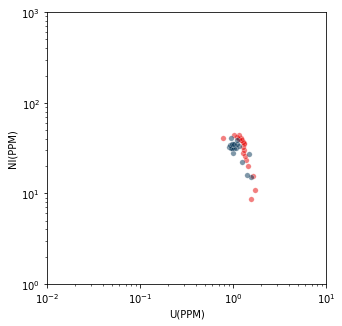

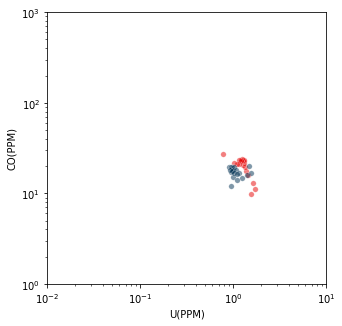

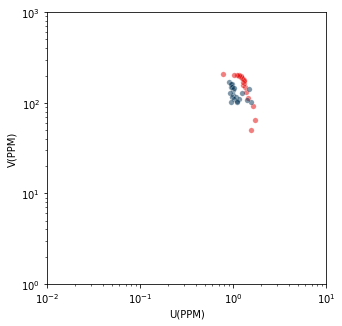

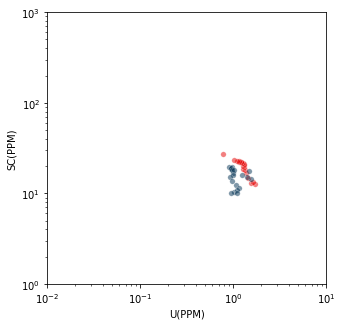

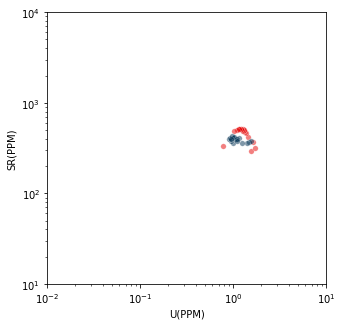

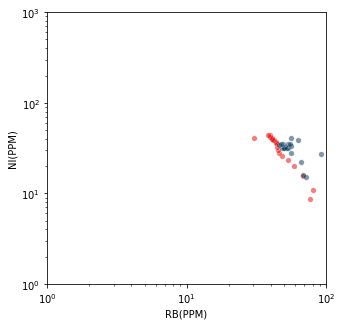

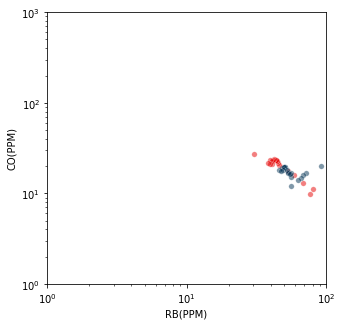

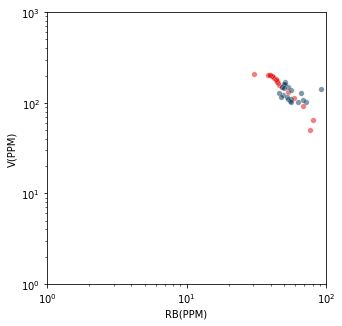

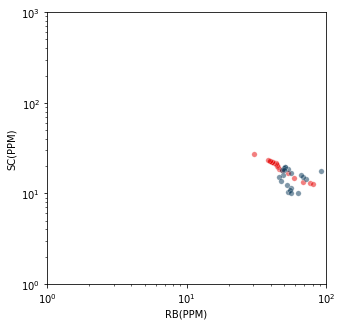

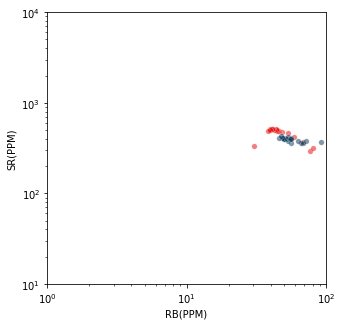

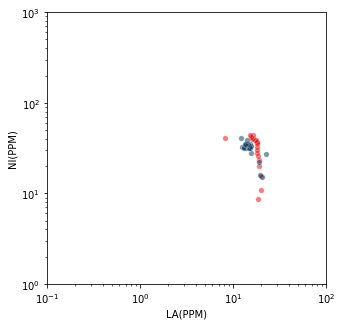

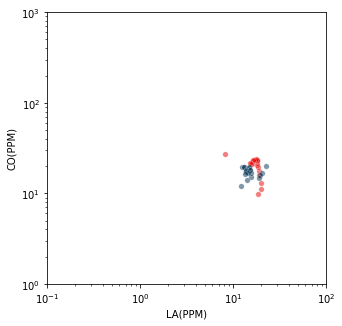

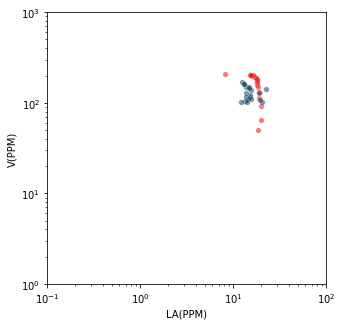

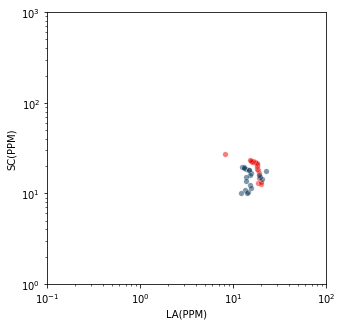

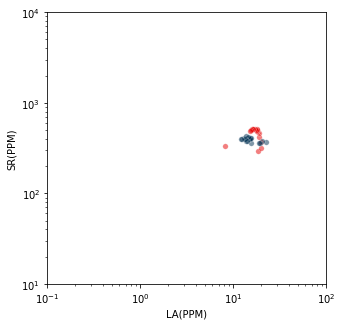

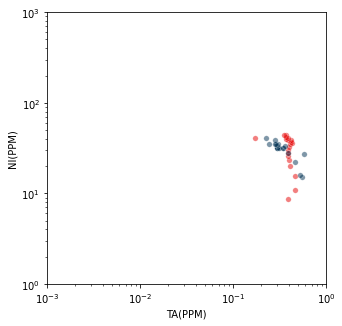

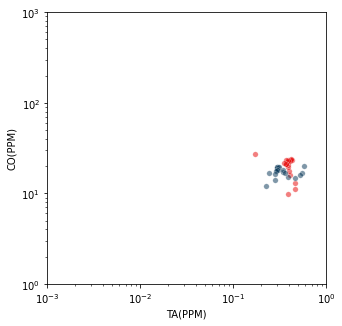

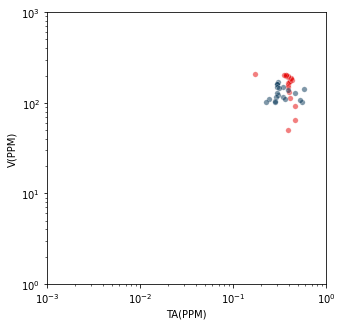

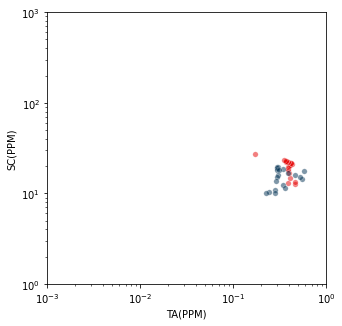

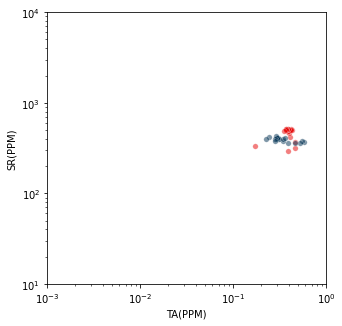

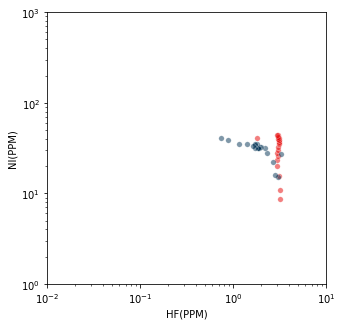

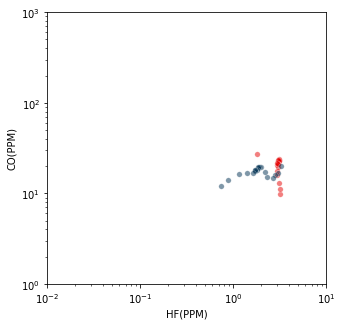

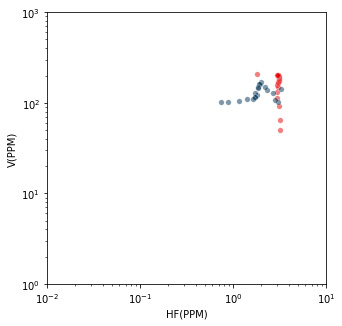

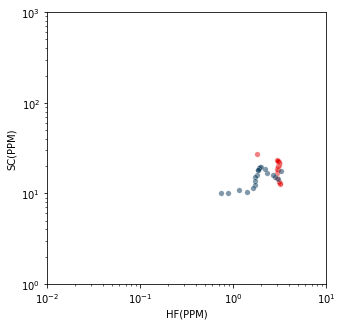

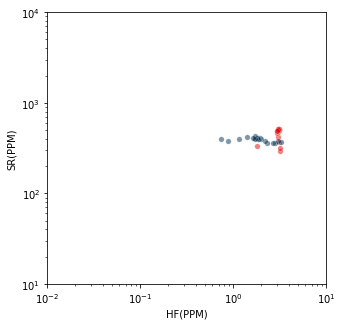

In [87]:
for i in ["U(PPM)", "RB(PPM)", "LA(PPM)", "TA(PPM)", "HF(PPM)"]:
    for c in ["NI(PPM)", "CO(PPM)", "V(PPM)", "SC(PPM)", "SR(PPM)"]:
        for d in [
            sim_mean,
        ]:  # for d in [data, sim_mean, simaverage]:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.set(xscale="log", yscale="log")
            ax = sns.scatterplot(
                x=d.loc[d["ROCK TYPE"] == "VOL", i],
                y=d.loc[d["ROCK TYPE"] == "VOL", c],
                color="#E60000",
                alpha=0.5,
                s=30,
            )
            ax = sns.scatterplot(
                x=d.loc[d["ROCK TYPE"] == "PLU", i],
                y=d.loc[d["ROCK TYPE"] == "PLU", c],
                color="#003153",
                alpha=0.5,
                s=30,
            )
            if i == "U(PPM)" or i == "HF(PPM)":
                plt.xlim([0.01, 10])
            elif i == "RB(PPM)":
                plt.xlim([1, 100])
            elif i == "LA(PPM)":
                plt.xlim([0.1, 100])
            elif i == "TA(PPM)":
                plt.xlim([0.001, 1])

            plt.ylim([1, 1000])
            if c == "SR(PPM)":
                plt.ylim([10, 10000])

            plt.show()

##### 试着通过相容元素和不相容元素的斜率差别鉴别部分熔融和分离结晶

In [88]:
# Primitive mantle
# pm = {'CS(PPM)': 0.032, 'TL(PPM)': 0.005, 'RB(PPM)': 0.635, 'BA(PPM)': 6.989, 'W(PPM)': 0.020, 'TH(PPM)':0.085, \
#       'U(PPM)': 0.021, 'NB(PPM)':0.713, 'TA(PPM)':0.041, 'K(PPM)': 250, 'LA(PPM)': 0.687, 'CE(PPM)': 1.775, \
#       'PB(PPM)': 0.185, 'PR(PPM)': 0.276, 'MO(PPM)': 0.063, 'SR(PPM)': 21.1, 'P(PPM)': 95, 'ND(PPM)': 1.354,\
#      'F(PPM)': 26, 'SM(PPM)': 0.444, 'ZR(PPM)': 11.2, 'HF(PPM)': 0.309, 'EU(PPM)':0.168, 'SN(PPM)': 0.170,\
#      'SB(PPM)': 0.005, 'TI(PPM)': 1300, 'GD(PPM)': 0.596, 'TB(PPM)': 0.108, 'DY(PPM)': 0.737, 'LI(PPM)': 1.60,\
#      'Y(PPM)': 4.55, 'HO(PPM)': 0.164, 'ER(PPM)': 0.480, 'TM(PPM)': 0.074, 'YB(PPM)': 0.493, 'LU(PPM)': 0.074}
# McDonough 2003
pm = {
    "CR(PPM)": 2625,
    "CO(PPM)": 105,
    "NI(PPM)": 1960,
    "V(PPM)": 82,
    "SR(PPM)": 20,
    "RB(PPM)": 0.6,
    "U(PPM)": 0.02,
    "TH(PPM)": 0.08,
    "TA(PPM)": 0.037,
    "NB(PPM)": 0.66,
    "BA(PPM)": 6.6,
}
# Klein 2003
nmorb = {
    "CR(PPM)": 250,
    "CO(PPM)": 50,
    "NI(PPM)": 120,
    "V(PPM)": 280,
    "SR(PPM)": 94,
    "RB(PPM)": 0.4,
    "U(PPM)": 0.03,
    "TH(PPM)": 0.09,
    "TA(PPM)": 0.1,
    "NB(PPM)": 1,
    "BA(PPM)": 6.1,
}
# Taylor, 2002
# oib = {'CR(PPM)': 450, 'CO(PPM)':50, 'NI(PPM)':120, 'V(PPM)':200, 'SR(PPM)':400, 'RB(PPM)':20, 'U(PPM)':0.7, 'TH(PPM)':2.7, 'TA(PPM)':np.nan, 'NB(PPM)':20, 'BA(PPM)':300}
oib = {
    "RB(PPM)": 20,
    "BA(PPM)": 300,
    "SR(PPM)": 400,
    "EU(PPM)": 1.8,
    "LA(PPM)": 19,
    "LU(PPM)": 0.3,
    "TH(PPM)": 2.7,
    "U(PPM)": 0.7,
    "ZR(PPM)": 150,
    "HF(PPM)": 4.0,
    "NB(PPM)": 20,
    "TA(PPM)": np.nan,
    "Y(PPM)": 23,
    "CE(PPM)": 43,
    "NI(PPM)": 120,
    "CO(PPM)": 50,
    "V(PPM)": 200,
    "CR(PPM)": 450,
    "SC(PPM)": 30,
    "SR(PPM)": 400,
}

In [89]:
# incomp_ele = ['RB(PPM)', 'U(PPM)', 'TH(PPM)', 'TA(PPM)', 'NB(PPM)', 'BA(PPM)']
# comp_ele = ['CR(PPM)', 'CO(PPM)', 'NI(PPM)', 'V(PPM)', 'SR(PPM)']
incomp_ele = [
    "RB(PPM)",
    "LA(PPM)",
    "TH(PPM)",
    "U(PPM)",
    "ZR(PPM)",
    "NB(PPM)",
]  # 'K(PPM)',
comp_ele = [
    "NI(PPM)",
    "CO(PPM)",
    "V(PPM)",
    "SC(PPM)",
    "SR(PPM)",
]  # 'FE(PPM)', 'MG(PPM)', 'MN(PPM)','CA(PPM)', 'AL(PPM)', 'TI(PPM)',

In [90]:
incomp_ele = ["RB(PPM)", "TH(PPM)", "U(PPM)"]  # 'K(PPM)',
comp_ele = ["NI(PPM)", "CO(PPM)", "V(PPM)", "SC(PPM)", "SR(PPM)"]

incomp_slope_v = []
incomp_r_v = []
comp_slope_v = []
comp_r_v = []
for e in incomp_ele:
    x = sim_mean[sim_mean["ROCK TYPE"] == "VOL"]["DEPTH"][2:35]
    y = sim_mean[sim_mean["ROCK TYPE"] == "VOL"][e][2:35] / oib[e]
    # 线性拟合，可以返回斜率，截距，r 值，p 值，标准误差
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    incomp_slope_v.append(slope)
    incomp_r_v.append(r_value)
for e in comp_ele:
    x = sim_mean[sim_mean["ROCK TYPE"] == "VOL"]["DEPTH"][2:35]
    y = sim_mean[sim_mean["ROCK TYPE"] == "VOL"][e][2:35] / oib[e]
    # 线性拟合，可以返回斜率，截距，r 值，p 值，标准误差
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    comp_slope_v.append(slope)
    comp_r_v.append(r_value)

ic(incomp_slope_v, comp_slope_v, incomp_r_v, comp_r_v)

ic| incomp_slope_v: [-0.043113789077708006, -0.03405991955442718, -0.021028098043157358]
    comp_slope_v: [0.007353094414528877,
                   0.0051333634441503165,
                   0.017403677390791572,
                   0.00979211128195288,
                   0.00933499619188614]
    incomp_r_v: [-0.8189691608192922, -0.9636460038246194, -0.9019260691198603]
    comp_r_v: [0.9589830629106145,
               0.7359391458322292,
               0.9193176389977171,
               0.9367571779209277,
               0.745669668118835]


([-0.043113789077708006, -0.03405991955442718, -0.021028098043157358],
 [0.007353094414528877,
  0.0051333634441503165,
  0.017403677390791572,
  0.00979211128195288,
  0.00933499619188614],
 [-0.8189691608192922, -0.9636460038246194, -0.9019260691198603],
 [0.9589830629106145,
  0.7359391458322292,
  0.9193176389977171,
  0.9367571779209277,
  0.745669668118835])

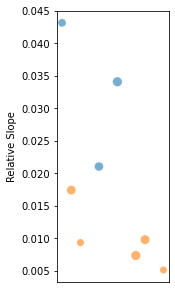

In [91]:
x1 = random.sample(range(1, 20), 3)
y1 = list(map(lambda x: abs(x), incomp_slope_v))
s1 = list(map(lambda x: abs(x), incomp_r_v))
txt1 = ["Rb", "La", "Th", "U"]

x2 = random.sample(range(1, 20), 5)
y2 = comp_slope_v
s2 = comp_r_v
txt2 = ["Ni", "Co", "V", "Sc", "Sr"]
fig, ax = plt.subplots(figsize=(2, 5))
ax = sns.scatterplot(x=x1, y=y1, s=[x ** 2 * 100 for x in s1], alpha=0.6)
ax = sns.scatterplot(x=x2, y=y2, s=[x ** 2 * 100 for x in s2], alpha=0.6)

ax = plt.xticks([])
ax = plt.ylabel("Relative Slope")
ax = plt.show()

In [92]:
incomp_ele = ["RB(PPM)", "ZR(PPM)", "NB(PPM)"]  # 'K(PPM)',
comp_ele = [
    "CO(PPM)",
]

incomp_slope_p = []
incomp_r_p = []
comp_slope_p = []
comp_r_p = []
for e in incomp_ele:
    x = sim_mean[sim_mean["ROCK TYPE"] == "PLU"]["DEPTH"][2:35]
    y = sim_mean[sim_mean["ROCK TYPE"] == "PLU"][e][2:35] / oib[e]
    # 线性拟合，可以返回斜率，截距，r 值，p 值，标准误差
    slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(x, y)
    incomp_slope_p.append(slope_p)
    incomp_r_p.append(r_value_p)
for e in comp_ele:
    x = sim_mean[sim_mean["ROCK TYPE"] == "PLU"]["DEPTH"][2:35]
    y = sim_mean[sim_mean["ROCK TYPE"] == "PLU"][e][2:35] / oib[e]
    # 线性拟合，可以返回斜率，截距，r 值，p 值，标准误差
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    comp_slope_p.append(slope)
    comp_r_p.append(r_value)

ic(incomp_slope_p, comp_slope_p, incomp_r_p, comp_r_p)

ic| incomp_slope_p: [-0.005536910595047786, -0.01434922355346376, -0.006973922955144735]
    comp_slope_p: [-0.0011374534009905902]
    incomp_r_p: [-0.18631680285440294, -0.9596580835489361, -0.9818576758930057]
    comp_r_p: [-0.2913362641687144]


([-0.005536910595047786, -0.01434922355346376, -0.006973922955144735],
 [-0.0011374534009905902],
 [-0.18631680285440294, -0.9596580835489361, -0.9818576758930057],
 [-0.2913362641687144])

##### 检验是否发生混合

In [93]:
ce_yb = sim_mean["CE(PPM)"] / sim_mean["YB(PPM)"]
eu_yb = sim_mean["EU(PPM)"] / sim_mean["YB(PPM)"]
rb_v = sim_mean["RB(PPM)"] / sim_mean["V(PPM)"]
v_r = 1 / sim_mean["V(PPM)"]

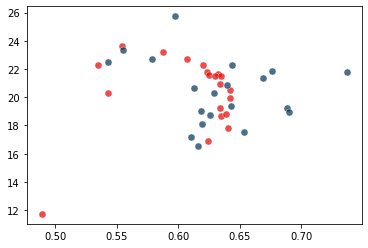

In [94]:
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=eu_yb.loc[sim_mean["ROCK TYPE"] == "VOL"],
    y=ce_yb.loc[sim_mean["ROCK TYPE"] == "VOL"],
    color="#E60000",
    alpha=0.7,
    s=50,
)
ax = sns.scatterplot(
    x=eu_yb.loc[sim_mean["ROCK TYPE"] == "PLU"],
    y=ce_yb.loc[sim_mean["ROCK TYPE"] == "PLU"],
    color="#003153",
    alpha=0.7,
    s=50,
)

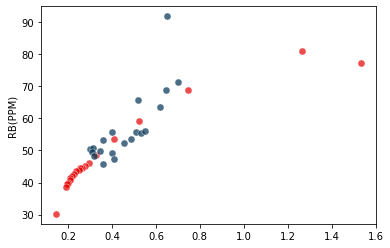

In [95]:
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=rb_v.loc[sim_mean["ROCK TYPE"] == "VOL"],
    y=sim_mean.loc[sim_mean["ROCK TYPE"] == "VOL", "RB(PPM)"],
    color="#E60000",
    alpha=0.7,
    s=50,
)
ax = sns.scatterplot(
    x=rb_v.loc[sim_mean["ROCK TYPE"] == "PLU"],
    y=sim_mean.loc[sim_mean["ROCK TYPE"] == "PLU", "RB(PPM)"],
    color="#003153",
    alpha=0.7,
    s=50,
)

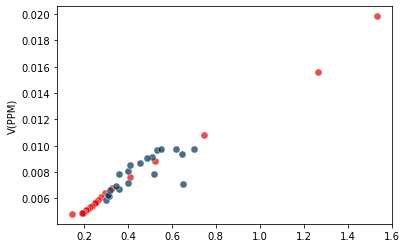

In [96]:
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=rb_v.loc[sim_mean["ROCK TYPE"] == "VOL"],
    y=v_r.loc[sim_mean["ROCK TYPE"] == "VOL"],
    color="#E60000",
    alpha=0.7,
    s=50,
)
ax = sns.scatterplot(
    x=rb_v.loc[sim_mean["ROCK TYPE"] == "PLU"],
    y=v_r.loc[sim_mean["ROCK TYPE"] == "PLU"],
    color="#003153",
    alpha=0.7,
    s=50,
)

虽然 1/V-Rb/V的图上看起来有点怪，但总体来看，不是混合。

##### 火山岩侵入岩的全球分布

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


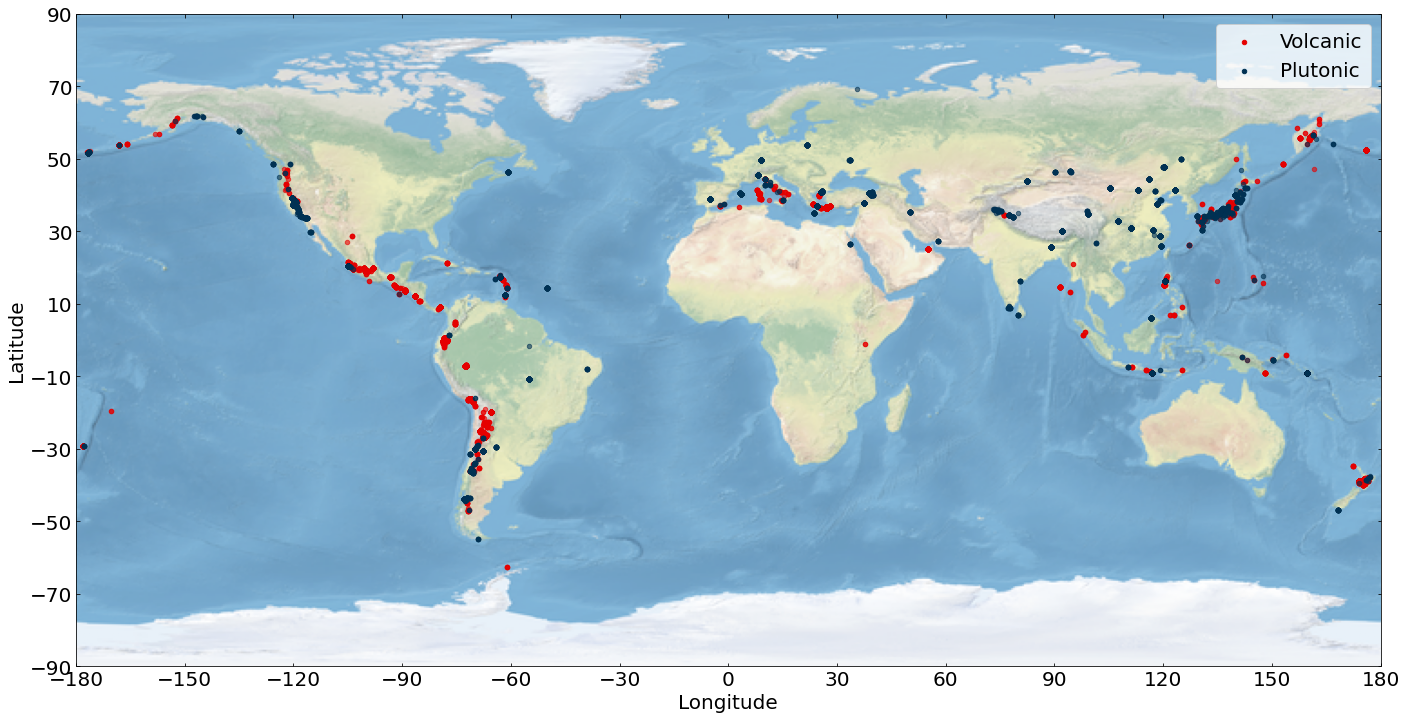

In [110]:
import cartopy.crs as ccrs

roc_typ = ["VOL", "PLU"]
color = colors
col_dict = dict(zip(roc_typ, color))

# 开始作图
fig = plt.figure(figsize=(24, 12))

# 画底图
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
# ax.coastlines()

# 投散点
for i in roc_typ:
    sub_df = data[data["ROCK TYPE"] == i]
    x = sub_df["LONGITUDE MIN"]
    y = sub_df["LATITUDE MIN"]
    c = col_dict[i]
    ax.scatter(x, y, c=c, s=20, alpha=0.6, label=i)

# 设置坐标格式
ax.set_xticks(range(-180, 181, 30))
ax.set_yticks(range(-90, 91, 20))
ax.tick_params(top=True, bottom=True, left=True, right=True, direction="in")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)

leg = plt.legend(fontsize=20, labels = ["Volcanic", "Plutonic"])
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.savefig('./figures/figures_geology/global.eps', format='eps')
plt.show()


# 看某些构造环境下岩浆岩随着深度的变化

In [97]:
# sum_df = pd.read_csv('vol_plu_bulk_with_depth.csv')
sum_df = vol_plu_bulk
sum_df.loc[
    sum_df["TECTONIC SETTING"] == "convergent margin", "TECTONIC SETTING"
] = "CONVERGENT MARGIN"

### 1. 准备

In [98]:
# simitemsin=['LATITUDE MIN', 'LONGITUDE MIN','MIN. AGE (YRS.)', 'MAX. AGE (YRS.)', 'SIO2(WT%)','FEOT(WT%)','MGO(WT%)','NI(PPM)','CAO(WT%)','AL2O3(WT%)','NA2O(WT%)','K2O(WT%)','TIO2(WT%)',\
#             'ZR(PPM)','HF(PPM)','YB(PPM)','RB(PPM)','BA(PPM)','SR(PPM)','EU(PPM)']
simitemsin = [
    "LATITUDE MIN",
    "LONGITUDE MIN",
    "MAX. AGE (YRS.)",
    "TECTONIC SETTING",
    "SIO2(WT%)",
    "TIO2(WT%)",
    "AL2O3(WT%)",
    "FEOT(WT%)",
    "MGO(WT%)",
    "CAO(WT%)",
    "MNO(WT%)",
    "NA2O(WT%)",
    "K2O(WT%)",
    "P2O5(WT%)",
    "CR(PPM)",
    "CO(PPM)",
    "NI(PPM)",
    "LA(PPM)",
    "CE(PPM)",
    "PR(PPM)",
    "ND(PPM)",
    "SM(PPM)",
    "EU(PPM)",
    "GD(PPM)",
    "TB(PPM)",
    "DY(PPM)",
    "HO(PPM)",
    "ER(PPM)",
    "TM(PPM)",
    "YB(PPM)",
    "LU(PPM)",
    "Y(PPM)",
    "SC(PPM)",
    "V(PPM)",
    "ZR(PPM)",
    "HF(PPM)",
    "RB(PPM)",
    "SR(PPM)",
    "BA(PPM)",
    "NB(PPM)",
    "TA(PPM)",
    "U(PPM)",
    "TH(PPM)",
    "Eu/Eu*",
    "DEPTH",
]  #'TECTONIC SETTING'
len(simitemsin)

45

In [99]:
# data = sum_df[(sum_df['SIO2(WT%)'] > SiO2min) & (sum_df['SIO2(WT%)'] < SiO2max)]
data = sum_df[~((sum_df["SIO2(WT%)"] < SiO2min) | (sum_df["SIO2(WT%)"] > SiO2max))]
data = data.dropna(subset=["LATITUDE MIN", "LONGITUDE MIN"])
# data = data.dropna(subset = ['LATITUDE MAX', 'LONGITUDE MAX'])
# 此外Keller还做了海拔不低于-100的限制

data = data[simitemsin]
data.reset_index(inplace=True, drop=True)  # 一定要重置，不然下面会出错
print(data.shape)

(29573, 45)


In [100]:
# remove outliers
def remove_outliers(cols):
    q1 = cols.quantile(0.25)
    q3 = cols.quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    cols.loc[(cols < fence_low) | (cols > fence_high)] = np.nan
    return cols


if exclude_outliers == "global":
    for c in data.columns[4:]:
        remove_outliers(data[c])

### 2. 反加权

In [101]:
def invweight(data, lat, lon):
    data["k"] = np.nan
    if data["k"].count() == lat.count():
        pass
    else:
        for i in range(len(lat)):
            data.loc[i, "k"] = np.nansum(
                1
                / (
                    (
                        180
                        / np.pi
                        * np.arccos(
                            np.sin(lat[i] * np.pi / 180) * np.sin(lat * np.pi / 180)
                            + np.cos(lat[i] * np.pi / 180)
                            * np.cos(lat * np.pi / 180)
                            * np.cos(lon[i] * np.pi / 180 - lon * np.pi / 180)
                        )
                    )
                    ** 2
                    + 1
                )
            )
            print("\r counting k value of line %d" % i, end="")

In [102]:
invweight(
    data, data["LATITUDE MIN"], data["LONGITUDE MIN"]
)  # this line will spend about 30 min

 counting k value of line 62

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


 counting k value of line 29572

上面这行用循环，还是太慢了，有时间改成map函数试试

In [103]:
prob = 1 / (data["k"] * ((5 / data["k"]).median()) + 1)

### 3.蒙特卡罗

In [104]:
# # Number of simulations
# nsims=1000

# ndata = len(simitemsin)

# nbins=60

# # binedges = np.linspace(agemin,agemax, num=(nbins + 1))
# binedges = np.linspace(dpmin,dpmax, num=(nbins + 1))

In [105]:
# mc:Monte Carlo
def mc(data, prob, binedges, nbins):  #  uncert,
    # 生成形状为 len(prob) ✖ 1 的随机数
    data["prob"] = prob
    data["r"] = np.random.rand(len(prob), 1)

    # Randomize elements
    ssdata = data[data["prob"] > data["r"]]
    ssdata.iloc[:, 4:-4] = ssdata.iloc[:, 4:-4] + ssdata.iloc[:, 4:-4] * (
        list(elerr.values())[:-1] * np.random.randn(len(elerr) - 1)
    )
    ssdata.loc[:, "DEPTH"] = ssdata.loc[:, "DEPTH"] + ssdata.loc[:, "DEPTH"] * elerr[
        "DEPTH"
    ] * np.random.randn(ssdata.loc[:, "DEPTH"].shape[0])
    # ssdata = sdata[simitemsin[2:]]
    # ssdata = ssdata + ssdata.values*(uncert.values*np.random.randn(uncert.shape[1]))

    # Randomize ages
    # ssdata['AGE'] = ssdata['AGE'] + ssdata['age_uncert']*np.random.randn(ssdata.shape[0])/2

    # # calculate average group by age bins，data structure is different from Keller.
    # ssdata['age_bins'] = pd.cut(ssdata['AGE'], binedges)
    # ssdata_ave = ssdata.groupby('age_bins').mean()
    # ssdata_ave.reset_index(inplace=True)
    ssdata["dp_bins"] = pd.cut(ssdata["DEPTH"], binedges)
    ssdata_ave = (
        ssdata.groupby(["TECTONIC SETTING", "dp_bins"])
    ).mean()  # ['TECTONIC SETTING','dp_bins']
    ssdata_num = (ssdata.groupby(["TECTONIC SETTING", "dp_bins"])).count()
    # ssdata_ave = (ssdata.groupby('dp_bins')).mean()
    ssdata_ave.reset_index(inplace=True)
    ssdata_num.reset_index(inplace=True)

    return ssdata_ave, ssdata_num
    # done

In [106]:
%%capture --no-stdout
%%time
simaverage_dict = []
simnum_dict = []
for i in range(nsims):
    avg, num = mc(data, prob, binedges, nbins)
    simaverage_dict.append(avg)
    simnum_dict.append(num)
    print("\r" + str(i), end="")

simaverage = pd.concat(simaverage_dict, keys=list(range(nsims)))
simnum = pd.concat(simnum_dict, keys=list(range(nsims)))

999CPU times: user 21.2 s, sys: 189 ms, total: 21.4 s
Wall time: 21.2 s


### 作图

In [107]:
# simaverage.groupby('ROCK TYPE').count()

In [108]:
# 为画图设置颜色和构造背景
# tec 是分类方式
tec = "TECTONIC SETTING"
# tec = 'ROCK TYPE'
clrs = ["73192A"]  # mixing of 故宫红 and 中国蓝
# clrs = ['008eaa', '0077c8', 'ffc168', 'ff6c5f', 'ff4f81',
#         'b84592', '8e43e7', '3369e7', '00aeff', '003666', '050f2c']
clrs = list(map(lambda a: "#" + a, clrs))
# tect_set = list(set(simaverage[tec]))
# tect_set = ['CONVERGENT MARGIN', 'INTRAPLATE VOLCANICS', 'OCEAN ISLAND', 'RIFT VOLCANICS']
tect_set = ["CONVERGENT MARGIN"]
# tect_set = ['VOL', 'PLU']

In [109]:
sim_mean = simaverage.groupby([tec, "dp_bins"]).mean()
sim_mean.reset_index(inplace=True)
# sim_mean = sim_mean[simitemsin[5:]]

sim_std = simaverage.groupby([tec, "dp_bins"]).std()
sim_std.reset_index(inplace=True)
# sim_std = sim_std[simitemsin[5:]]

sim_num = simnum.groupby([tec, "dp_bins"]).mean()
sim_num.reset_index(inplace=True)
# sim_num = sim_num[simitemsin[5:]]

# sim_stat = simaverage.groupby(['TECTONIC SETTING', 'si_bins']).agg(['mean', 'std', 'count'])

sim_err = sim_mean.copy()
sim_err[simitemsin[4:]] = (
    1.96 * sim_std[simitemsin[4:]] / sim_num[simitemsin[4:]].apply(np.sqrt)
)

SIO2(WT%)
 # of tectonic setting: 1 

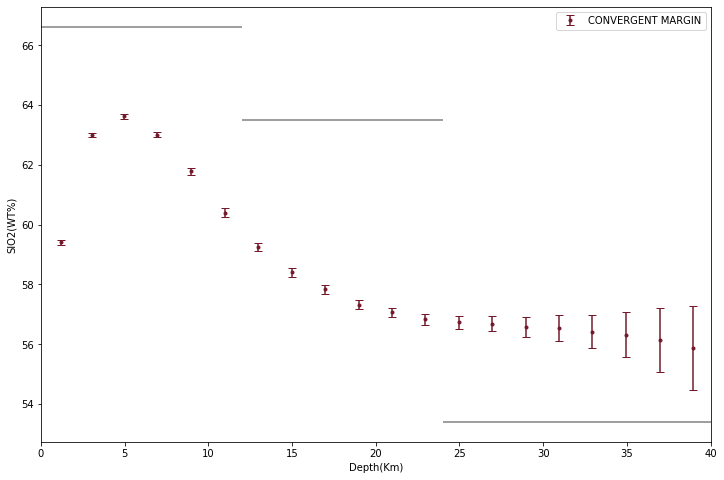

TIO2(WT%)
 # of tectonic setting: 1 

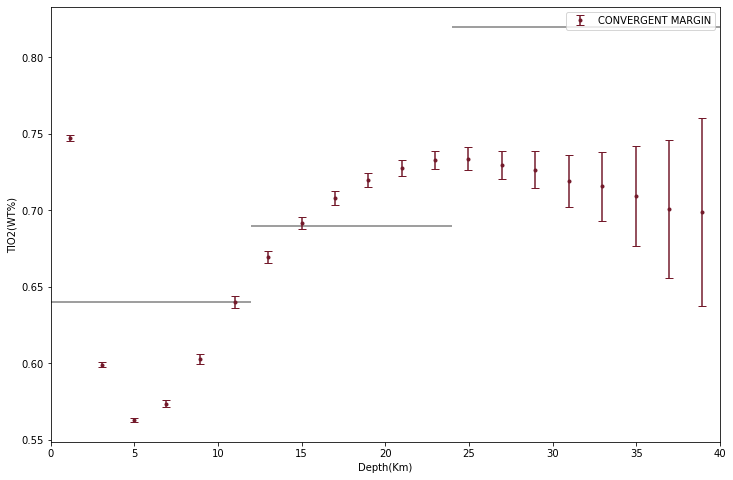

AL2O3(WT%)
 # of tectonic setting: 1 

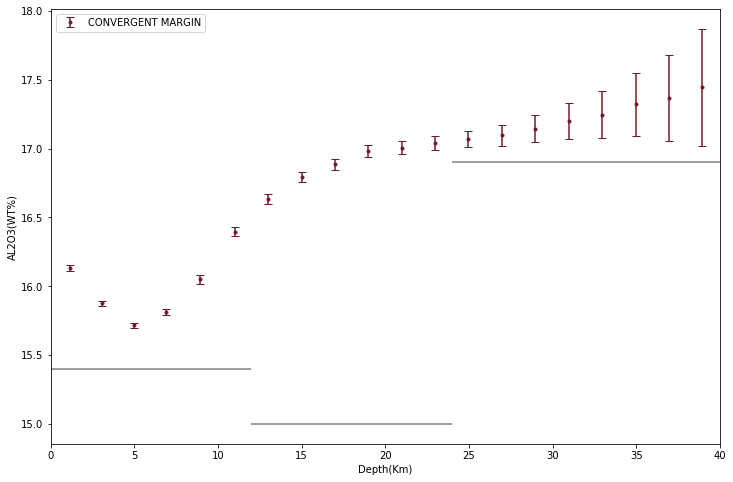

FEOT(WT%)
 # of tectonic setting: 1 

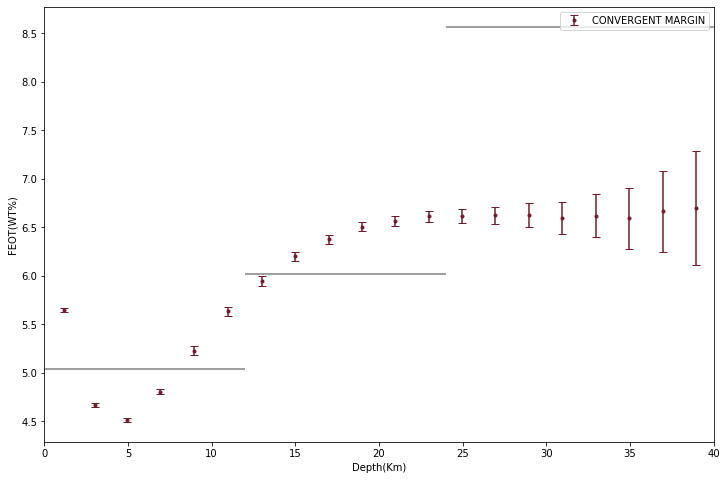

MGO(WT%)
 # of tectonic setting: 1 

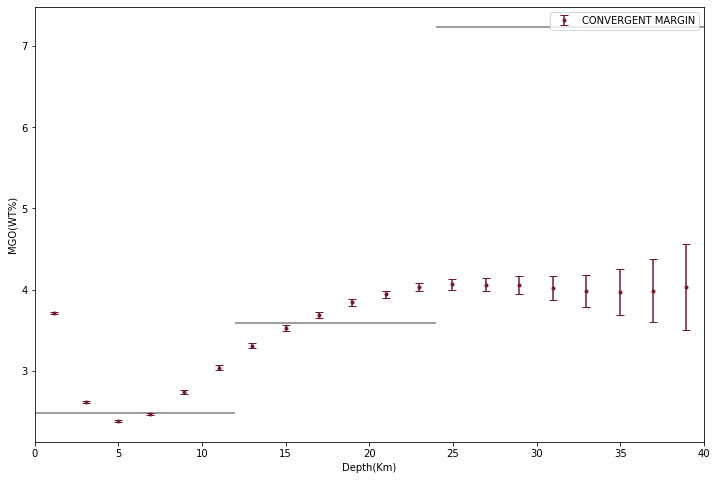

CAO(WT%)
 # of tectonic setting: 1 

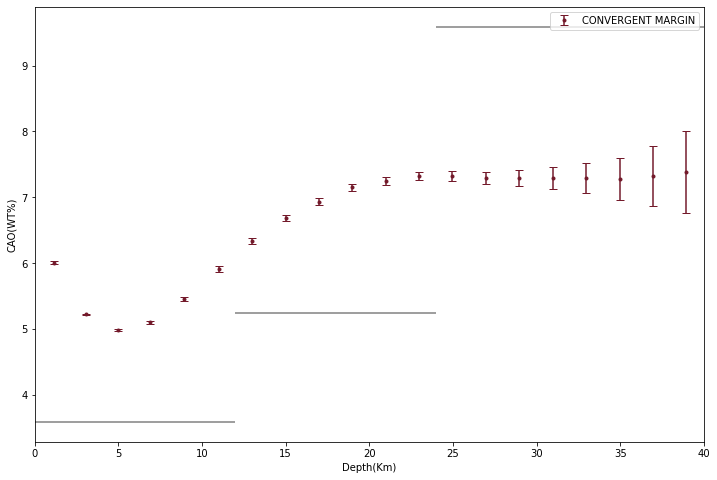

MNO(WT%)
 # of tectonic setting: 1 

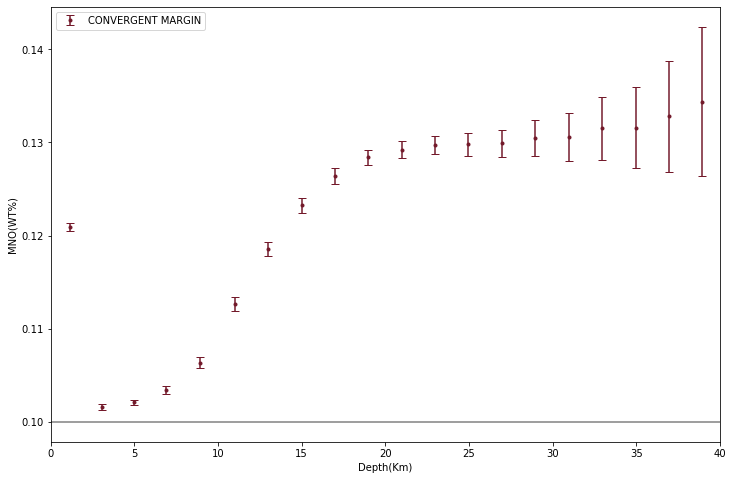

NA2O(WT%)
 # of tectonic setting: 1 

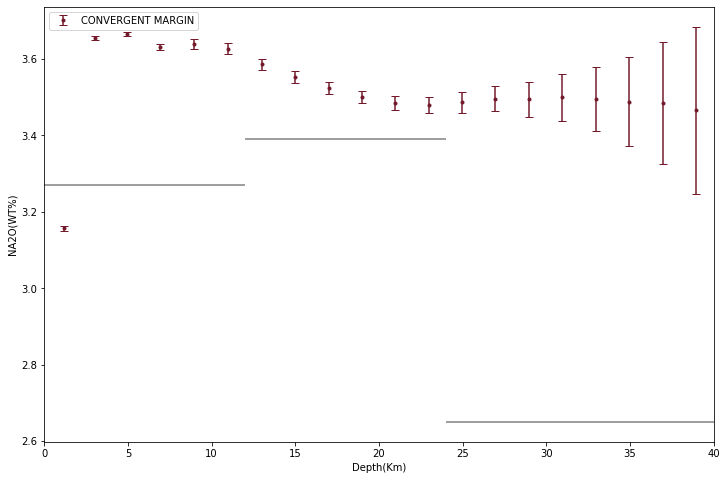

K2O(WT%)
 # of tectonic setting: 1 

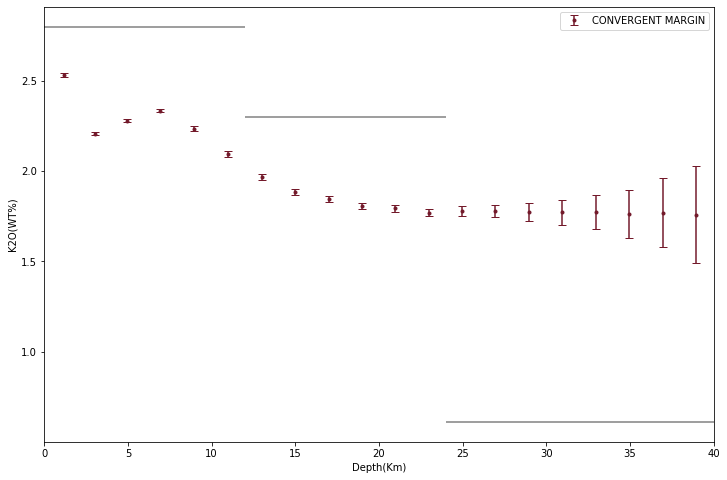

P2O5(WT%)
 # of tectonic setting: 1 

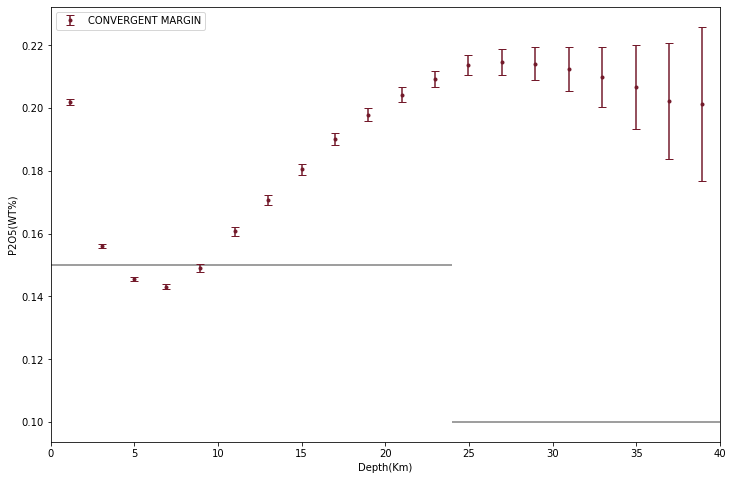

CR(PPM)
 # of tectonic setting: 1 

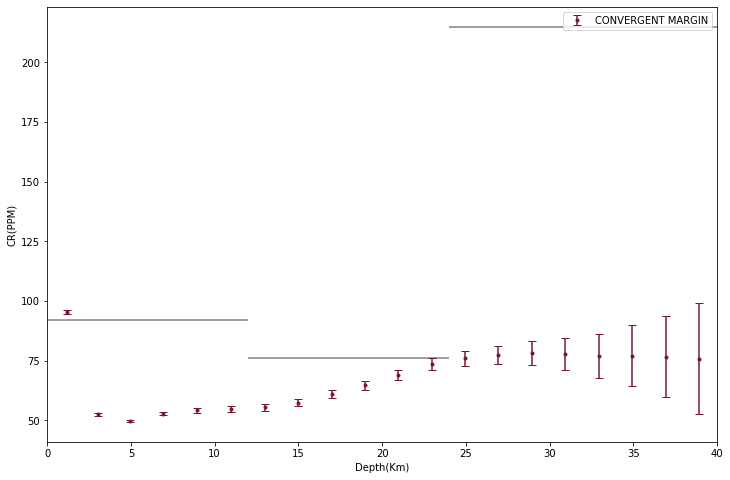

CO(PPM)
 # of tectonic setting: 1 

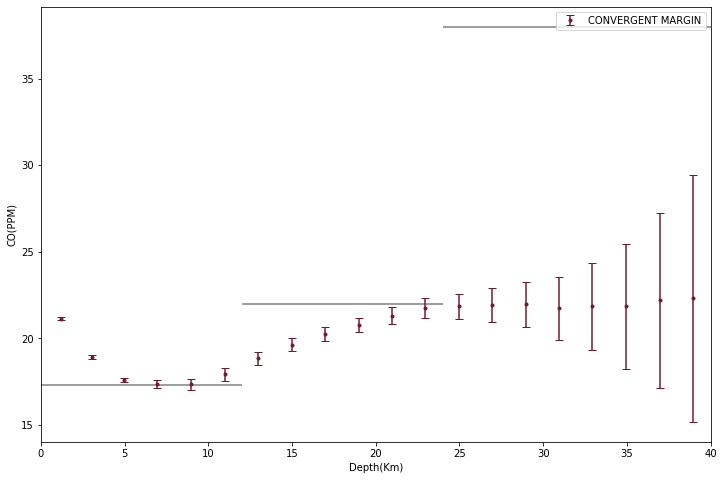

NI(PPM)
 # of tectonic setting: 1 

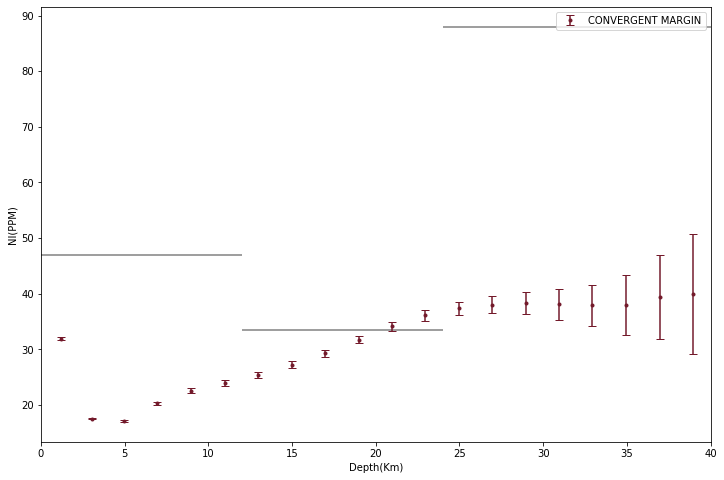

LA(PPM)
 # of tectonic setting: 1 

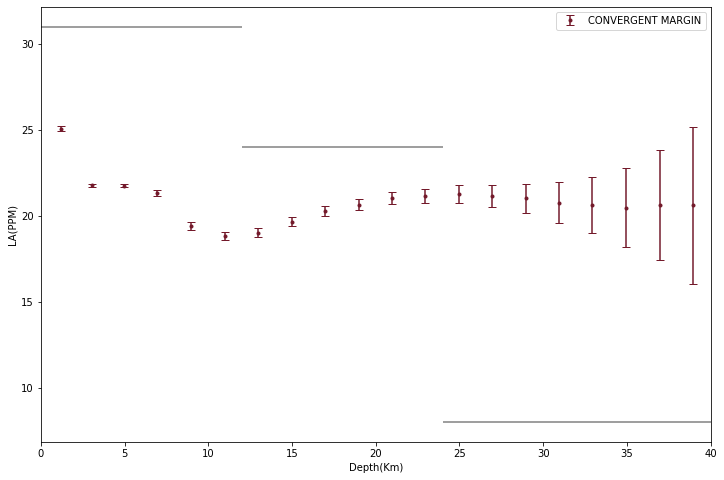

CE(PPM)
 # of tectonic setting: 1 

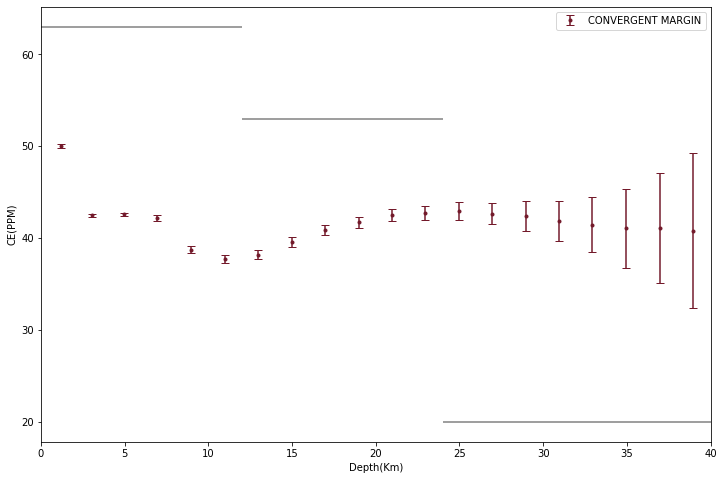

PR(PPM)
 # of tectonic setting: 1 

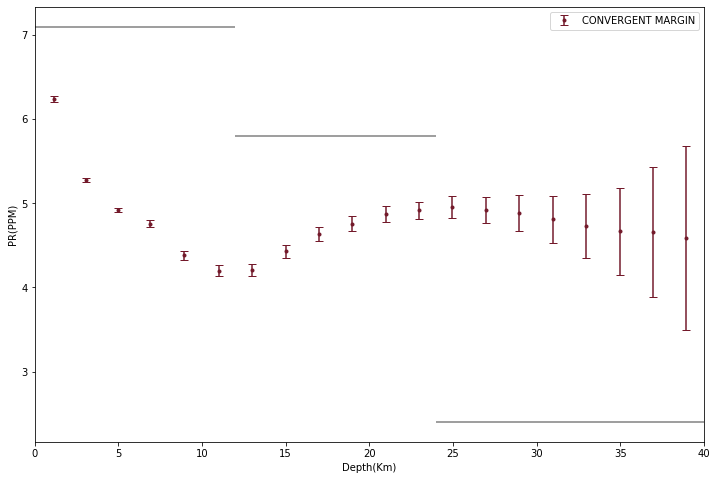

ND(PPM)
 # of tectonic setting: 1 

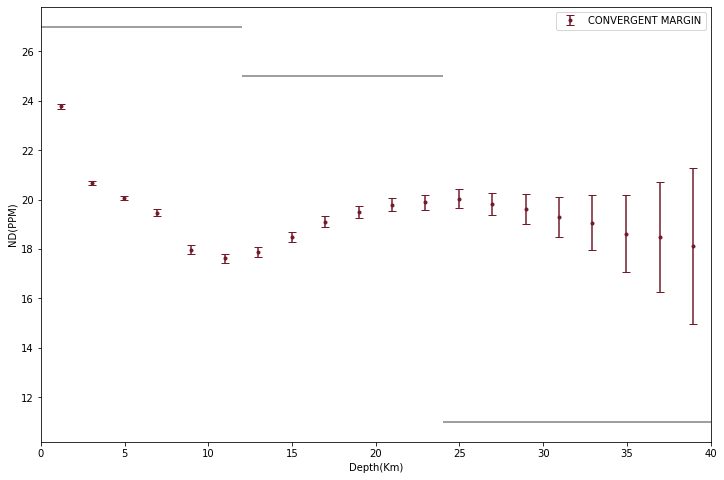

SM(PPM)
 # of tectonic setting: 1 

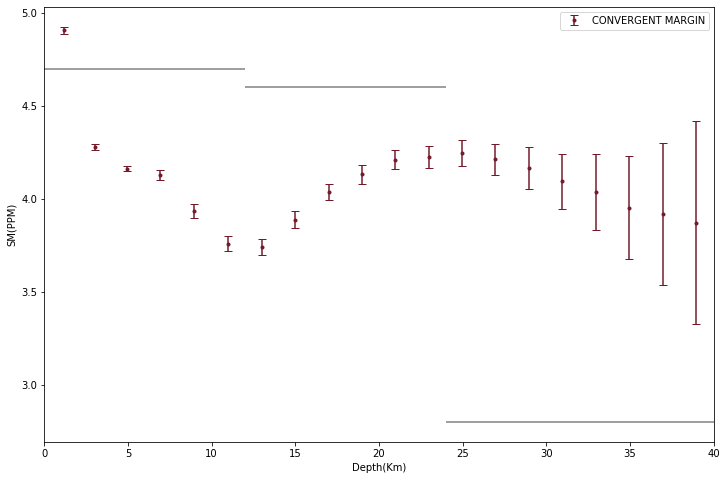

EU(PPM)
 # of tectonic setting: 1 

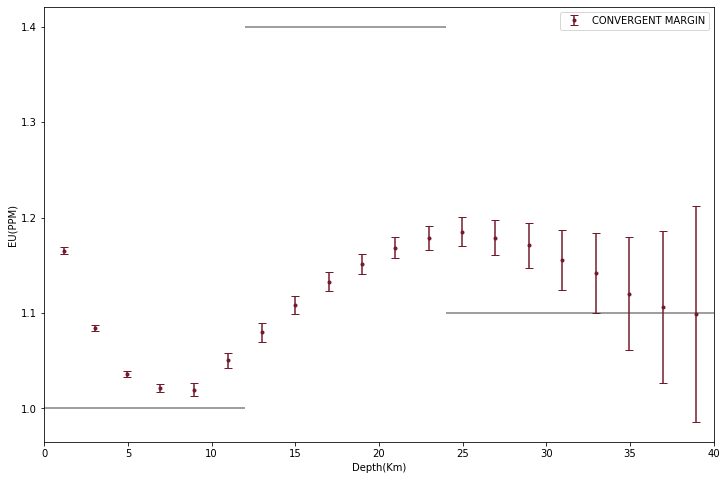

GD(PPM)
 # of tectonic setting: 1 

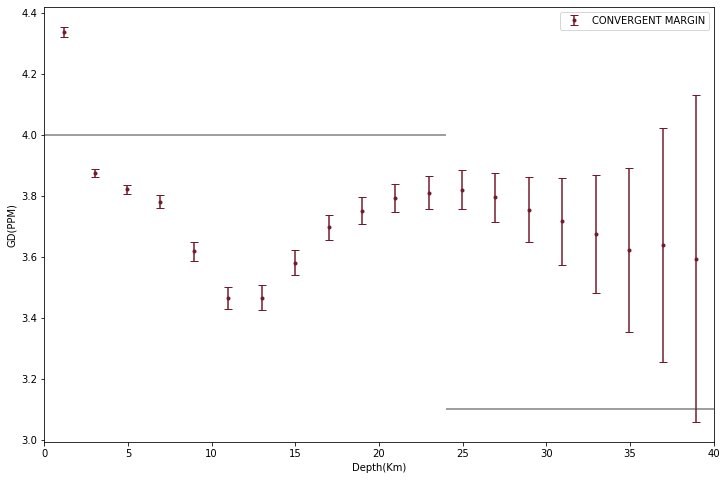

TB(PPM)
 # of tectonic setting: 1 

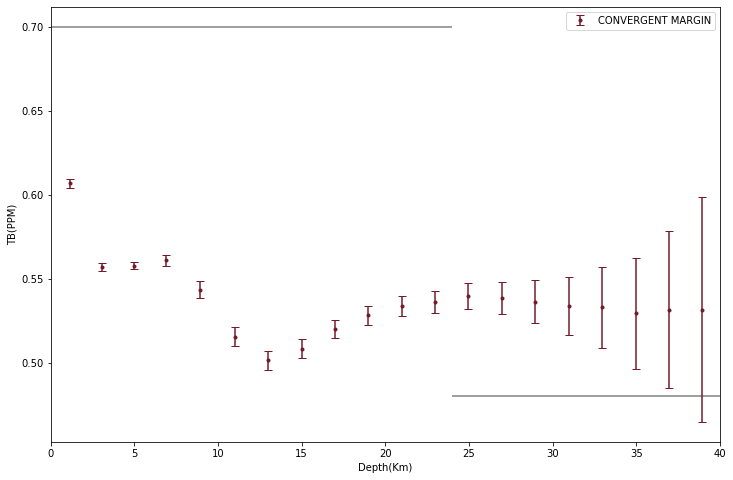

DY(PPM)
 # of tectonic setting: 1 

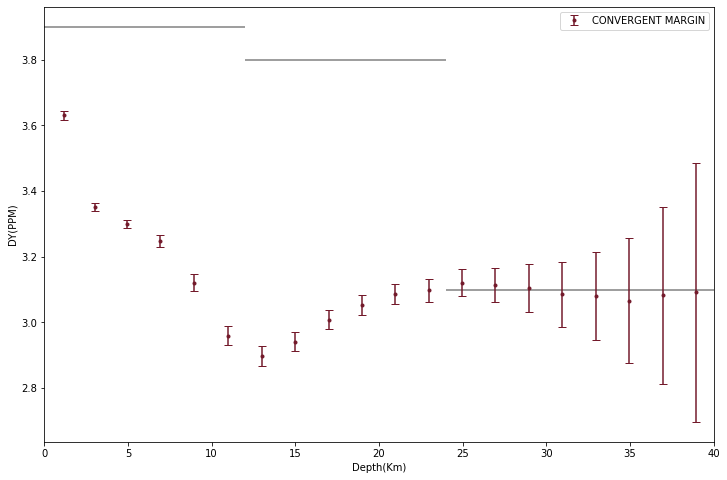

HO(PPM)
 # of tectonic setting: 1 

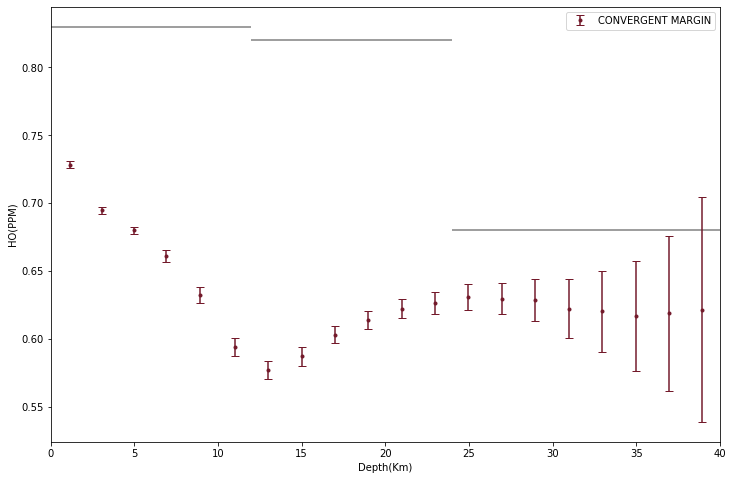

ER(PPM)
 # of tectonic setting: 1 

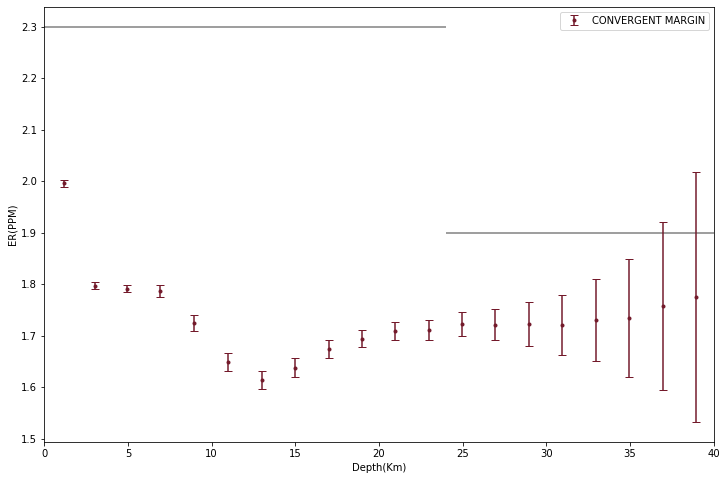

TM(PPM)
 # of tectonic setting: 1 

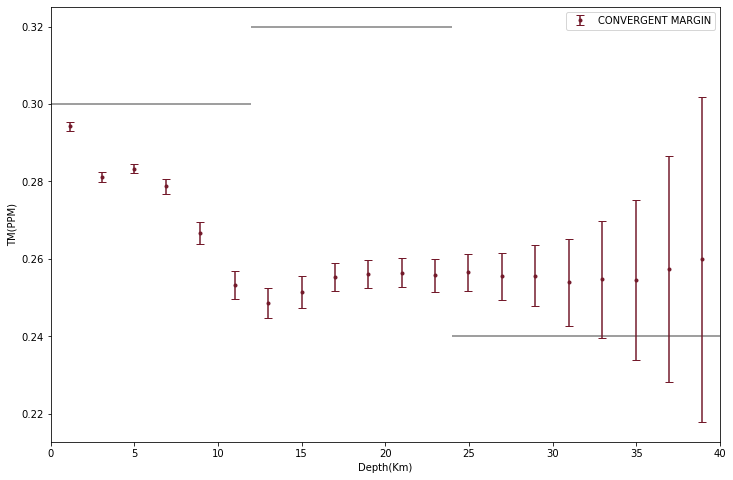

YB(PPM)
 # of tectonic setting: 1 

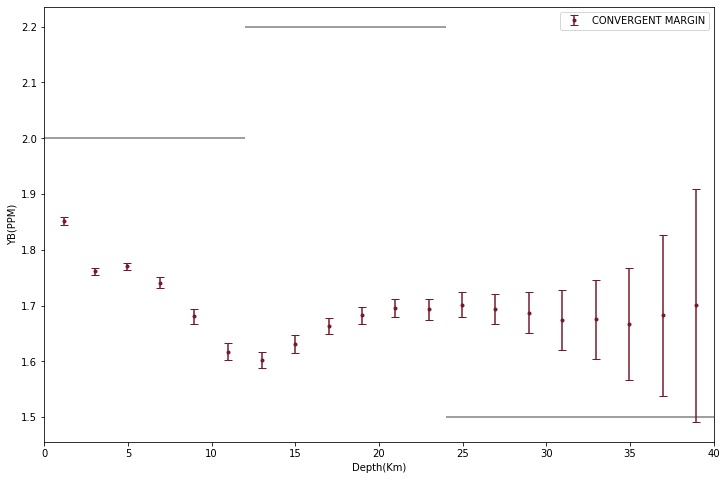

LU(PPM)
 # of tectonic setting: 1 

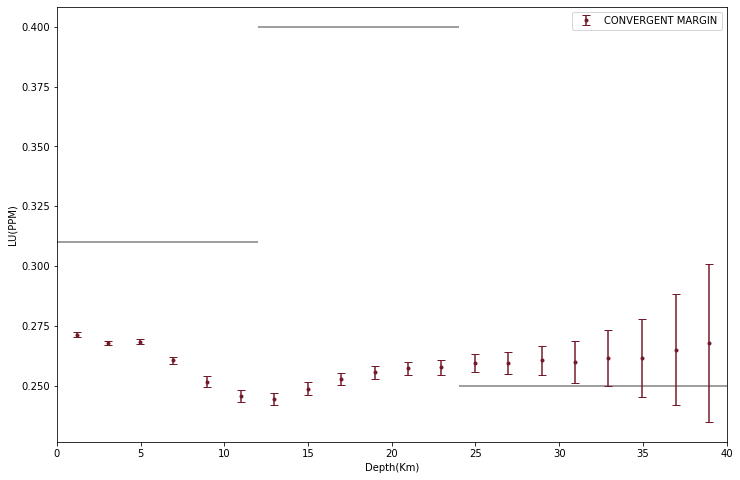

Y(PPM)
 # of tectonic setting: 1 

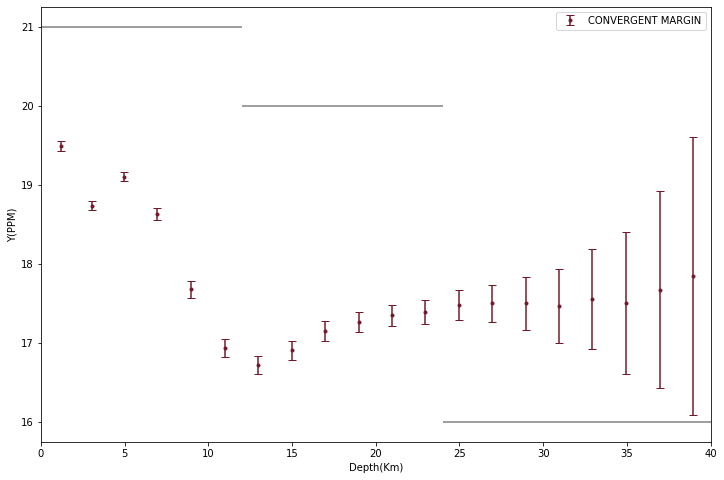

SC(PPM)
 # of tectonic setting: 1 

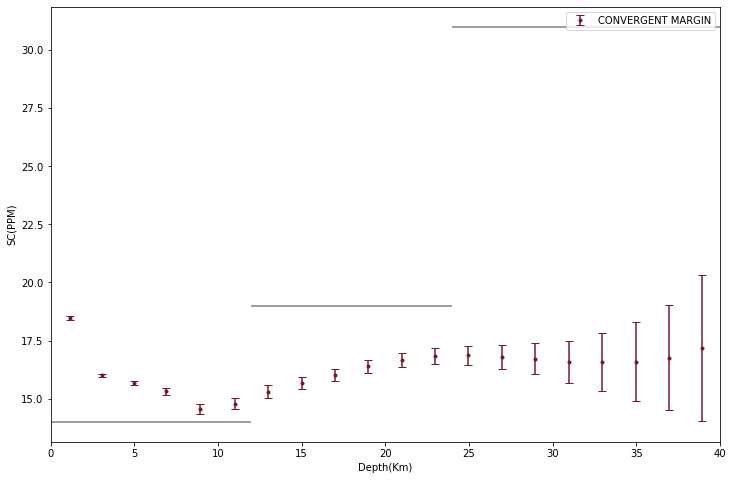

V(PPM)
 # of tectonic setting: 1 

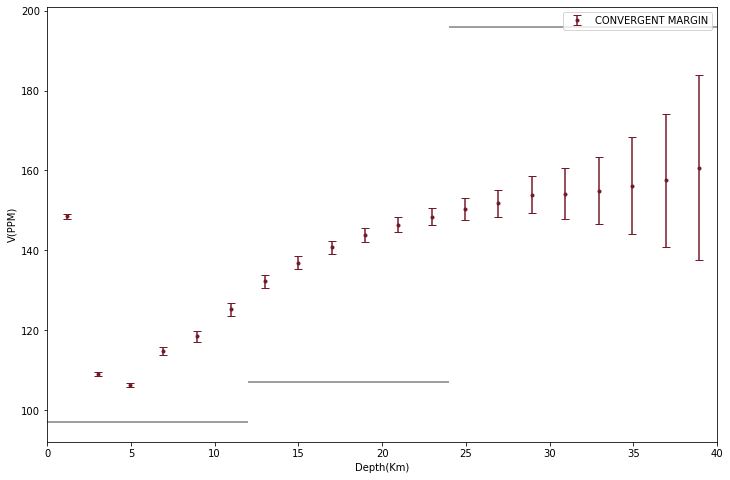

ZR(PPM)
 # of tectonic setting: 1 

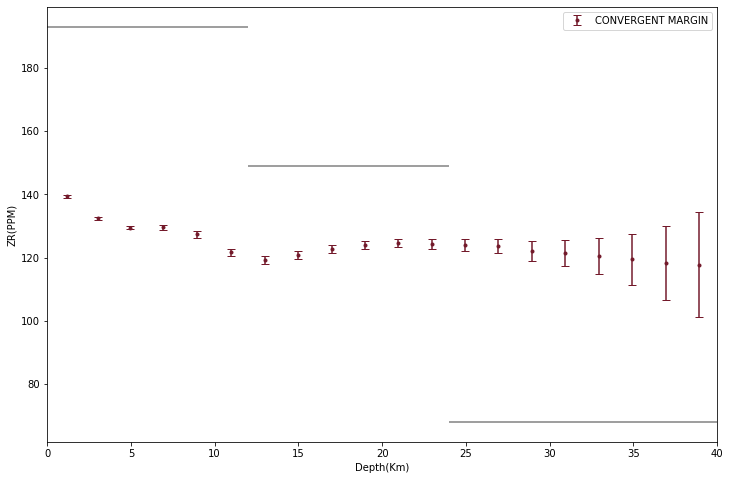

HF(PPM)
 # of tectonic setting: 1 

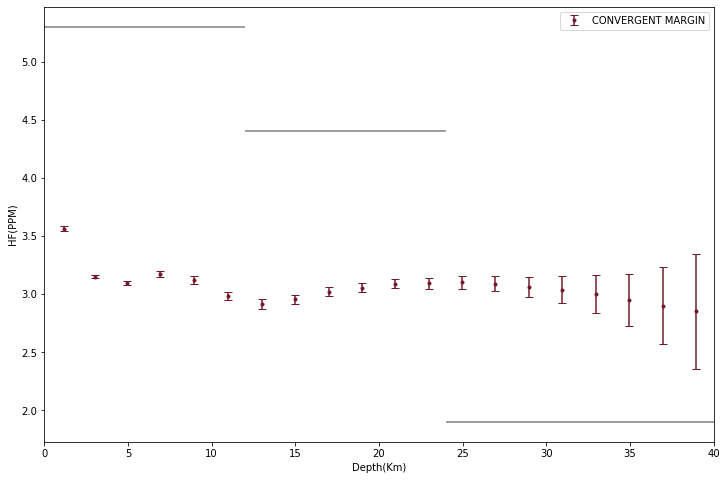

RB(PPM)
 # of tectonic setting: 1 

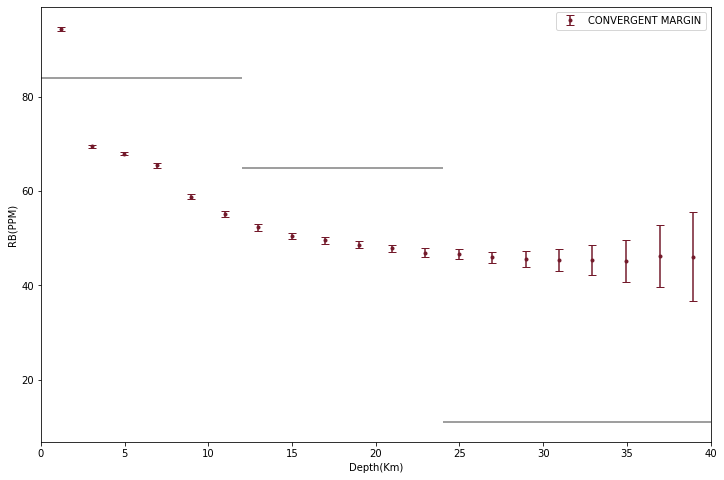

SR(PPM)
 # of tectonic setting: 1 

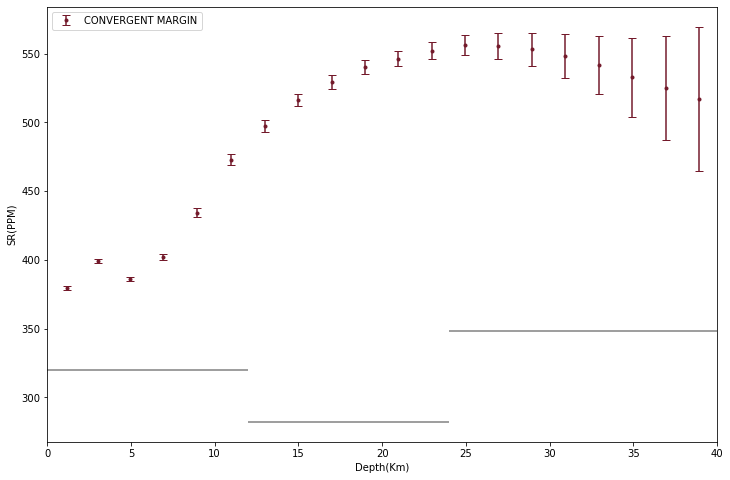

BA(PPM)
 # of tectonic setting: 1 

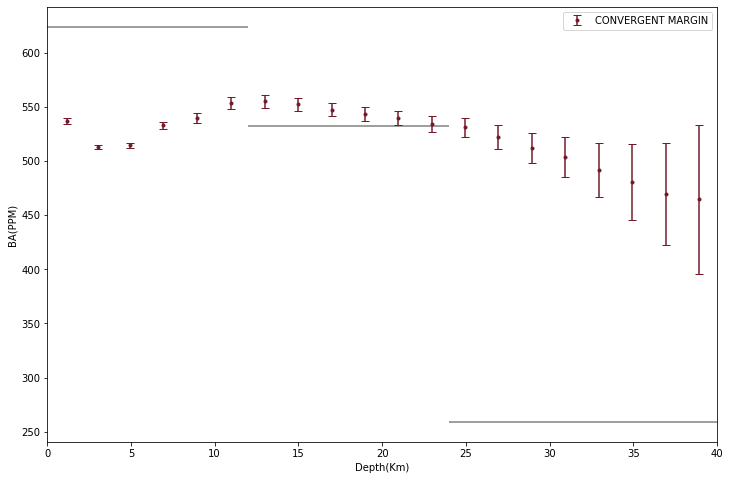

NB(PPM)
 # of tectonic setting: 1 

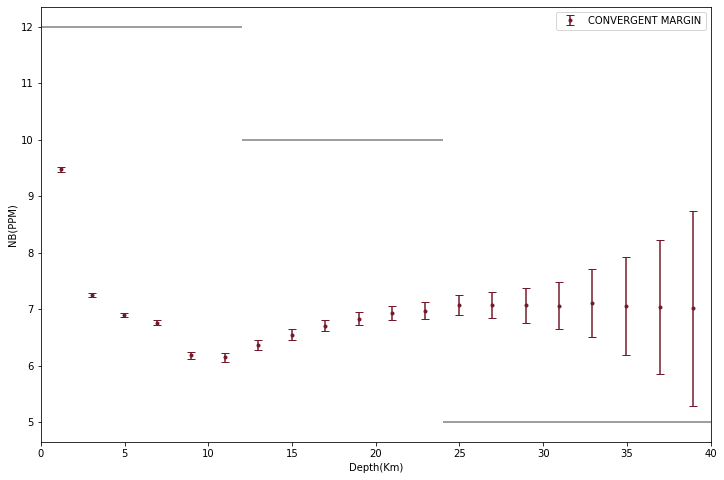

TA(PPM)
 # of tectonic setting: 1 

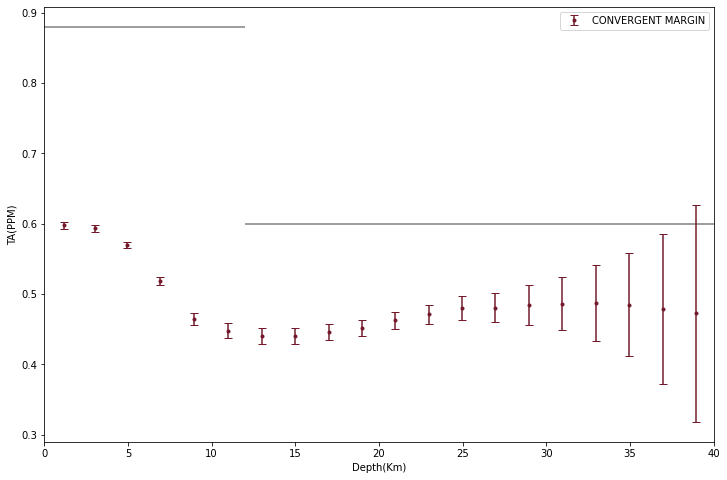

U(PPM)
 # of tectonic setting: 1 

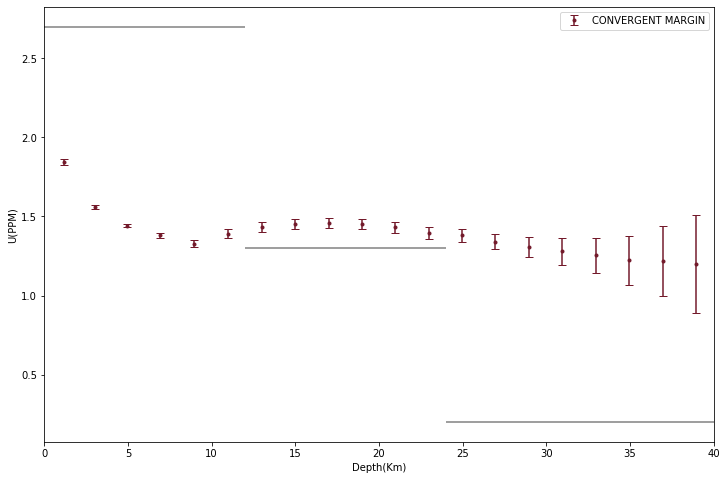

TH(PPM)
 # of tectonic setting: 1 

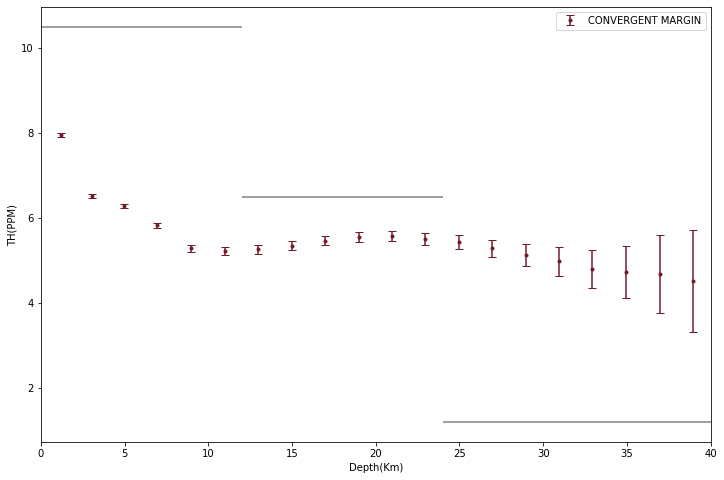

Eu/Eu*
 # of tectonic setting: 1 

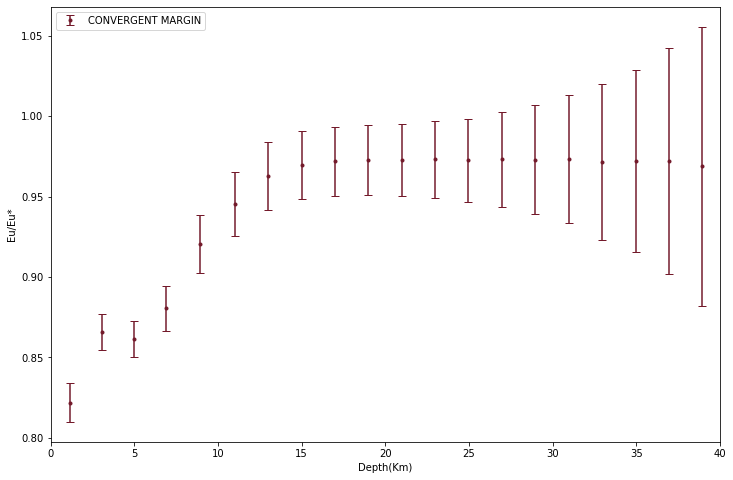

DEPTH
 # of tectonic setting: 1 

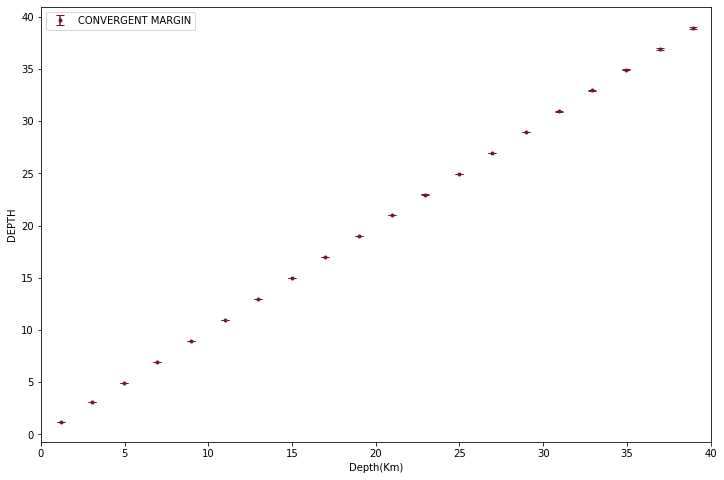

CPU times: user 4.28 s, sys: 113 ms, total: 4.39 s
Wall time: 4.29 s


In [110]:
%%time
# 根据构造背景分类的barplot

for i in simitemsin[4:]:
    print(i)
    fig, ax1 = plt.subplots(figsize=(12, 8))
    if i in cc_avg.keys():
        ax1.hlines(cc_avg[i][0], 0, uc_bt, colors="gray")
        ax1.hlines(cc_avg[i][1], uc_bt, mc_bt, colors="gray")
        ax1.hlines(cc_avg[i][2], mc_bt, lc_bt, colors="gray")
    for j in range(len(tect_set)):
        clr = clrs[j]
        ax1.errorbar(
            x=sim_mean[sim_mean[tec] == tect_set[j]]["DEPTH"],
            y=sim_mean[sim_mean[tec] == tect_set[j]][i],
            yerr=sim_err[sim_err[tec] == tect_set[j]][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )  # , color = clr
        #         ax1.plot(sim_mean[sim_mean[tec] == tect_set[j]]['DEPTH'], sim_mean[sim_mean[tec] == tect_set[j]][i], color = clr)
        # plt.xlim(0, 40)
        plt.xlim(dpmin, dpmax)
        print("\r # of tectonic setting: %d" % (j + 1), end=" ")
    plt.xlabel("Depth(Km)")
    plt.ylabel(i)

    ax1.legend()
    # file_name = 'figures/errbar/' + 'CONVERGENT_MARGIN' + i[:-5] + '_' + 'depth_withCC' + '.tiff'
    # file_name = 'figures/errbar/' + tec + i[:-5] + '_' + 'SiO2' + '.pdf'
    # plt.rcParams['savefig.dpi'] = 300
    # plt.savefig(file_name)
    plt.show()

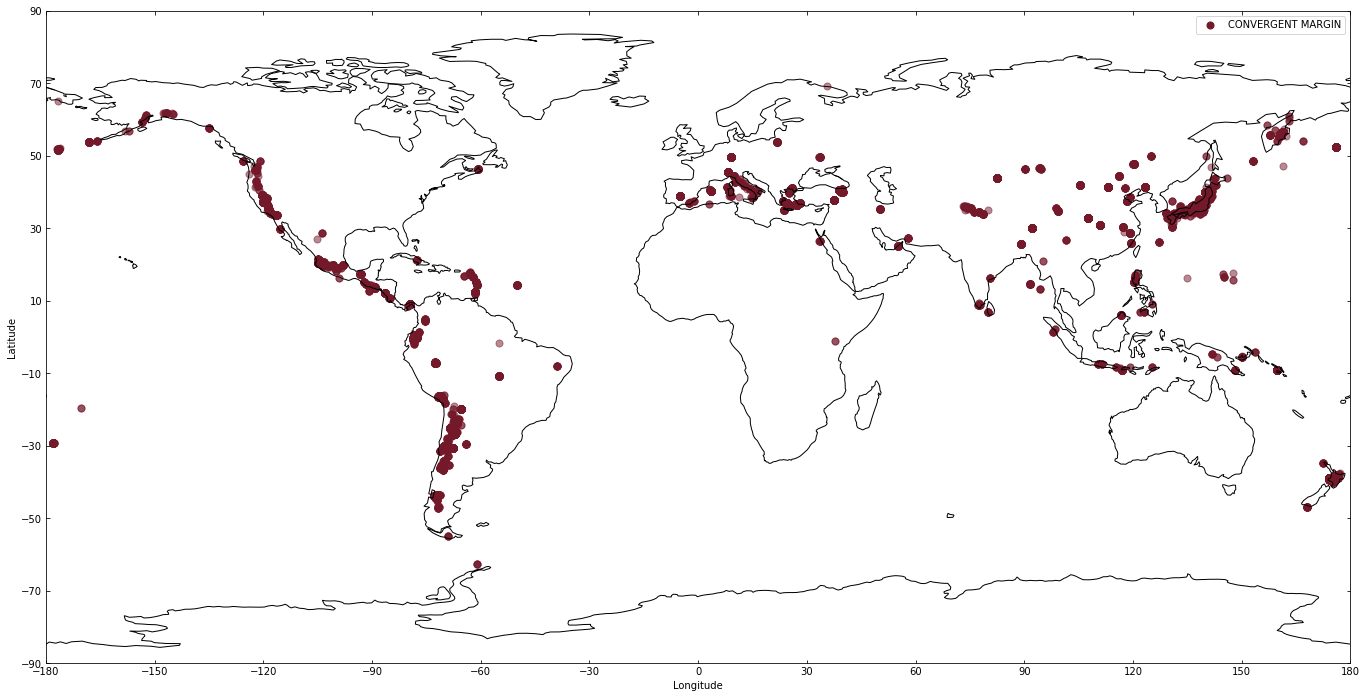

In [111]:
import cartopy.crs as ccrs

roc_typ = [
    "CONVERGENT MARGIN",
]
color = ["#73192A"]  # ['tab:blue',]
col_dict = dict(zip(roc_typ, color))

# 开始作图
fig = plt.figure(figsize=(24, 12))

# 画底图
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines()

# 投散点
for i in roc_typ:
    sub_df = data[data["TECTONIC SETTING"] == i]
    x = sub_df["LONGITUDE MIN"]
    y = sub_df["LATITUDE MIN"]
    c = col_dict[i]
    ax.scatter(x, y, c=c, s=50, alpha=0.5, label=i)

# 设置坐标格式
ax.set_xticks(range(-180, 181, 30))
ax.set_yticks(range(-90, 91, 20))
ax.tick_params(top=True, bottom=True, left=True, right=True, direction="in")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Longitude", fontsize=10)
plt.ylabel("Latitude", fontsize=10)

leg = plt.legend(fontsize=10,)  # 让图例不透明
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.show()

# 看某些构造环境下侵入岩和火山岩在不同硅含量上的区别

## 反加权重采样和蒙特卡洛

In [112]:
vol_plu_bulk.groupby("TECTONIC SETTING").count()

UNIQUE_ID  LATITUDE MIN  \
TECTONIC SETTING                                                       
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)        929           929   
COMPLEX VOLCANIC SETTINGS                           40            40   
CONTINENTAL FLOOD BASALT                           519           519   
CONVERGENT MARGIN                                17860         17859   
INTRAPLATE VOLCANICS                              8509          8509   
OCEAN ISLAND                                      1611          1611   
OCEANIC PLATEAU                                     28            28   
RIFT VOLCANICS                                     535           535   
SEAMOUNT                                           308           308   
SUBMARINE RIDGE                                      9             9   

                                             LONGITUDE MIN  MAX. AGE (YRS.)  \
TECTONIC SETTING                                                              
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)            929              110   
COMPLEX VOLCANIC SETTINGS                               40               14   
CONTINENTAL FLOOD BASALT                               519               36   
CONVERGENT MARGIN                                    17859             7779   
INTRAPLATE VOLCANICS                                  8509              337   
OCEAN ISLAND                                          1611               46   
OCEANIC PLATEAU                                         28                0   
RIFT VOLCANICS                                         535               99   
SEAMOUNT                                               308                0   
SUBMARINE RIDGE                                          9                0   

                                             ROCK TYPE  SIO2(WT%)  TIO2(WT%)  \
TECTONIC SETTING                                                               
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)        929        929        929   
COMPLEX VOLCANIC SETTINGS                           40         40         40   
CONTINENTAL FLOOD BASALT                           519        491        491   
CONVERGENT MARGIN                                17860      17468      16638   
INTRAPLATE VOLCANICS                              8509       8383       8361   
OCEAN ISLAND                                      1611       1611       1611   
OCEANIC PLATEAU                                     28         28         28   
RIFT VOLCANICS                                     535        531        531   
SEAMOUNT                                           308        308        308   
SUBMARINE RIDGE                                      9          0          0   

                                             AL2O3(WT%)  FEOT(WT%)  MGO(WT%)  \
TECTONIC SETTING                                                               
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)         929        887       929   
COMPLEX VOLCANIC SETTINGS                            40          6        40   
CONTINENTAL FLOOD BASALT                            491        414       491   
CONVERGENT MARGIN                                 16614      10790     16613   
INTRAPLATE VOLCANICS                               8381       7780      8380   
OCEAN ISLAND                                       1611       1493      1611   
OCEANIC PLATEAU                                      28         27        28   
RIFT VOLCANICS                                      531        475       531   
SEAMOUNT                                            308        299       308   
SUBMARINE RIDGE                                       0          0         0   

                                             ...  (La/Yb)N   Sr/Y  Rb/Sr  \
TECTONIC SETTING                             ...                           
ARCHEAN CRATON (INCLUDING GREENSTONE BELTS)  ...       900    882    882   
COMPLEX VOLCANIC SETTINGS                    ...        15     29     35   
CONTI

In [113]:
# sum_df = pd.read_csv('vol_plu_bulk_with_depth.csv')
sum_df = vol_plu_bulk
sum_df.loc[
    sum_df["TECTONIC SETTING"] == "convergent margin", "TECTONIC SETTING"
] = "CONVERGENT MARGIN"

In [114]:
# 选择构造背景
sum_df = sum_df[sum_df["TECTONIC SETTING"] == "CONVERGENT MARGIN"]
# sum_df = sum_df[sum_df['TECTONIC SETTING'] == 'INTRAPLATE VOLCANICS']

### 1. 准备

In [115]:
# Range of silica values to examine （Keller）
# SiO2min = 40 # 岩石学书上是45
SiO2min = 40  # 取中酸性岩
SiO2max = 80

In [116]:
# simitemsin=['LATITUDE MIN', 'LONGITUDE MIN','MIN. AGE (YRS.)', 'MAX. AGE (YRS.)', 'SIO2(WT%)','FEOT(WT%)','MGO(WT%)','NI(PPM)','CAO(WT%)','AL2O3(WT%)','NA2O(WT%)','K2O(WT%)','TIO2(WT%)',\
#             'ZR(PPM)','HF(PPM)','YB(PPM)','RB(PPM)','BA(PPM)','SR(PPM)','EU(PPM)']
simitemsin = [
    "LATITUDE MIN",
    "LONGITUDE MIN",
    "MAX. AGE (YRS.)",
    "ROCK TYPE",
    "SIO2(WT%)",
    "TIO2(WT%)",
    "AL2O3(WT%)",
    "FEOT(WT%)",
    "MGO(WT%)",
    "CAO(WT%)",
    "MNO(WT%)",
    "NA2O(WT%)",
    "K2O(WT%)",
    "P2O5(WT%)",
    "CR(PPM)",
    "CO(PPM)",
    "NI(PPM)",
    "LA(PPM)",
    "CE(PPM)",
    "PR(PPM)",
    "ND(PPM)",
    "SM(PPM)",
    "EU(PPM)",
    "GD(PPM)",
    "TB(PPM)",
    "DY(PPM)",
    "HO(PPM)",
    "ER(PPM)",
    "TM(PPM)",
    "YB(PPM)",
    "LU(PPM)",
    "Y(PPM)",
    "SC(PPM)",
    "V(PPM)",
    "ZR(PPM)",
    "HF(PPM)",
    "RB(PPM)",
    "SR(PPM)",
    "BA(PPM)",
    "NB(PPM)",
    "TA(PPM)",
    "U(PPM)",
    "TH(PPM)",
    "T",
    "DEPTH",
    "Eu/Eu*",
    "Sr/Y",
    "(La/Yb)N",
    "La/Yb",
    "Rb/Sr",
    "Ba/Rb",
    "Ba/Sr",
    "Ni/Co",
    "Nb/Ta",
    "ree",
]  #'TECTONIC SETTING'
len(simitemsin)

55

In [117]:
# data = sum_df[(sum_df['SIO2(WT%)'] > SiO2min) & (sum_df['SIO2(WT%)'] < SiO2max)]
data = sum_df[~((sum_df["SIO2(WT%)"] < SiO2min) | (sum_df["SIO2(WT%)"] > SiO2max))]
data = data.dropna(subset=["LATITUDE MIN", "LONGITUDE MIN"])

data = data[simitemsin]
data.reset_index(inplace=True, drop=True)  # 一定要重置，不然下面会出错
print(data.shape)

(17768, 55)


In [118]:
data.describe()

LATITUDE MIN  LONGITUDE MIN     SIO2(WT%)     TIO2(WT%)    AL2O3(WT%)  \
count  17768.000000   17768.000000  17376.000000  16546.000000  16522.000000   
mean      18.162235      41.969139     59.970049      0.660707     16.493289   
std       31.432045     108.432463      7.764837      0.335121      2.318598   
min      -62.640000    -177.920000     40.010000      0.000000      0.644000   
25%       -9.170000     -67.700000     53.800000      0.460000     15.230000   
50%       30.830000      80.060194     59.546033      0.620000     16.570000   
75%       41.372200     130.850000     64.700000      0.780000     17.664185   
max      138.250000     243.780000     79.300000      6.510000     29.690000   

          FEOT(WT%)      MGO(WT%)      CAO(WT%)      MNO(WT%)     NA2O(WT%)  \
count  10711.000000  16521.000000  16522.000000  16373.000000  15932.000000   
mean       5.751702      3.955242      6.308644      0.117126      3.498246   
std        2.719043      4.110740      3.043282      0.055014      1.082301   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.600000      1.787890      4.032500      0.080000      3.070000   
50%        5.790000      3.230000      6.280000      0.110000      3.550000   
75%        7.432104      5.290000      8.220000      0.146609      4.120000   
max       18.880000    239.000000     21.510000      1.890000      9.130000   

       ...        Eu/Eu*          Sr/Y      (La/Yb)N         La/Yb  \
count  ...  1.253000e+04  14224.000000  1.343400e+04  1.343400e+04   
mean   ...           inf     37.207328           inf           inf   
std    ...           NaN     51.408677           NaN           NaN   
min    ...  1.037772e-01      0.016667  2.795359e-01  3.897059e-01   
25%    ...  7.969855e-01     15.714286  3.917559e+00  5.461538e+00   
50%    ...  9.281704e-01     24.137707  6.239012e+00  8.697917e+00   
75%    ...  1.031176e+00     36.714286  1.151455e+01  1.605263e+01   
max    ...           inf    912.500000           inf           inf   

              Rb/Sr         Ba/Rb         Ba/Sr        Ni/Co         Nb/Ta  \
count  15677.000000  1.423800e+04  14715.000000  7499.000000  1.072200e+04   
mean       0.455127           inf      1.692667          inf           inf   
std        7.872473           NaN      2.760180          NaN           NaN   
min        0.000000  6.410256e-03      0.005649     0.000000  0.000000e+00   
25%        0.040673  7.892857e+00      0.702205     0.428212  1.200000e+01   
50%        0.088398  1.376971e+01      1.066922     0.921986  1.444444e+01   
75%        0.266667  2.043902e+01      1.742390     1.466807  1.953333e+01   
max      553.658537           inf     38.000000          inf           inf   

               ree  
count  9825.000000  
mean    112.084370  
std     197.762772  
min       2.650000  
25%      56.601607  
50%      79.318920  
75%     116.552636  
max    5509.240000  

[8 rows x 53 columns]

In [119]:
# # remove outliers
# def remove_outliers(cols):
#     q1 = cols.quantile(0.25)
#     q3 = cols.quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     cols.loc[(cols < fence_low) | (cols > fence_high)] = np.nan
#     return cols
# if exclude_outliers == 'global':
#     for c in data.columns[4:]:
#         remove_outliers(data[c])

In [120]:
data.count()

LATITUDE MIN       17768
LONGITUDE MIN      17768
MAX. AGE (YRS.)     7775
ROCK TYPE          17768
SIO2(WT%)          17376
TIO2(WT%)          16546
AL2O3(WT%)         16522
FEOT(WT%)          10711
MGO(WT%)           16521
CAO(WT%)           16522
MNO(WT%)           16373
NA2O(WT%)          15932
K2O(WT%)           17374
P2O5(WT%)          16045
CR(PPM)            12702
CO(PPM)             9437
NI(PPM)            12290
LA(PPM)            14039
CE(PPM)            14155
PR(PPM)            11588
ND(PPM)            13915
SM(PPM)            13663
EU(PPM)            13433
GD(PPM)            12537
TB(PPM)            12636
DY(PPM)            12050
HO(PPM)            11346
ER(PPM)            11940
TM(PPM)            10611
YB(PPM)            13492
LU(PPM)            12293
Y(PPM)             14285
SC(PPM)            11647
V(PPM)             12955
ZR(PPM)            14760
HF(PPM)            11976
RB(PPM)            15754
SR(PPM)            16215
BA(PPM)            14789
NB(PPM)            13388


### 2. 反加权

In [121]:
def invweight(data, lat, lon):
    data["k"] = np.nan
    if data["k"].count() == lat.count():
        pass
    else:
        for i in range(len(lat)):
            data.loc[i, "k"] = np.nansum(
                1
                / (
                    (
                        180
                        / np.pi
                        * np.arccos(
                            np.sin(lat[i] * np.pi / 180) * np.sin(lat * np.pi / 180)
                            + np.cos(lat[i] * np.pi / 180)
                            * np.cos(lat * np.pi / 180)
                            * np.cos(lon[i] * np.pi / 180 - lon * np.pi / 180)
                        )
                    )
                    ** 2
                    + 1
                )
            )
            print("\r counting k value of line %d" % i, end="")

In [122]:
invweight(
    data, data["LATITUDE MIN"], data["LONGITUDE MIN"]
)  # this line will spend about 30 min

 counting k value of line 126

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


 counting k value of line 17767

上面这行用循环，还是太慢了，有时间改成map函数试试

In [123]:
prob = 1 / (data["k"] * ((5 / data["k"]).median()) + 1)

#### Resampling the samples weighted by silica relative to the silica distribution of all-of-georoc for volcanics and plutonics.

In [124]:
# Silica distribution density in arc, 20 bins, 40-80, calculated from Keller2015, VolcanicPlutonic.ipynb
v_density_original = [
    0.0002811632863869132,
    0.0005623265727738286,
    0.008575480234800852,
    0.0033739594366429715,
    0.009700133380348506,
    0.021087246479018492,
    0.024390915094064814,
    0.03359901272323613,
    0.05025793744166073,
    0.08224026126817242,
    0.048219503615355805,
    0.06537046408495732,
    0.05201520798157894,
    0.01982201169027746,
    0.02108724647901841,
    0.03289610450726897,
    0.018837940187923258,
    0.016237179788844175,
    0.029381563427432773,
    0.009559551737155012,
]
p_density_original = [
    0.009702685627687042,
    0.006881337324600739,
    0.02319010678390449,
    0.04307717165200045,
    0.01417555488867752,
    0.02029994510757218,
    0.05828492713936825,
    0.017272156684747783,
    0.04121921057435843,
    0.0633771167595728,
    0.06998320059118951,
    0.04342123851823066,
    0.0353700738484478,
    0.02718128243217292,
    0.032273472052377204,
    0.012386407184281429,
    0.015758262473335564,
    0.005711509979418612,
    0.007707097803552827,
    0.01658402295228778,
]
# Georoc arc
vol_density = [
    0.0009595677287125024,
    0.0023616545556176633,
    0.00572479970188187,
    0.01655487236817589,
    0.036379727967207,
    0.05068474007825601,
    0.052939258431153345,
    0.04769890068939817,
    0.044093534563070615,
    0.04355785354946898,
    0.04155953046394634,
    0.02980715483510341,
    0.022922489286379726,
    0.018208496366685298,
    0.01645705235699646,
    0.0174864915222657,
    0.021627538662194894,
    0.01865101546487796,
    0.00990776970374511,
    0.002417551704863052,
]
plu_density = [
    0.011806130903065452,
    0.016518227009113505,
    0.02640845070422535,
    0.02998135874067937,
    0.033709610604805304,
    0.02749585749792875,
    0.026667357083678542,
    0.02324979287489644,
    0.020764291632145816,
    0.02117854183927092,
    0.026563794531897267,
    0.028013670256835127,
    0.03427920463960232,
    0.03609154929577465,
    0.03246685998342999,
    0.030809859154929578,
    0.030654515327257662,
    0.027910107705053852,
    0.01335956917978459,
    0.002071251035625518,
]
# # earthchem arc
# vol_density = [0.0008544542589551245, 0.001753295752141684, 0.0049158861911314305, 0.021516711793688137, 0.046207110834923876, 0.057492565138266234, 0.06172044919881042, 0.050046606595943004, 0.044808912956633674, 0.04321097252430201, 0.0397154778285765, 0.03270229482000977, 0.02281503839495761, 0.01475875538195215, 0.01368236495183985, 0.011940166008256026, 0.013937591548670603, 0.0110857117493009, 0.005526210661813662, 0.0013094234098273336]
# plu_density = [0.003006012024048096, 0.005792835671342685, 0.008610971943887775, 0.013057364729458917, 0.01747244488977956, 0.023922845691382765, 0.031437875751503, 0.035539829659318636, 0.0375438376753507, 0.04186497995991984, 0.04574774549098196, 0.04746993987975952, 0.03638527054108216, 0.03316007014028056, 0.0313439378757515, 0.026772294589178357, 0.02971568136272545, 0.019476452905811622, 0.010270541082164329, 0.0014090681362725452]

v_density_original = np.array(v_density_original)
p_density_original = np.array(p_density_original)
vol_density = np.array(vol_density)
plu_density = np.array(plu_density)

vol_density = vol_density / v_density_original
plu_density = plu_density / p_density_original

In [125]:
si_range = np.arange(40, 81, 2)
for i in range(len(si_range) - 1):
    p_si_range = (
        (data["SIO2(WT%)"] >= si_range[i])
        & (data["SIO2(WT%)"] <= si_range[i + 1])
        & (data["ROCK TYPE"] == "PLU")
    )
    v_si_range = (
        (data["SIO2(WT%)"] >= si_range[i])
        & (data["SIO2(WT%)"] <= si_range[i + 1])
        & (data["ROCK TYPE"] == "VOL")
    )
    prob.loc[p_si_range] = prob.loc[p_si_range] * plu_density[i]
    prob.loc[v_si_range] = prob.loc[v_si_range] * vol_density[i]

### 3. 蒙特卡罗

In [126]:
# Number of simulations
nsims = 1000

ndata = len(simitemsin)

nbins = 20

# binedges = np.linspace(agemin,agemax, num=(nbins + 1))
# binedges = np.linspace(dpmin,dpmax, num=(nbins + 1))
binedges = np.linspace(SiO2min, SiO2max, num=(nbins + 1))

In [127]:
data["si_bins"] = pd.cut(data["SIO2(WT%)"], binedges)
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    data_count = data.groupby(["ROCK TYPE", "si_bins"]).count()
    display(data_count)

LATITUDE MIN  LONGITUDE MIN  MAX. AGE (YRS.)  \
ROCK TYPE si_bins                                                      
PLU       (40.0, 42.0]            93             93                1   
          (42.0, 44.0]           152            152                7   
          (44.0, 46.0]           229            229                5   
          (46.0, 48.0]           714            714                4   
          (48.0, 50.0]           196            196                1   
          (50.0, 52.0]           265            265                3   
          (52.0, 54.0]           905            905              490   
          (54.0, 56.0]           395            395              250   
          (56.0, 58.0]           686            686              517   
          (58.0, 60.0]          1018           1018              871   
          (60.0, 62.0]          1311           1311             1030   
          (62.0, 64.0]           435            435              301   
          (64.0, 66.0]           451            451              268   
          (66.0, 68.0]           617            617              461   
          (68.0, 70.0]           301            301              205   
          (70.0, 72.0]           242            242              149   
          (72.0, 74.0]            86             86                8   
          (74.0, 76.0]           218            218               20   
          (76.0, 78.0]           133            133               59   
          (78.0, 80.0]             0              0                0   
VOL       (40.0, 42.0]             5              5                0   
          (42.0, 44.0]             3              3                0   
          (44.0, 46.0]            13             13                0   
          (46.0, 48.0]           133            133                8   
          (48.0, 50.0]            50             50                3   
          (50.0, 52.0]           329            329                3   
          (52.0, 54.0]          1415           1415              140   
          (54.0, 56.0]           420            420              114   
          (56.0, 58.0]           534            534               60   
          (58.0, 60.0]          1407           1407              791   
          (60.0, 62.0]           802            802              224   
          (62.0, 64.0]           967            967              332   
          (64.0, 66.0]           771            771              331   
          (66.0, 68.0]           264            264              176   
          (68.0, 70.0]           357            357               12   
          (70.0, 72.0]           494            494              122   
          (72.0, 74.0]           247            247              200   
          (74.0, 76.0]           382            382              279   
          (76.0, 78.0]           328            328              270   
          (78.0, 80.0]             8              8                0   

                        SIO2(WT%)  TIO2(WT%)  AL2O3(WT%)  FEOT(WT%)  MGO(WT%)  \
ROCK TYPE si_bins                                                               
PLU       (40.0, 42.0]         93         93          93         73        93   
          (42.0, 44.0]        152        152         152        140       152   
          (44.0, 46.0]        229        229         229        208       229   
          (46.0, 48.0]        714        714         714        688       714   
          (48.0, 50.0]        196        196         196        178       196   
          (50.0, 52.0]        265        265         265        245       265   
          (52.0, 54.0]        905        905         905        347       905   
          (54.0, 56.0]        395        395         395        105       395   
          (56.0, 58.0]        686        686         686        138       686   
          (58.0, 60.0]       1018       1018        1018        180      1018   
          (60.0, 62.0]     

In [128]:
# # remove outliers
# if exclude_outliers == 'sectional':
#     for b in range(len(binedges) - 1):
#         for r in ['VOL', 'PLU']:
#             col = data.loc[(data['DEPTH'] > binedges[b]) & (data['DEPTH'] <= binedges[b+1]) & (data['ROCK TYPE'] == r)]
#             for c in col.columns[4:-3]:
#                 data.loc[(data['DEPTH'] > binedges[b]) & (data['DEPTH'] <= binedges[b+1]) & (data['ROCK TYPE'] == r),c] = remove_outliers(col[c])

In [129]:
# mc:Monte Carlo
def mc(data, prob, binedges, nbins):  #  uncert,
    # 生成形状为 len(prob) ✖ 1 的随机数
    data["prob"] = prob
    data["r"] = np.random.rand(len(prob), 1)

    # Randomize elements
    ssdata = data.loc[data["prob"] > data["r"]]
    ssdata.iloc[:, 4:-14] = ssdata.iloc[:, 4:-14] + ssdata.iloc[:, 4:-14] * (
        list(elerr.values()) * np.random.randn(len(elerr))
    )
    ssdata.loc[:, "DEPTH"] = ssdata.loc[:, "DEPTH"] + ssdata.loc[:, "DEPTH"] * elerr[
        "DEPTH"
    ] * np.random.randn(ssdata.loc[:, "DEPTH"].shape[0])

    # Randomize ages
    # ssdata['AGE'] = ssdata['AGE'] + ssdata['age_uncert']*np.random.randn(ssdata.shape[0])/2

    ## calculate average group by age bins，data structure is different from Keller.
    ssdata["si_bins"] = pd.cut(ssdata["SIO2(WT%)"], binedges)
    ssdata_ave = (
        ssdata.groupby(["ROCK TYPE", "si_bins"])
    ).mean()  # ['TECTONIC SETTING','dp_bins']
    ssdata_num = (ssdata.groupby(["ROCK TYPE", "si_bins"])).count()
    # ssdata_ave = (ssdata.groupby('dp_bins')).mean()
    ssdata_ave.reset_index(inplace=True)
    ssdata_num.reset_index(inplace=True)

    return ssdata_ave, ssdata_num
    # done

In [130]:
%%capture --no-stdout
%%time
simaverage_dict = []
simnum_dict = []
for i in range(nsims):
    avg, num = mc(data, prob, binedges, nbins)
    simaverage_dict.append(avg)
    simnum_dict.append(num)
    print("\r" + str(i), end="")

simaverage = pd.concat(simaverage_dict, keys=list(range(nsims)))
simnum = pd.concat(simaverage_dict, keys=list(range(nsims)))

999CPU times: user 18.2 s, sys: 132 ms, total: 18.3 s
Wall time: 18.2 s


In [131]:
simaverage.groupby("ROCK TYPE").count()

si_bins  LATITUDE MIN  LONGITUDE MIN  SIO2(WT%)  TIO2(WT%)  \
ROCK TYPE                                                               
PLU          20000         19167          19167      19167      19167   
VOL          20000         19397          19397      19397      19397   

           AL2O3(WT%)  FEOT(WT%)  MGO(WT%)  CAO(WT%)  MNO(WT%)  ...  La/Yb  \
ROCK TYPE                                                       ...          
PLU             19167      19167     19167     19167     19167  ...  18774   
VOL             19397      18680     19397     19397     19397  ...  16715   

           Rb/Sr  Ba/Rb  Ba/Sr  Ni/Co  Nb/Ta    ree      k   prob      r  
ROCK TYPE                                                                 
PLU        19166  18621  19166  19103  15781  19160  19167  19167  19167  
VOL        18840  16837  18841  17968  11682  16576  19397  19397  19397  

[2 rows x 57 columns]

In [132]:
simaverage

ROCK TYPE       si_bins  LATITUDE MIN  LONGITUDE MIN  SIO2(WT%)  \
0   0        PLU  (40.0, 42.0]     36.551654      98.099378  41.347671   
    1        PLU  (42.0, 44.0]      8.282724      23.210854  43.203204   
    2        PLU  (44.0, 46.0]     24.458916     -37.351293  45.332950   
    3        PLU  (46.0, 48.0]     26.772964     -51.977401  47.098480   
    4        PLU  (48.0, 50.0]     12.116699     -38.287183  48.898222   
...          ...           ...           ...            ...        ...   
999 35       VOL  (70.0, 72.0]     -5.613071      89.324648  70.934259   
    36       VOL  (72.0, 74.0]    -18.751114     -27.511597  72.885841   
    37       VOL  (74.0, 76.0]    -18.089921      80.345505  74.647919   
    38       VOL  (76.0, 78.0]     13.023000     -29.409500  76.256580   
    39       VOL  (78.0, 80.0]           NaN            NaN        NaN   

        TIO2(WT%)  AL2O3(WT%)  FEOT(WT%)   MGO(WT%)   CAO(WT%)  ...     La/Yb  \
0   0    1.237152   19.176949  12.987671   8.660968  12.911948  ...  5.706043   
    1    0.938166   20.349577  10.433624   7.922709  13.280313  ...  3.749177   
    2    0.627285   20.802512   7.971027   8.990237  12.851839  ...  5.333867   
    3    1.106142   16.610281   9.472301  10.250985  11.530642  ...  6.470543   
    4    0.795203   18.012394   7.864661   7.789297  11.911452  ...  4.866992   
...           ...         ...        ...        ...        ...  ...       ...   
999 35   0.367423   14.046190   2.233162   0.557146   1.974672  ...  9.918573   
    36   0.285627   13.596339   1.994442   0.452728   2.281922  ...  5.956830   
    37   0.180428   12.890978   1.384979   0.223485   1.131297  ...  8.870701   
    38   0.402801   11.485483   1.261330   0.152813   0.585745  ...  5.955882   
    39        NaN         NaN        NaN        NaN        NaN  ...       NaN   

           Rb/Sr      Ba/Rb     Ba/Sr     Ni/Co      Nb/Ta         ree  \
0   0   0.013083  47.900373  0.293237  9.045422  16.833333   51.691667   
    1   0.010270  22.164015  0.158718  1.703881        NaN   41.626461   
    2   0.204416  44.216813  0.196182  1.708158        NaN   34.169276   
    3   0.034369        NaN  0.395600  1.782136        NaN   61.230492   
    4   0.061992  31.381353  0.446246  1.979671  12.729965   46.939500   
...          ...        ...       ...       ...        ...         ...   
999 35  0.630937   7.568943  3.644406  1.307237  10.755557  109.311736   
    36  2.317656  15.741384  3.345619  4.730976  13.101646   73.637057   
    37  1.536062   6.189615  6.157626  1.105595   9.435289  121.186250   
    38  0.666667  11.708333  7.805556       NaN  11.000000   86.268000   
    39       NaN        NaN       NaN       NaN        NaN         NaN   

                 k      prob         r  
0   0   113.296987  0.584930  0.298376  
    1   174.458058  1.011491  0.412785  
    2   286.214616  0.540596  0.290750  
    3   441.415579  0.216090  0.109678  
    4   228.054705  0.869667  0.368430  
...            ...       ...       ...  
999 35  399.458997  0.439418  0.198696  
    36  347.493512  0.520625  0.234695  
    37  632.453817  0.225884  0.119471  
    38  152.833840  0.147548  0.035008  
    39         NaN       NaN       NaN  

[40000 rows x 58 columns]

### 作图

#### 火山岩和侵入岩随硅含量的成分变化

In [133]:
# 为画图设置颜色和构造背景
# tec 是分类方式
# tec = 'TECTONIC SETTING'
tec = "ROCK TYPE"
# clrs = ['E60000', '003153']
clrs = colors  # list(map(lambda a: '#' + a, colors))
# tect_set = list(set(simaverage[tec]))
# tect_set = ['CONVERGENT MARGIN', 'INTRAPLATE VOLCANICS', 'OCEAN ISLAND', 'RIFT VOLCANICS']
# tect_set = ['CONVERGENT MARGIN']
tect_set = ["VOL", "PLU"]

In [134]:
sim_mean = simaverage.groupby([tec, "si_bins"]).mean()  # or median
sim_mean.reset_index(inplace=True)
# sim_mean = sim_mean[simitemsin[5:]]

sim_std = simaverage.groupby([tec, "si_bins"]).std()
sim_std.reset_index(inplace=True)
# sim_std = sim_std[simitemsin[5:]]

sim_num = simnum.groupby([tec, "si_bins"]).mean()
sim_num.reset_index(inplace=True)
# sim_num = sim_num[simitemsin[5:]]

# sim_stat = simaverage.groupby(['TECTONIC SETTING', 'si_bins']).agg(['mean', 'std', 'count'])

sim_err = sim_mean.copy()
sim_err[simitemsin[4:]] = (
    1.96 * sim_std[simitemsin[4:]] / sim_num[simitemsin[4:]].apply(np.sqrt)
)

SIO2(WT%)
 # of tectonic setting: 2 

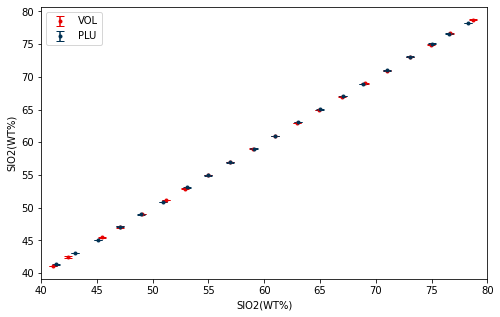

TIO2(WT%)
 # of tectonic setting: 2 

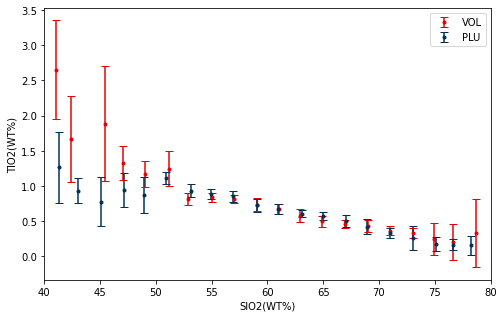

AL2O3(WT%)
 # of tectonic setting: 2 

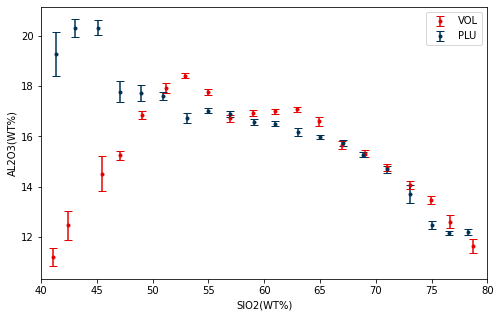

FEOT(WT%)
 # of tectonic setting: 2 

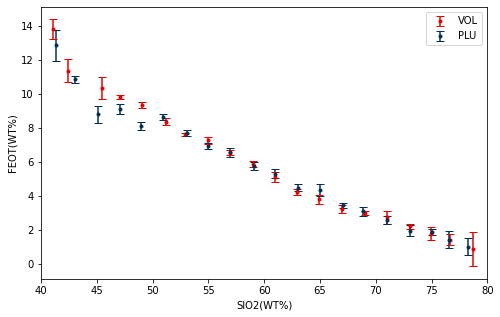

MGO(WT%)
 # of tectonic setting: 2 

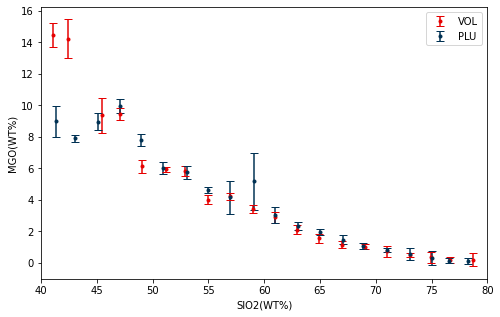

CAO(WT%)
 # of tectonic setting: 2 

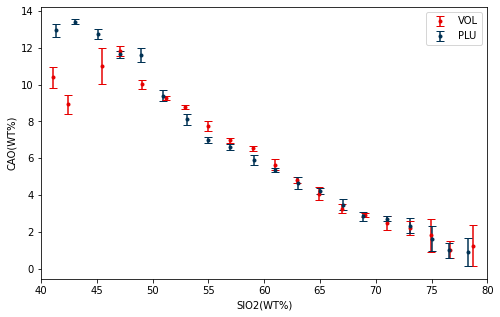

MNO(WT%)
 # of tectonic setting: 2 

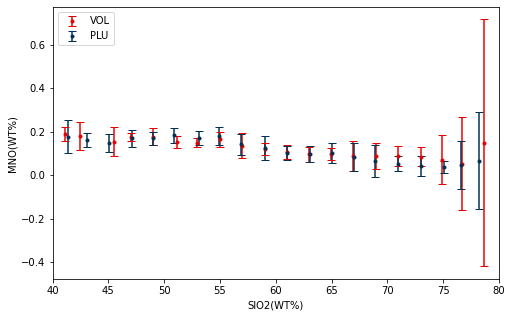

NA2O(WT%)
 # of tectonic setting: 2 

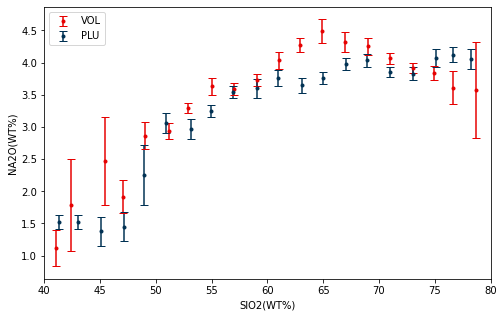

K2O(WT%)
 # of tectonic setting: 2  

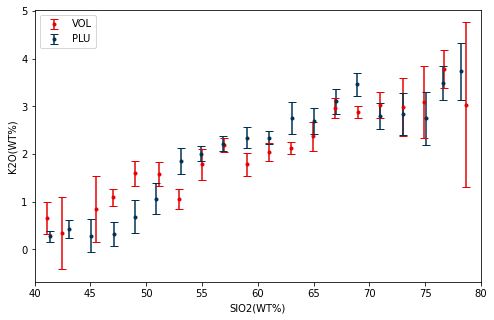

P2O5(WT%)
 # of tectonic setting: 2 

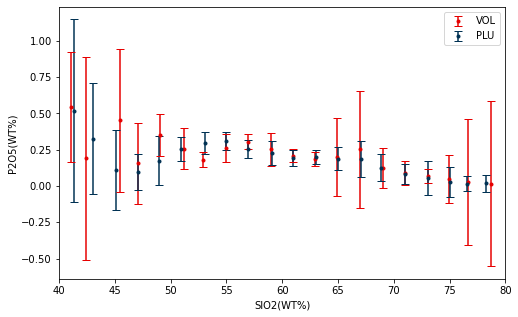

CR(PPM)
 # of tectonic setting: 2 

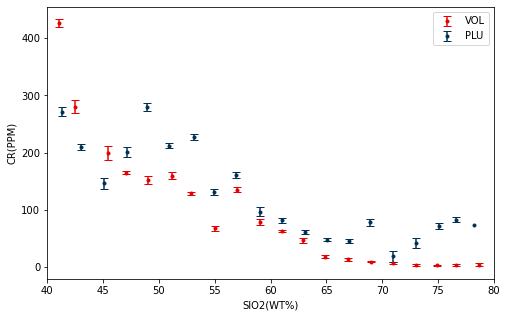

CO(PPM)
 # of tectonic setting: 2 

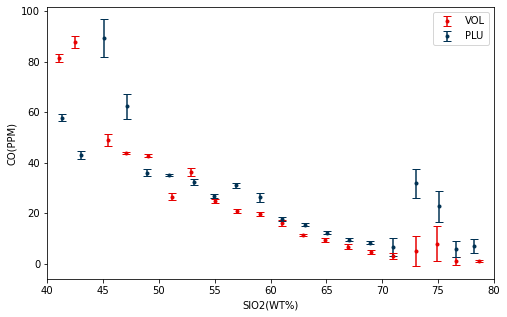

NI(PPM)
 # of tectonic setting: 2 

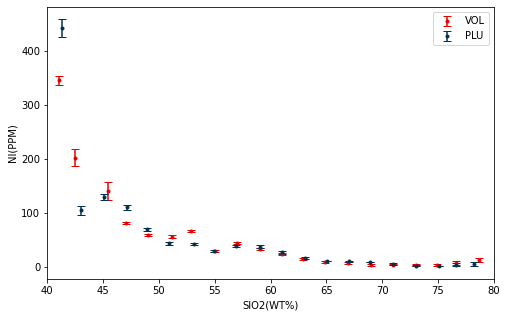

LA(PPM)
 # of tectonic setting: 2 

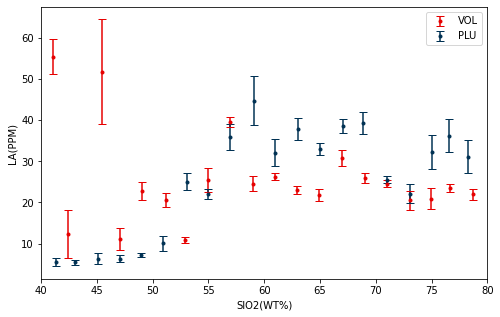

CE(PPM)
 # of tectonic setting: 2 

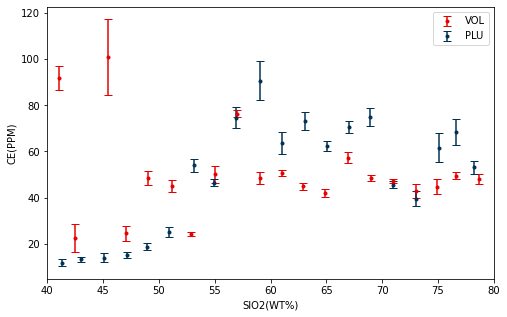

PR(PPM)
 # of tectonic setting: 2 

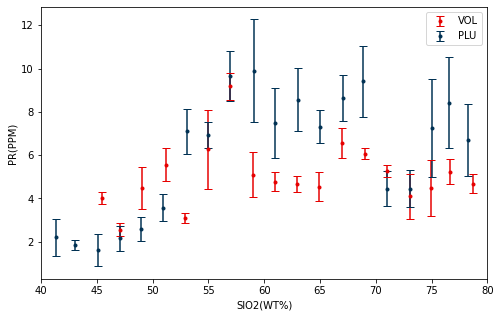

ND(PPM)
 # of tectonic setting: 2 

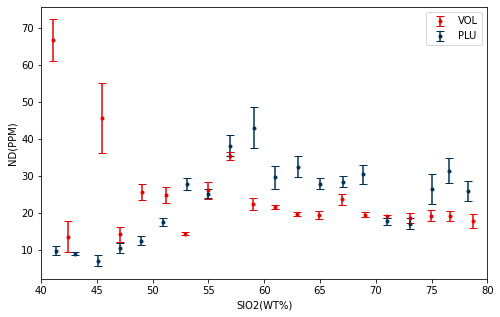

SM(PPM)
 # of tectonic setting: 2 

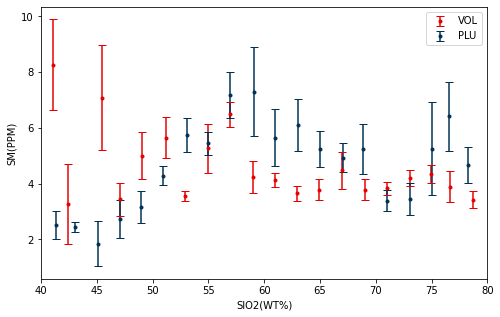

EU(PPM)
 # of tectonic setting: 2 

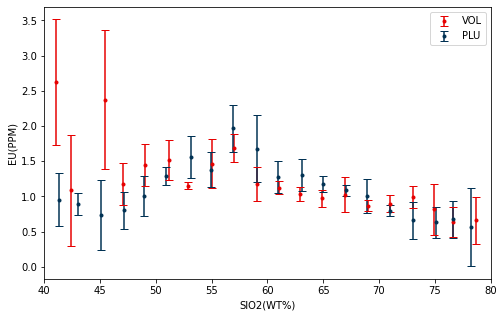

GD(PPM)
 # of tectonic setting: 2 

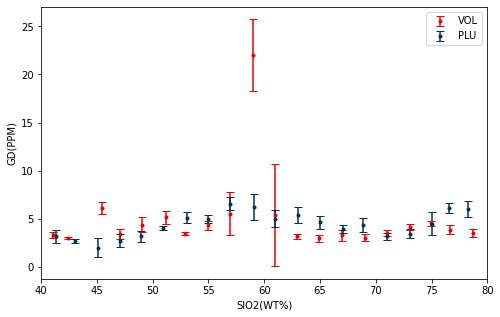

TB(PPM)
 # of tectonic setting: 2 

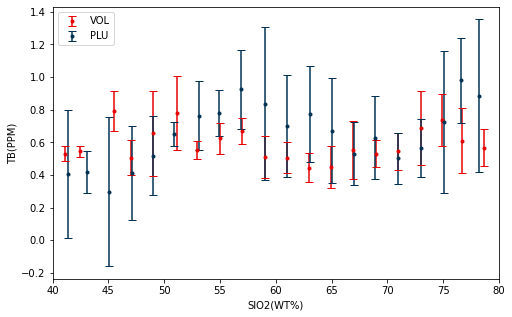

DY(PPM)
 # of tectonic setting: 2 

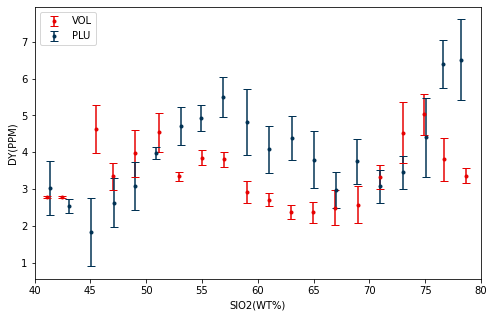

HO(PPM)
 # of tectonic setting: 2 

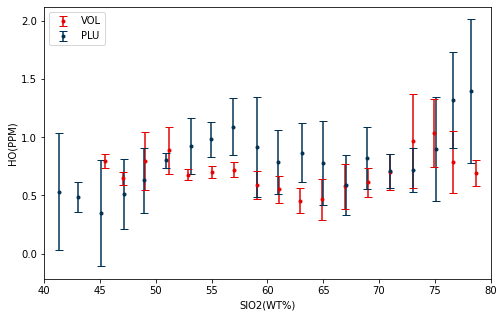

ER(PPM)
 # of tectonic setting: 2 

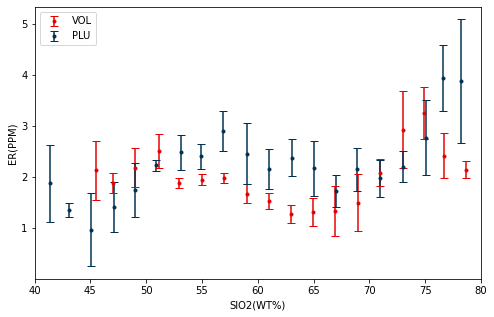

TM(PPM)
 # of tectonic setting: 2 

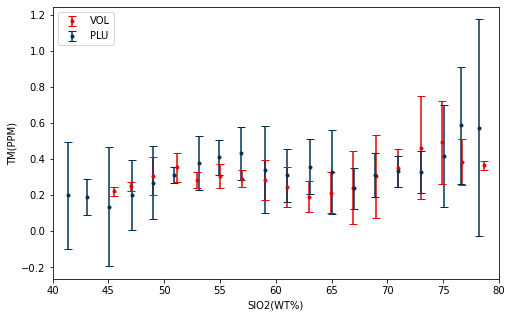

YB(PPM)
 # of tectonic setting: 2 

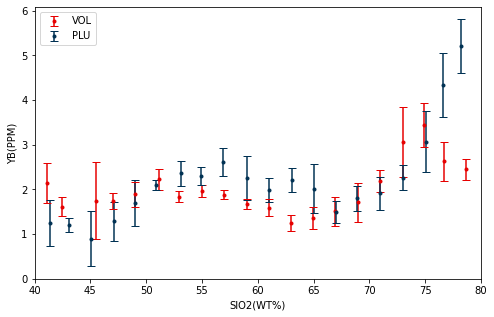

LU(PPM)
 # of tectonic setting: 2 

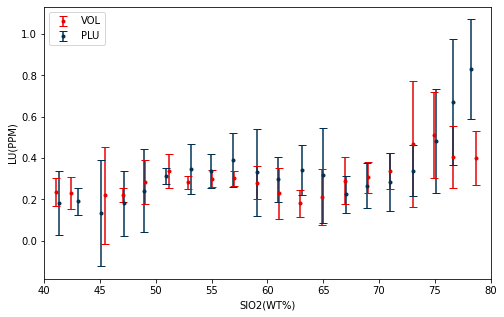

Y(PPM)
 # of tectonic setting: 2 

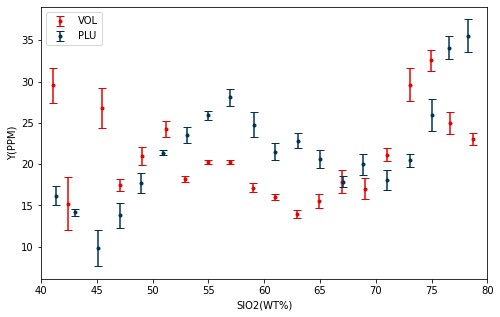

SC(PPM)
 # of tectonic setting: 2 

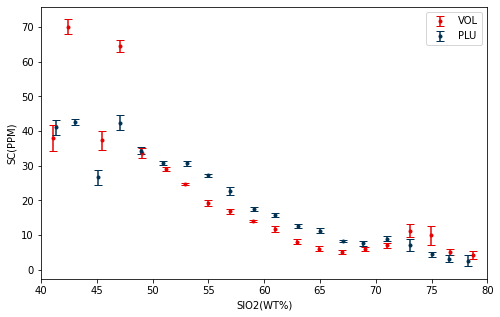

V(PPM)
 # of tectonic setting: 2 

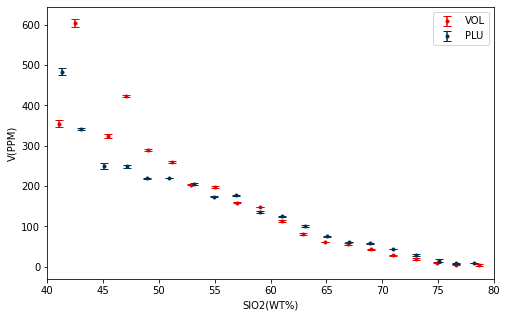

ZR(PPM)
 # of tectonic setting: 2 

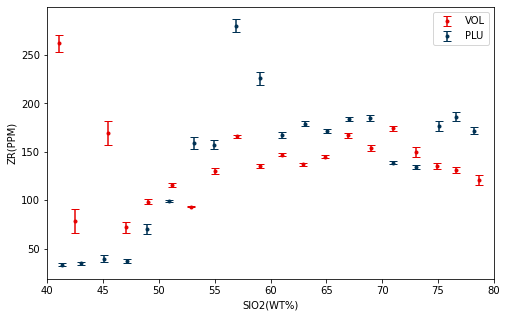

HF(PPM)
 # of tectonic setting: 2 

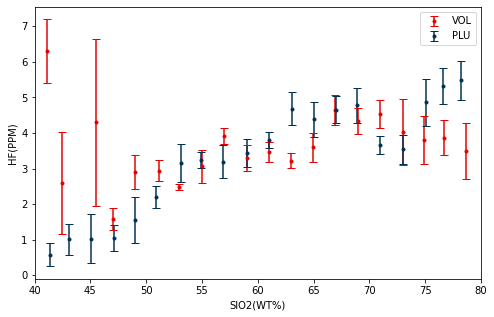

RB(PPM)
 # of tectonic setting: 2 

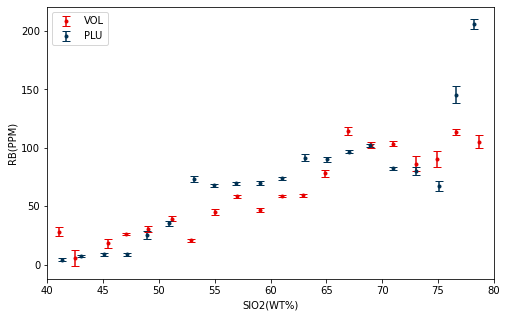

SR(PPM)
 # of tectonic setting: 2 

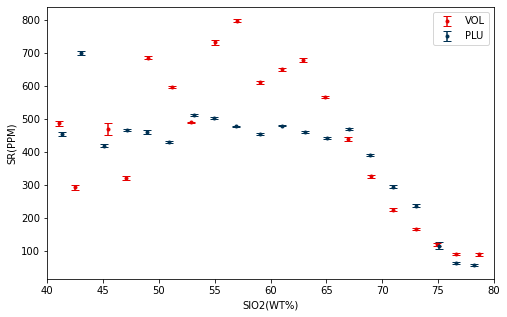

BA(PPM)
 # of tectonic setting: 2 

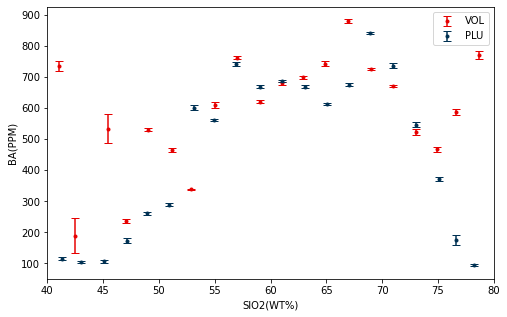

NB(PPM)
 # of tectonic setting: 2 

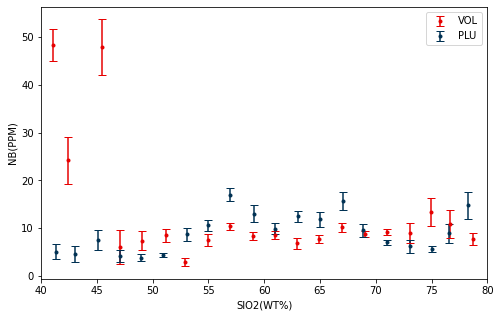

TA(PPM)
 # of tectonic setting: 2 

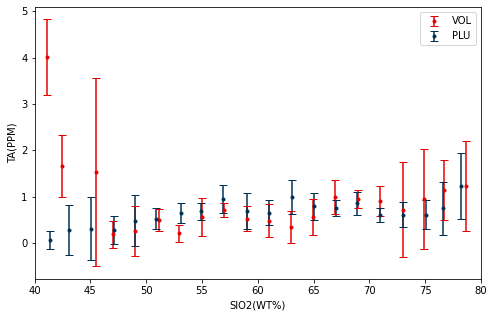

U(PPM)
 # of tectonic setting: 2 

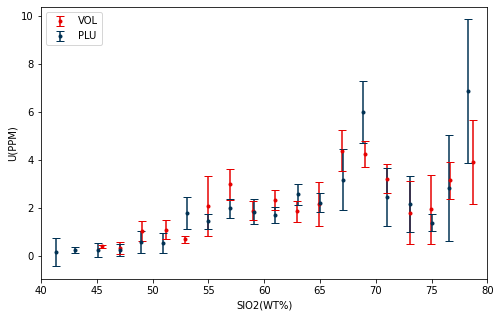

TH(PPM)
 # of tectonic setting: 2 

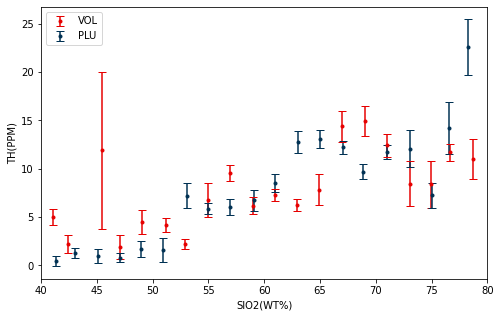

T
 # of tectonic setting: 2 

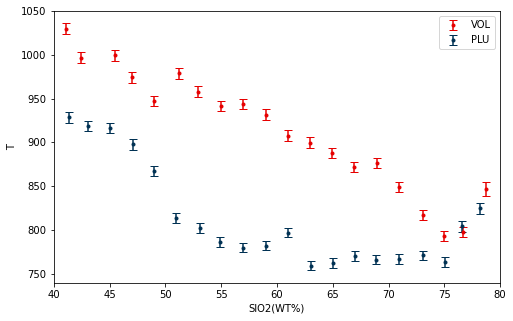

DEPTH
 # of tectonic setting: 2 

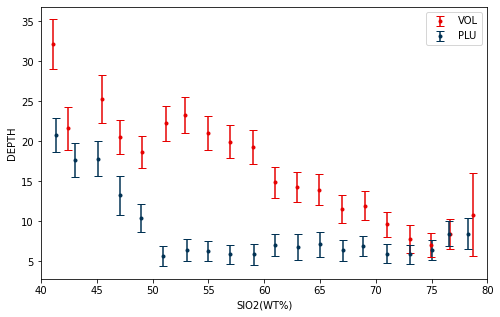

Eu/Eu*
 # of tectonic setting: 2 

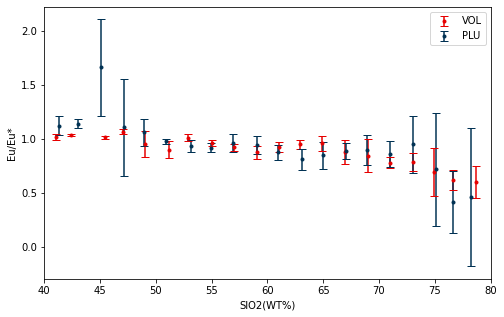

Sr/Y
 # of tectonic setting: 2 

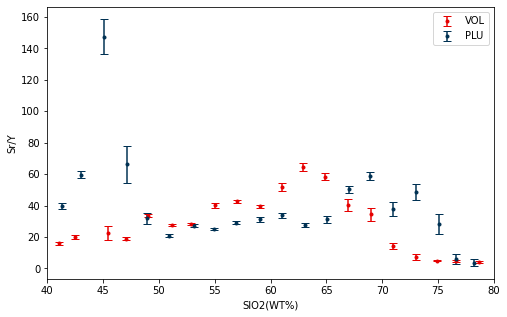

(La/Yb)N
 # of tectonic setting: 2 

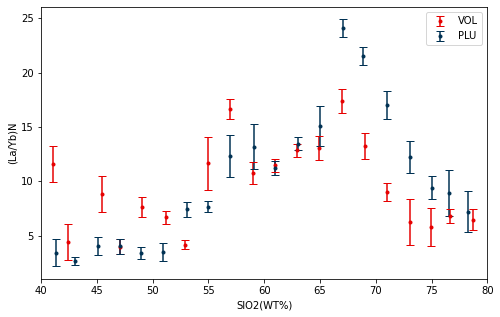

La/Yb
 # of tectonic setting: 2 

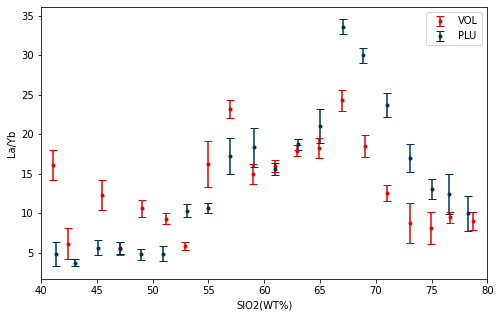

Rb/Sr
 # of tectonic setting: 2 

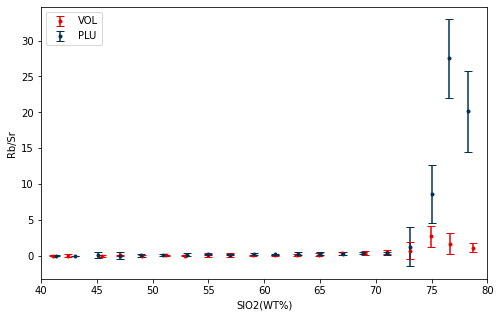

Ba/Rb
 # of tectonic setting: 2 

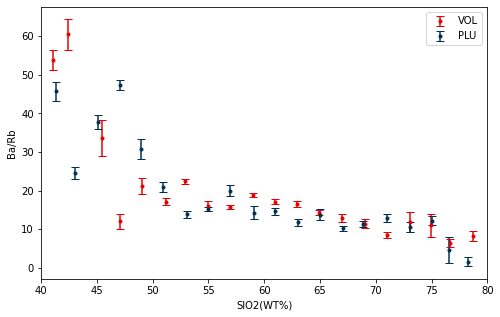

Ba/Sr
 # of tectonic setting: 2 

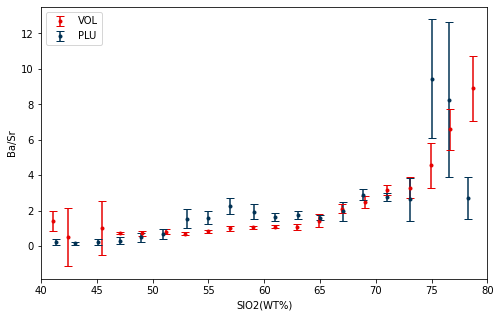

Ni/Co
 # of tectonic setting: 2 

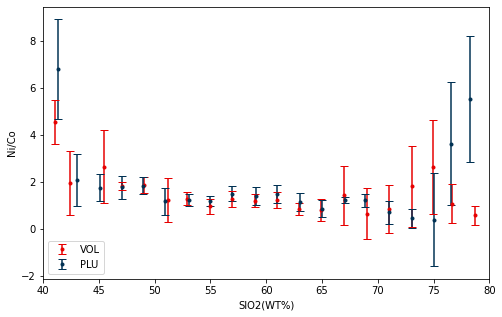

Nb/Ta
 # of tectonic setting: 2  

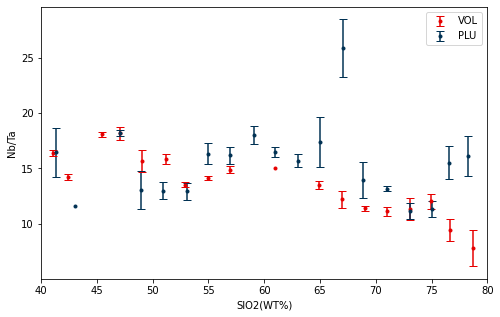

ree
 # of tectonic setting: 2 

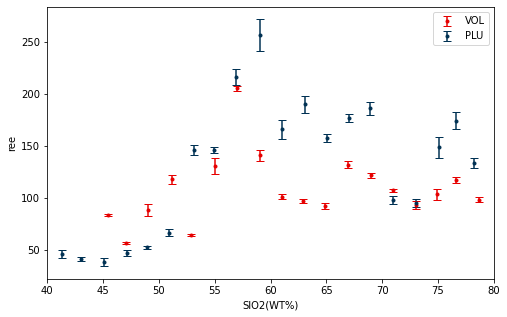

CPU times: user 5.43 s, sys: 146 ms, total: 5.58 s
Wall time: 5.42 s


In [135]:
%%time

# 根据构造背景分类的barplot
for i in simitemsin[4:]:
    print(i)
    fig, ax1 = plt.subplots(figsize=(8, 5))

    for j in range(len(tect_set)):
        clr = clrs[j]
        ax1.errorbar(
            x=sim_mean[sim_mean[tec] == tect_set[j]]["SIO2(WT%)"],
            y=sim_mean[sim_mean[tec] == tect_set[j]][i],
            yerr=sim_err[sim_err[tec] == tect_set[j]][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )  # , color = clr
        #         ax1.plot(sim_mean[sim_mean[tec] == tect_set[j]]['DEPTH'], sim_mean[sim_mean[tec] == tect_set[j]][i], color = clr)
        # plt.xlim(0, 40)
        plt.xlim(SiO2min, SiO2max)
        #         if i == 'DEPTH'
        print("\r # of tectonic setting: %d" % (j + 1), end=" ")
    plt.xlabel("SIO2(WT%)")
    plt.ylabel(i)

    ax1.legend()
    #     file_name = 'figures/errbar/' + 'CM' + '_' + i[:-5] + '_' + 'depth_noCC' + '.tiff'
    #     plt.rcParams['savefig.dpi'] = 300
    #     plt.savefig(file_name)
    plt.show()

# 3D PLOT: Depths, SiO2 and other elements

## 反加权重采样和蒙特卡洛

In [ ]:
vol_plu_bulk.groupby("TECTONIC SETTING").count()

In [ ]:
# sum_df = pd.read_csv('vol_plu_bulk_with_depth.csv')
sum_df = vol_plu_bulk
sum_df.loc[
    sum_df["TECTONIC SETTING"] == "convergent margin", "TECTONIC SETTING"
] = "CONVERGENT MARGIN"

In [ ]:
# 选择构造背景
sum_df = sum_df[sum_df["TECTONIC SETTING"] == "CONVERGENT MARGIN"]

### 1. 准备

In [ ]:
# Range of silica values to examine （Keller）
# SiO2min = 40 # 岩石学书上是45
SiO2min = 40  # 取中酸性岩
SiO2max = 80

In [ ]:
# simitemsin=['LATITUDE MIN', 'LONGITUDE MIN','MIN. AGE (YRS.)', 'MAX. AGE (YRS.)', 'SIO2(WT%)','FEOT(WT%)','MGO(WT%)','NI(PPM)','CAO(WT%)','AL2O3(WT%)','NA2O(WT%)','K2O(WT%)','TIO2(WT%)',\
#             'ZR(PPM)','HF(PPM)','YB(PPM)','RB(PPM)','BA(PPM)','SR(PPM)','EU(PPM)']
simitemsin = [
    "LATITUDE MIN",
    "LONGITUDE MIN",
    "MAX. AGE (YRS.)",
    "ROCK TYPE",
    "SIO2(WT%)",
    "TIO2(WT%)",
    "AL2O3(WT%)",
    "FEOT(WT%)",
    "MGO(WT%)",
    "CAO(WT%)",
    "MNO(WT%)",
    "NA2O(WT%)",
    "K2O(WT%)",
    "P2O5(WT%)",
    "CR(PPM)",
    "CO(PPM)",
    "NI(PPM)",
    "LA(PPM)",
    "CE(PPM)",
    "PR(PPM)",
    "ND(PPM)",
    "SM(PPM)",
    "EU(PPM)",
    "GD(PPM)",
    "TB(PPM)",
    "DY(PPM)",
    "HO(PPM)",
    "ER(PPM)",
    "TM(PPM)",
    "YB(PPM)",
    "LU(PPM)",
    "Y(PPM)",
    "SC(PPM)",
    "V(PPM)",
    "ZR(PPM)",
    "HF(PPM)",
    "RB(PPM)",
    "SR(PPM)",
    "BA(PPM)",
    "NB(PPM)",
    "TA(PPM)",
    "U(PPM)",
    "TH(PPM)",
    "Eu/Eu*",
    "(La/Yb)N",
    "La/Yb",
    "Rb/Sr",
    "Ba/Rb",
    "Ba/Sr",
    "Ni/Co",
    "Nb/Ta",
    "ree",
    "DEPTH",
]  #'TECTONIC SETTING'
len(simitemsin)

In [ ]:
data = sum_df[(sum_df["SIO2(WT%)"] > SiO2min) & (sum_df["SIO2(WT%)"] < SiO2max)]
# data = sum_df[~ ((sum_df['SIO2(WT%)'] < SiO2min) | (sum_df['SIO2(WT%)'] > SiO2max))]
data = data.dropna(subset=["LATITUDE MIN", "LONGITUDE MIN"])

data = data[simitemsin]
data.reset_index(inplace=True, drop=True)  # 一定要重置，不然下面会出错
print(data.shape)

### 2. 反加权

In [ ]:
def invweight(data, lat, lon):
    data["k"] = np.nan
    if data["k"].count() == lat.count():
        pass
    else:
        for i in range(len(lat)):
            data.loc[i, "k"] = np.nansum(
                1
                / (
                    (
                        180
                        / np.pi
                        * np.arccos(
                            np.sin(lat[i] * np.pi / 180) * np.sin(lat * np.pi / 180)
                            + np.cos(lat[i] * np.pi / 180)
                            * np.cos(lat * np.pi / 180)
                            * np.cos(lon[i] * np.pi / 180 - lon * np.pi / 180)
                        )
                    )
                    ** 2
                    + 1
                )
            )
            print("\r counting k value of line %d" % i, end="")

In [16]:
invweight(
    data, data["LATITUDE MIN"], data["LONGITUDE MIN"]
)  # this line will spend about 30 min

NameError: name 'invweight' is not defined

上面这行用循环，还是太慢了，有时间改成map函数试试

In [ ]:
prob = 1 / (data["k"] * ((5 / data["k"]).median()) + 1)

### 3. 蒙特卡罗

In [ ]:
# Number of simulations
nsims = 1000

ndata = len(simitemsin)

nbins = 10

# binedges = np.linspace(agemin,agemax, num=(nbins + 1))
binedges = np.linspace(dpmin, dpmax, num=(nbins + 1))
# binedges_si = np.linspace(SiO2min,SiO2max, num=(nbins + 1))
binedges_si = np.array([40, 51, 62, 74, 80])

In [ ]:
# mc:Monte Carlo
data["prob"] = prob


def mc(data, prob, binedges, nbins):  #  uncert,
    # 生成形状为 len(prob) ✖ 1 的随机数
    data["r"] = np.random.rand(len(prob), 1)

    # Randomize elements
    ssdata = data[data["prob"] > data["r"]]
    ssdata.iloc[:, 4:-13] = ssdata.iloc[:, 4:-13] + ssdata.iloc[:, 4:-13] * (
        list(elerr.values())[:-2] * np.random.randn(len(elerr) - 2)
    )
    ssdata.loc[:, "DEPTH"] = ssdata.loc[:, "DEPTH"] + ssdata.loc[:, "DEPTH"] * elerr[
        "DEPTH"
    ] * np.random.randn(ssdata.loc[:, "DEPTH"].shape[0])

    # # calculate average group by age bins，data structure is different from Keller.
    # ssdata['age_bins'] = pd.cut(ssdata['AGE'], binedges)
    # ssdata_ave = ssdata.groupby('age_bins').mean()
    # ssdata_ave.reset_index(inplace=True)
    ssdata["dp_bins"] = pd.cut(ssdata["DEPTH"], binedges)
    ssdata["si_bins"] = pd.cut(ssdata["SIO2(WT%)"], binedges_si)
    ssdata_ave = (
        ssdata.groupby(["ROCK TYPE", "dp_bins", "si_bins"])
    ).mean()  # ['TECTONIC SETTING','dp_bins']
    ssdata_num = (ssdata.groupby(["ROCK TYPE", "dp_bins", "si_bins"])).count()
    # ssdata_ave = (ssdata.groupby('dp_bins')).mean()
    ssdata_ave.reset_index(inplace=True)
    ssdata_num.reset_index(inplace=True)

    return ssdata_ave, ssdata_num;

In [ ]:
%%capture --no-stdout
%%time
simaverage_dict = []
simnum_dict = []
for i in range(nsims):
    avg, num = mc(data, prob, binedges, nbins)
    simaverage_dict.append(avg)
    simnum_dict.append(num)
    print("\r" + str(i), end="")

simaverage = pd.concat(simaverage_dict, keys=list(range(nsims)))
simnum = pd.concat(simnum_dict, keys=list(range(nsims)))

In [ ]:
simaverage.groupby("ROCK TYPE").count()

In [ ]:
simaverage

In [ ]:
# 为画图设置颜色和构造背景
# tec 是分类方式
# tec = 'TECTONIC SETTING'
tec = "ROCK TYPE"
# clrs = ['E60000', '003153']
clrs = colors  # list(map(lambda a: '#' + a, colors))
# tect_set = list(set(simaverage[tec]))
# tect_set = ['CONVERGENT MARGIN', 'INTRAPLATE VOLCANICS', 'OCEAN ISLAND', 'RIFT VOLCANICS']
# tect_set = ['CONVERGENT MARGIN']
tect_set = ["VOL", "PLU"]

In [ ]:
sim_mean = simaverage.groupby([tec, "dp_bins", "si_bins"]).mean()
sim_mean.reset_index(inplace=True)
# sim_mean = sim_mean[simitemsin[5:]]

sim_std = simaverage.groupby([tec, "dp_bins", "si_bins"]).std()
sim_std.reset_index(inplace=True)
# sim_std = sim_std[simitemsin[5:]]

sim_num = simnum.groupby([tec, "dp_bins", "si_bins"]).mean()
sim_num.reset_index(inplace=True)
# sim_num = sim_num[simitemsin[5:]]

# sim_stat = simaverage.groupby(['TECTONIC SETTING', 'si_bins']).agg(['mean', 'std', 'count'])

sim_err = sim_mean.copy()
sim_err[simitemsin[4:]] = (
    1.96 * sim_std[simitemsin[4:]] / sim_num[simitemsin[4:]].apply(np.sqrt)
)

In [17]:
%%time

# 根据构造背景分类的barplot
for i in simitemsin[4:]:
    print(i)
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
    #     # add horizontal lines of R&G 2003
    #     if i in cc_avg.keys():
    #         ax1.hlines(cc_avg[i][0], 0, uc_bt, colors = 'gray', linewidth = 8, alpha = 0.4)
    #         ax1.hlines(cc_avg[i][1], uc_bt, mc_bt, colors = 'gray', linewidth = 8, alpha = 0.4)
    #         ax1.hlines(cc_avg[i][2], mc_bt, lc_bt, colors = 'gray', linewidth = 8, alpha = 0.4)
    #         ax1.hlines(cc_avg[i][3], 0, lc_bt, colors = 'gray')

    #     # add horizontal lines of primitive mantle
    #     if i in pm.keys():
    #         ax1.hlines(pm[i], 0, lc_bt, colors = 'black')

    #     # add horizontal lines of upper, middle, lower, and bulk crust.
    #     if i in uc_avg.keys():
    #         for l in range(len(uc_avg[i])):
    #             ax1.hlines(uc_avg[i][l], 0, uc_bt, colors = 'darkgreen', alpha = l/len(uc_avg[i])*.7, linewidth = 4)
    #         for l in range(len(mc_avg[i])):
    #             ax1.hlines(mc_avg[i][l], uc_bt, mc_bt, colors = 'darkgreen', alpha = l/len(mc_avg[i])*.7, linewidth = 4)
    #         for l in range(len(lc_avg[i])):
    #             ax1.hlines(lc_avg[i][l], mc_bt, lc_bt, colors = 'darkgreen', alpha = l/len(lc_avg[i])*.7, linewidth = 4)
    #         for l in range(len(bc_avg[i])):
    #             ax1.hlines(bc_avg[i][l], 0, lc_bt, colors = 'gray', alpha = l/len(bc_avg[i]))

    #     # Add composition range of upper, middle, and lower crust
    #     if i in uc_avg.keys():
    #         uc_q1, uc_q3 = np.nanpercentile(uc_avg[i][2: -3], [25, 75]) # [2:-3] exclude old and upper-most data
    #         uc_iqr = uc_q3 - uc_q1
    #         mc_q1, mc_q3 = np.nanpercentile(mc_avg[i][2:], [25, 75]) # [2:]exclude old data
    #         mc_iqr = mc_q3 - mc_q1
    #         lc_q1, lc_q3 = np.nanpercentile(lc_avg[i][1:], [25, 75]) # [1:]exclude old data
    #         lc_iqr = lc_q3 - lc_q1

    #         ax1.add_patch(Rectangle((0, uc_q1), uc_bt, uc_iqr,facecolor = 'gray', alpha = 0.2))
    #         ax1.add_patch(Rectangle((uc_bt, mc_q1), mc_bt - uc_bt, mc_iqr,facecolor = 'gray', alpha = 0.2))
    #         ax1.add_patch(Rectangle((mc_bt, lc_q1), lc_bt - mc_bt, lc_iqr,facecolor = 'gray', alpha = 0.2))

    for j in range(len(tect_set)):
        clr = clrs[j]
        ub_mean = (sim_mean[tec] == tect_set[j]) & (
            sim_mean["si_bins"] == pd.Interval(left=40, right=51)
        )
        ub_err = (sim_err[tec] == tect_set[j]) & (
            sim_err["si_bins"] == pd.Interval(left=40, right=51)
        )
        b_mean = (sim_mean[tec] == tect_set[j]) & (
            sim_mean["si_bins"] == pd.Interval(left=51, right=62)
        )
        b_err = (sim_err[tec] == tect_set[j]) & (
            sim_err["si_bins"] == pd.Interval(left=51, right=62)
        )
        im_mean = (sim_mean[tec] == tect_set[j]) & (
            sim_mean["si_bins"] == pd.Interval(left=62, right=74)
        )
        im_err = (sim_err[tec] == tect_set[j]) & (
            sim_err["si_bins"] == pd.Interval(left=62, right=74)
        )
        ac_mean = (sim_mean[tec] == tect_set[j]) & (
            sim_mean["si_bins"] == pd.Interval(left=74, right=80)
        )
        ac_err = (sim_err[tec] == tect_set[j]) & (
            sim_err["si_bins"] == pd.Interval(left=74, right=80)
        )
        axs[0, 0].errorbar(
            x=sim_mean[ub_mean]["DEPTH"],
            y=sim_mean[ub_mean][i],
            yerr=sim_err[ub_err][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )  # , color = clr
        axs[0, 0].set_ylabel(i)
        axs[0, 0].set_title("SiO2: " + str(40) + "~" + str(51))
        axs[0, 1].errorbar(
            x=sim_mean[b_mean]["DEPTH"],
            y=sim_mean[b_mean][i],
            yerr=sim_err[b_err][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )
        axs[0, 1].set_title("SiO2: " + str(51) + "~" + str(62))
        axs[1, 0].errorbar(
            x=sim_mean[im_mean]["DEPTH"],
            y=sim_mean[im_mean][i],
            yerr=sim_err[im_err][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )
        axs[1, 0].set_xlabel("Depth(Km)")
        axs[1, 0].set_ylabel(i)
        axs[1, 0].set_title("SiO2: " + str(62) + "~" + str(74))
        axs[1, 1].errorbar(
            x=sim_mean[ac_mean]["DEPTH"],
            y=sim_mean[ac_mean][i],
            yerr=sim_err[ac_err][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )
        axs[1, 1].set_xlabel("Depth(Km)")
        axs[1, 1].set_title("SiO2: " + str(74) + "~" + str(80))
        #         ax1.plot(sim_mean[sim_mean[tec] == tect_set[j]]['DEPTH'], sim_mean[sim_mean[tec] == tect_set[j]][i], color = clr)
        # plt.xlim(0, 40)
        plt.xlim(dpmin, dpmax)
        print("\r # of tectonic setting: %d" % (j + 1), end=" ")
    plt.xlabel("Depth(Km)")
    plt.ylabel(i)

    plt.legend()
    #     file_name = 'figures/errbar/' + 'CM' + '_' + i[:-5] + '_' + 'depth_noCC' + '.tiff'
    #     plt.rcParams['savefig.dpi'] = 300
    #     plt.savefig(file_name)
    plt.show()

NameError: name 'simitemsin' is not defined

In [18]:
# # make 3d plot
# %%time
# simitemsin=['FEOT(WT%)', 'MGO(WT%)', 'CAO(WT%)', 'NA2O(WT%)', 'K2O(WT%)','YB(PPM)', 'Y(PPM)', 'ZR(PPM)', 'HF(PPM)',\
#             'RB(PPM)', 'SR(PPM)', 'BA(PPM)', 'NB(PPM)', 'TA(PPM)', 'U(PPM)', 'TH(PPM)', 'Eu/Eu*', '(La/Yb)N', 'Rb/Sr', 'Ba/Rb',\
#             'Ba/Sr', 'Ni/Co', 'Nb/Ta']

# def take_num(elem):
#     return int(elem[:-4])

# for i in simitemsin:
#     print(i)
#     fig, ax1 = plt.subplots(figsize=(12, 8))
#     ax1 = fig.add_subplot(111, projection='3d')
#     for j in range(len(tect_set)):
#         clr = clrs[j]
#         ax1.scatter(xs=sim_mean[sim_mean[tec] == tect_set[j]]['DEPTH'],
#                     ys=sim_mean[sim_mean[tec] == tect_set[j]]['SIO2(WT%)'],
#                     zs=sim_mean[sim_mean[tec] == tect_set[j]][i],
#                     color = clr) #markersize=3, capsize=4, fmt='o', label=tect_set[j], , color = clr

#         plt.xlim(dpmin, dpmax)
#         print("\r # of tectonic setting: %d" % (j+1), end=' ')
#     ax1.set_xlabel('Depth(Km)')
#     ax1.set_ylabel('SIO2(WT%)')
#     ax1.set_zlabel(i)

# #     ax1.legend()
# #     file_name = 'figures/errbar/' + 'CM' + '_' + i[:-5] + '_' + 'depth' + '.png'
# #     plt.savefig(file_name)
#     for r in range(0,120):
#         ax1.view_init(1,r*3 - 60)
#         plt.draw()
#         plt.savefig('./figures/rot/' + str(r) + '.jpg',dpi=100)

#     jpg_path = './figures/rot/'
#     gif_name = './figures/gif/' + i[:-5] + '.gif'
#     mp4_name = './figures/mp4/' + i[:-5] + '.mp4'

#     jpgs = os.listdir(jpg_path)
#     jpgs.sort(key=take_num)
#     jpgs = [jpg_path + jpg for jpg in jpgs]

#     frames = []
#     for image_name in jpgs:
#         frames.append(imageio.imread(image_name))

#     imageio.mimsave(gif_name, frames, 'GIF', duration=0.2)
#     imageio.mimsave(mp4_name, frames, 'mp4', fps=8)

#     shutil.rmtree('./figures/rot/')
#     os.mkdir('./figures/rot/')
# #     plt.show()

# Sr/Y, La/Yb vs. Depth

## 反加权重采样和蒙特卡洛

In [136]:
# sum_df = pd.read_csv('vol_plu_bulk_with_depth.csv')
sum_df = vol_plu_bulk
sum_df.loc[
    sum_df["TECTONIC SETTING"] == "convergent margin", "TECTONIC SETTING"
] = "CONVERGENT MARGIN"

In [137]:
# 选择构造背景
sum_df = sum_df[sum_df["TECTONIC SETTING"] == "CONVERGENT MARGIN"]
# sum_df = sum_df[sum_df['TECTONIC SETTING'] == 'INTRAPLATE VOLCANICS']

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='La/Yb', ylabel='Density'>

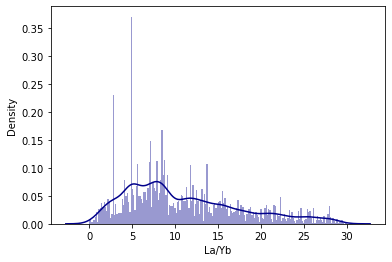

In [138]:
sns.distplot(
    vol_plu_bulk[(vol_plu_bulk["La/Yb"] >= 0) & (vol_plu_bulk["La/Yb"] <= 30)]["La/Yb"],
    kde=True,
    bins=int(200),
    color="darkblue",
)

### 1. 准备

In [139]:
ele_ratio = "La/Yb"  # 'La/Yb' or 'Sr/Y'
SiO2min = 62  # 取中酸性岩
SiO2max = 68
SrYmin = 0
SrYmax = 80
LaYbmin = 0
LaYbmax = 30
if ele_ratio == "Sr/Y":
    ele_min = SrYmin
    ele_max = SrYmax
elif ele_ratio == "La/Yb":
    ele_min = LaYbmin
    ele_max = LaYbmax

In [140]:
# simitemsin=['LATITUDE MIN', 'LONGITUDE MIN', 'MAX. AGE (YRS.)', 'ROCK TYPE', \
#             'SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)', 'FEOT(WT%)', 'MGO(WT%)', 'CAO(WT%)', 'MNO(WT%)', 'NA2O(WT%)', 'K2O(WT%)', 'P2O5(WT%)', \
#             'CR(PPM)', 'CO(PPM)', 'NI(PPM)', 'LA(PPM)', 'CE(PPM)', 'PR(PPM)', 'ND(PPM)', 'SM(PPM)', 'EU(PPM)', 'GD(PPM)', 'TB(PPM)', \
#             'DY(PPM)', 'HO(PPM)', 'ER(PPM)', 'TM(PPM)', 'YB(PPM)', 'LU(PPM)', 'Y(PPM)', 'SC(PPM)', 'V(PPM)', 'ZR(PPM)', 'HF(PPM)',\
#             'RB(PPM)', 'SR(PPM)', 'BA(PPM)', 'NB(PPM)', 'TA(PPM)', 'U(PPM)', 'TH(PPM)', 'T', 'DEPTH', 'Eu/Eu*', 'Sr/Y', '(La/Yb)N', 'La/Yb', 'Rb/Sr', 'Ba/Rb',\
#             'Ba/Sr', 'Ni/Co', 'Nb/Ta', 'ree'] #'TECTONIC SETTING'
simitemsin = [
    "LATITUDE MIN",
    "LONGITUDE MIN",
    "MAX. AGE (YRS.)",
    "SIO2(WT%)",
    "ROCK TYPE",
    "T",
    "DEPTH",
    "Sr/Y",
    "La/Yb",
]
len(simitemsin)

9

In [141]:
# data = sum_df[(sum_df['SIO2(WT%)'] > SiO2min) & (sum_df['SIO2(WT%)'] < SiO2max)]
data = sum_df[~((sum_df["SIO2(WT%)"] < SiO2min) | (sum_df["SIO2(WT%)"] > SiO2max))]
data = data[~((sum_df[ele_ratio] < ele_min) | (sum_df[ele_ratio] > ele_max))]

data = data.dropna(subset=["LATITUDE MIN", "LONGITUDE MIN"])

data = data[simitemsin]
data.reset_index(inplace=True, drop=True)  # 一定要重置，不然下面会出错
print(data.shape)

(3283, 9)


/tmp/ipykernel_1214620/884232259.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~((sum_df[ele_ratio] < ele_min) | (sum_df[ele_ratio] > ele_max))]


In [142]:
data.describe()

LATITUDE MIN  LONGITUDE MIN    SIO2(WT%)            T        DEPTH  \
count   3283.000000    3283.000000  2894.000000  3283.000000  3283.000000   
mean      13.574008      26.651900    64.337947   820.570714     9.517136   
std       31.953933     107.039969     1.513550    84.941949     8.997752   
min      -46.900000    -177.000000    62.050000   592.668661     0.204627   
25%      -19.793786     -65.517317    63.030000   769.723064     3.913956   
50%       21.120000      23.378000    64.300000   801.493381     5.825200   
75%       38.930000     123.330000    65.410000   893.295675    12.989218   
max      138.250000     243.560000    68.000000  1086.291500    73.532246   

              Sr/Y        La/Yb  
count  2150.000000  1870.000000  
mean     44.550883    14.048572  
std      43.605250     6.881290  
min       0.106452     1.688034  
25%      15.739130     8.974883  
50%      29.059829    13.250000  
75%      60.895522    18.461538  
max     353.500000    29.850746

In [143]:
data.count()

LATITUDE MIN       3283
LONGITUDE MIN      3283
MAX. AGE (YRS.)    1505
SIO2(WT%)          2894
ROCK TYPE          3283
T                  3283
DEPTH              3283
Sr/Y               2150
La/Yb              1870
dtype: int64

### 2. 反加权

In [144]:
def invweight(data, lat, lon):
    data["k"] = np.nan
    if data["k"].count() == lat.count():
        pass
    else:
        for i in range(len(lat)):
            data.loc[i, "k"] = np.nansum(
                1
                / (
                    (
                        180
                        / np.pi
                        * np.arccos(
                            np.sin(lat[i] * np.pi / 180) * np.sin(lat * np.pi / 180)
                            + np.cos(lat[i] * np.pi / 180)
                            * np.cos(lat * np.pi / 180)
                            * np.cos(lon[i] * np.pi / 180 - lon * np.pi / 180)
                        )
                    )
                    ** 2
                    + 1
                )
            )
            print("\r counting k value of line %d" % i, end="")

In [145]:
invweight(
    data, data["LATITUDE MIN"], data["LONGITUDE MIN"]
)  # this line will spend about 30 min

 counting k value of line 47

/home/ke/miniconda3/envs/rock/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


 counting k value of line 3282

上面这行用循环，还是太慢了，有时间改成map函数试试

In [146]:
prob = 1 / (data["k"] * ((5 / data["k"]).median()) + 1)

#### Resampling the samples weighted by silica relative to the silica distribution of all-of-georoc for volcanics and plutonics.

In [147]:
# Silica distribution density in arc, 20 bins, 40-80, calculated from Keller2015, VolcanicPlutonic.ipynb
v_density_original = [
    0.0002811632863869132,
    0.0005623265727738286,
    0.008575480234800852,
    0.0033739594366429715,
    0.009700133380348506,
    0.021087246479018492,
    0.024390915094064814,
    0.03359901272323613,
    0.05025793744166073,
    0.08224026126817242,
    0.048219503615355805,
    0.06537046408495732,
    0.05201520798157894,
    0.01982201169027746,
    0.02108724647901841,
    0.03289610450726897,
    0.018837940187923258,
    0.016237179788844175,
    0.029381563427432773,
    0.009559551737155012,
]
p_density_original = [
    0.009702685627687042,
    0.006881337324600739,
    0.02319010678390449,
    0.04307717165200045,
    0.01417555488867752,
    0.02029994510757218,
    0.05828492713936825,
    0.017272156684747783,
    0.04121921057435843,
    0.0633771167595728,
    0.06998320059118951,
    0.04342123851823066,
    0.0353700738484478,
    0.02718128243217292,
    0.032273472052377204,
    0.012386407184281429,
    0.015758262473335564,
    0.005711509979418612,
    0.007707097803552827,
    0.01658402295228778,
]
# Georoc arc
vol_density = [
    0.0009595677287125024,
    0.0023616545556176633,
    0.00572479970188187,
    0.01655487236817589,
    0.036379727967207,
    0.05068474007825601,
    0.052939258431153345,
    0.04769890068939817,
    0.044093534563070615,
    0.04355785354946898,
    0.04155953046394634,
    0.02980715483510341,
    0.022922489286379726,
    0.018208496366685298,
    0.01645705235699646,
    0.0174864915222657,
    0.021627538662194894,
    0.01865101546487796,
    0.00990776970374511,
    0.002417551704863052,
]
plu_density = [
    0.011806130903065452,
    0.016518227009113505,
    0.02640845070422535,
    0.02998135874067937,
    0.033709610604805304,
    0.02749585749792875,
    0.026667357083678542,
    0.02324979287489644,
    0.020764291632145816,
    0.02117854183927092,
    0.026563794531897267,
    0.028013670256835127,
    0.03427920463960232,
    0.03609154929577465,
    0.03246685998342999,
    0.030809859154929578,
    0.030654515327257662,
    0.027910107705053852,
    0.01335956917978459,
    0.002071251035625518,
]
# # earthchem arc
# vol_density = [0.0008544542589551245, 0.001753295752141684, 0.0049158861911314305, 0.021516711793688137, 0.046207110834923876, 0.057492565138266234, 0.06172044919881042, 0.050046606595943004, 0.044808912956633674, 0.04321097252430201, 0.0397154778285765, 0.03270229482000977, 0.02281503839495761, 0.01475875538195215, 0.01368236495183985, 0.011940166008256026, 0.013937591548670603, 0.0110857117493009, 0.005526210661813662, 0.0013094234098273336]
# plu_density = [0.003006012024048096, 0.005792835671342685, 0.008610971943887775, 0.013057364729458917, 0.01747244488977956, 0.023922845691382765, 0.031437875751503, 0.035539829659318636, 0.0375438376753507, 0.04186497995991984, 0.04574774549098196, 0.04746993987975952, 0.03638527054108216, 0.03316007014028056, 0.0313439378757515, 0.026772294589178357, 0.02971568136272545, 0.019476452905811622, 0.010270541082164329, 0.0014090681362725452]

v_density_original = np.array(v_density_original)
p_density_original = np.array(p_density_original)
vol_density = np.array(vol_density)
plu_density = np.array(plu_density)

vol_density = vol_density / v_density_original
plu_density = plu_density / p_density_original

In [148]:
si_range = np.arange(40, 81, 2)
for i in range(len(si_range) - 1):
    p_si_range = (
        (data["SIO2(WT%)"] >= si_range[i])
        & (data["SIO2(WT%)"] <= si_range[i + 1])
        & (data["ROCK TYPE"] == "PLU")
    )
    v_si_range = (
        (data["SIO2(WT%)"] >= si_range[i])
        & (data["SIO2(WT%)"] <= si_range[i + 1])
        & (data["ROCK TYPE"] == "VOL")
    )
    prob.loc[p_si_range] = prob.loc[p_si_range] * plu_density[i]
    prob.loc[v_si_range] = prob.loc[v_si_range] * vol_density[i]

### 3. 蒙特卡罗

In [149]:
# Number of simulations
nsims = 1000

ndata = len(simitemsin)

nbins = 20

# binedges = np.linspace(agemin,agemax, num=(nbins + 1))
# binedges = np.linspace(dpmin,dpmax, num=(nbins + 1))
binedges = np.linspace(ele_min, ele_max, num=(nbins + 1))

In [150]:
data["ele_bins"] = pd.cut(data[ele_ratio], binedges)
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    data_count = data.groupby(["ROCK TYPE", "ele_bins"]).count()
    display(data_count)

LATITUDE MIN  LONGITUDE MIN  MAX. AGE (YRS.)  \
ROCK TYPE ele_bins                                                     
PLU       (0.0, 1.5]               0              0                0   
          (1.5, 3.0]              36             36                3   
          (3.0, 4.5]              61             61               51   
          (4.5, 6.0]              63             63               48   
          (6.0, 7.5]              27             27                0   
          (7.5, 9.0]              48             48               15   
          (9.0, 10.5]              1              1                0   
          (10.5, 12.0]            50             50               41   
          (12.0, 13.5]            34             34               19   
          (13.5, 15.0]            60             60               44   
          (15.0, 16.5]            92             92               82   
          (16.5, 18.0]            48             48               30   
          (18.0, 19.5]            19             19               12   
          (19.5, 21.0]            69             69               61   
          (21.0, 22.5]            14             14               14   
          (22.5, 24.0]            27             27               27   
          (24.0, 25.5]            82             82               53   
          (25.5, 27.0]            12             12               12   
          (27.0, 28.5]            20             20               15   
          (28.5, 30.0]             9              9                0   
VOL       (0.0, 1.5]               0              0                0   
          (1.5, 3.0]               0              0                0   
          (3.0, 4.5]              28             28                0   
          (4.5, 6.0]              54             54                1   
          (6.0, 7.5]             129            129                0   
          (7.5, 9.0]              24             24                0   
          (9.0, 10.5]            236            236                0   
          (10.5, 12.0]            43             43                0   
          (12.0, 13.5]           166            166               52   
          (13.5, 15.0]            48             48               23   
          (15.0, 16.5]            42             42                0   
          (16.5, 18.0]            88             88               85   
          (18.0, 19.5]            26             26                0   
          (19.5, 21.0]             9              9                0   
          (21.0, 22.5]            51             51               33   
          (22.5, 24.0]             5              5                0   
          (24.0, 25.5]            55             55                0   
          (25.5, 27.0]            91             91               66   
          (27.0, 28.5]             2              2                0   
          (28.5, 30.0]             1              1                1   

                        SIO2(WT%)    T  DEPTH  Sr/Y  La/Yb    k  
ROCK TYPE ele_bins                                               
PLU       (0.0, 1.5]            0    0      0     0      0    0  
          (1.5, 3.0]           36   36     36    36     36   36  
          (3.0, 4.5]           61   61     61    61     61   61  
          (4.5, 6.0]           63   63     63    63     63   63  
          (6.0, 7.5]           27   27     27    27     27   27  
          (7.5, 9.0]           48   48     48    48     48   48  
          (9.0, 10.5]           1    1      1     1      1    1  
          (10.5, 12.0]         50   50     50    50     50   50  
          (12.0, 13.5]         34   34     34    30     34   34  
          (13.5, 15.0]         60   60     60    60     60   60  
          (15.0, 16.5]         92   92     92    92     92   92  
          (16.5, 18.0]         48   48     48    48     48   48  
          (18.0, 19.5]         19   19     19    19     19   19  
         

In [151]:
elerr = {"T": 0.1, "DEPTH": 0.23, "Sr/Y": 0.022, "La/Yb": 0.014}

In [152]:
# mc:Monte Carlo
def mc(data, prob, binedges, nbins):  #  uncert,
    # 生成形状为 len(prob) ✖ 1 的随机数
    data["prob"] = prob
    data["r"] = np.random.rand(len(prob), 1)

    # Randomize elements
    ssdata = data.loc[data["prob"] > data["r"]]
    ssdata.iloc[:, 5:-4] = ssdata.iloc[:, 5:-4] + ssdata.iloc[:, 5:-4] * (
        list(elerr.values()) * np.random.randn(len(elerr))
    )

    # Randomize ages
    # ssdata['AGE'] = ssdata['AGE'] + ssdata['age_uncert']*np.random.randn(ssdata.shape[0])/2

    ## calculate average group by age bins，data structure is different from Keller.
    ssdata["ele_bins"] = pd.cut(ssdata[ele_ratio], binedges)
    ssdata_ave = (
        ssdata.groupby(["ROCK TYPE", "ele_bins"])
    ).mean()  # ['TECTONIC SETTING','dp_bins']
    ssdata_num = (ssdata.groupby(["ROCK TYPE", "ele_bins"])).count()
    # ssdata_ave = (ssdata.groupby('dp_bins')).mean()
    ssdata_ave.reset_index(inplace=True)
    ssdata_num.reset_index(inplace=True)

    return ssdata_ave, ssdata_num
    # done

In [153]:
%%capture --no-stdout
%%time
simaverage_dict = []
simnum_dict = []
for i in range(nsims):
    avg, num = mc(data, prob, binedges, nbins)
    simaverage_dict.append(avg)
    simnum_dict.append(num)
    print("\r" + str(i), end="")

simaverage = pd.concat(simaverage_dict, keys=list(range(nsims)))
simnum = pd.concat(simaverage_dict, keys=list(range(nsims)))

999CPU times: user 10.5 s, sys: 213 ms, total: 10.8 s
Wall time: 10.5 s


In [154]:
simaverage.groupby("ROCK TYPE").count()

ele_bins  LATITUDE MIN  LONGITUDE MIN  SIO2(WT%)      T  DEPTH  \
ROCK TYPE                                                                   
PLU           20000         18891          18891      18891  18891  18891   
VOL           20000         16879          16879      15977  16879  16879   

            Sr/Y  La/Yb      k   prob      r  
ROCK TYPE                                     
PLU        18891  18891  18891  18891  18891  
VOL        16430  16879  16879  16879  16879

In [155]:
simaverage

ROCK TYPE      ele_bins  LATITUDE MIN  LONGITUDE MIN  SIO2(WT%)  \
0   0        PLU    (0.0, 1.5]           NaN            NaN        NaN   
    1        PLU    (1.5, 3.0]     35.233451      41.466623  64.621875   
    2        PLU    (3.0, 4.5]     37.682755     104.285964  64.868182   
    3        PLU    (4.5, 6.0]     32.084615      42.040769  66.167692   
    4        PLU    (6.0, 7.5]     37.409380    -120.118980  66.680000   
...          ...           ...           ...            ...        ...   
999 35       VOL  (22.5, 24.0]      5.825509     -84.094938  66.403963   
    36       VOL  (24.0, 25.5]     36.725700      26.956700  63.800000   
    37       VOL  (25.5, 27.0]    -18.632452     -68.482533  64.405000   
    38       VOL  (27.0, 28.5]      0.020000     -77.980000  62.500000   
    39       VOL  (28.5, 30.0]     41.730000      12.650000        NaN   

                 T      DEPTH       Sr/Y      La/Yb           k      prob  \
0   0          NaN        NaN        NaN        NaN         NaN       NaN   
    1   877.375975   3.655080   6.807248   2.614820   34.430027  0.457135   
    2   840.226876   6.646929  24.218394   4.087061  116.921636  0.441522   
    3   864.565596   5.087848  14.716527   5.051636   45.649826  0.881538   
    4   913.760173   5.158687   8.623494   7.145495   50.223682  0.521743   
...            ...        ...        ...        ...         ...       ...   
999 35  883.901904  25.512256  58.923749  23.515060   31.889430  0.491655   
    36  846.962771  14.555493  44.208470  24.588790   77.720291  0.134474   
    37  815.030915  11.941332  60.272962  25.994618  226.975936  0.174309   
    38  934.758382  33.315022  61.410209  28.382755    9.745721  0.350805   
    39  782.800949  38.330297  21.994500  29.747763    5.315482  0.859467   

               r  
0   0        NaN  
    1   0.222635  
    2   0.195928  
    3   0.512894  
    4   0.277723  
...          ...  
999 35  0.248378  
    36  0.029825  
    37  0.069050  
    38  0.142174  
    39  0.428698  

[40000 rows x 12 columns]

### 作图

#### 火山岩和侵入岩随元素比值的温压变化

In [156]:
# 为画图设置颜色和构造背景
# tec 是分类方式
# tec = 'TECTONIC SETTING'
tec = "ROCK TYPE"
# clrs = ['E60000', '003153']
clrs = colors  # list(map(lambda a: '#' + a, colors))
# tect_set = list(set(simaverage[tec]))
# tect_set = ['CONVERGENT MARGIN', 'INTRAPLATE VOLCANICS', 'OCEAN ISLAND', 'RIFT VOLCANICS']
# tect_set = ['CONVERGENT MARGIN']
tect_set = ["VOL", "PLU"]

In [157]:
sim_mean = simaverage.groupby([tec, "ele_bins"]).mean()  # or median
sim_mean.reset_index(inplace=True)
# sim_mean = sim_mean[simitemsin[5:]]

sim_std = simaverage.groupby([tec, "ele_bins"]).std()
sim_std.reset_index(inplace=True)
# sim_std = sim_std[simitemsin[5:]]

sim_num = simnum.groupby([tec, "ele_bins"]).mean()
sim_num.reset_index(inplace=True)
# sim_num = sim_num[simitemsin[5:]]

# sim_stat = simaverage.groupby(['TECTONIC SETTING', 'si_bins']).agg(['mean', 'std', 'count'])

sim_err = sim_mean.copy()
sim_err[simitemsin[5:]] = (
    1.96 * sim_std[simitemsin[5:]] / sim_num[simitemsin[5:]].apply(np.sqrt)
)

T
 # of tectonic setting: 2 

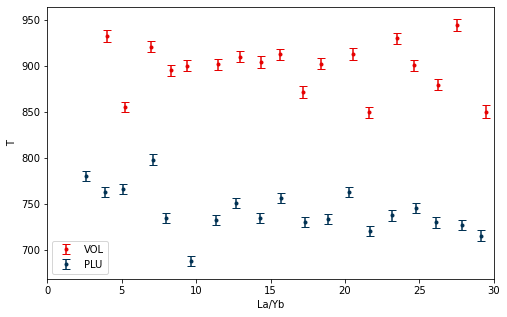

DEPTH
 # of tectonic setting: 2 

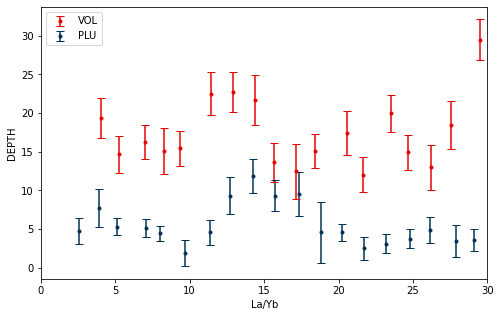

Sr/Y
 # of tectonic setting: 2 

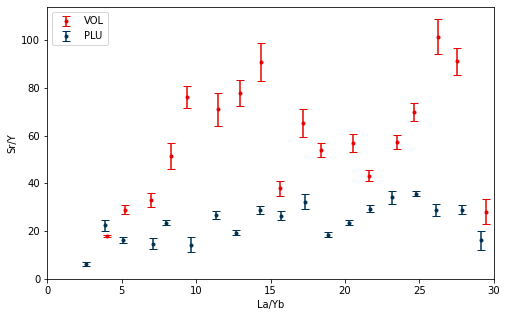

La/Yb
 # of tectonic setting: 2 

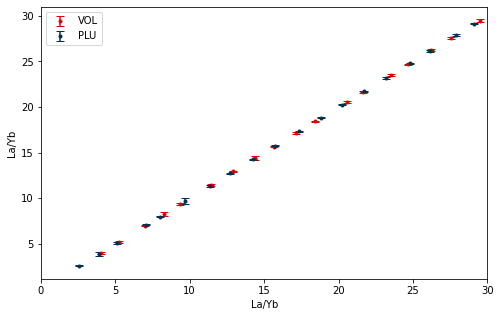

CPU times: user 406 ms, sys: 192 µs, total: 406 ms
Wall time: 394 ms


In [158]:
%%time

# 根据构造背景分类的barplot
for i in simitemsin[5:]:
    print(i)
    fig, ax1 = plt.subplots(figsize=(8, 5))

    for j in range(len(tect_set)):
        clr = clrs[j]
        ax1.errorbar(
            x=sim_mean[sim_mean[tec] == tect_set[j]][ele_ratio],
            y=sim_mean[sim_mean[tec] == tect_set[j]][i],
            yerr=sim_err[sim_err[tec] == tect_set[j]][i],
            fmt="o",
            capsize=4,
            label=tect_set[j],
            markersize=3,
            color=clr,
        )  # , color = clr
        #         ax1.plot(sim_mean[sim_mean[tec] == tect_set[j]]['DEPTH'], sim_mean[sim_mean[tec] == tect_set[j]][i], color = clr)
        # plt.xlim(0, 40)
        plt.xlim(ele_min, ele_max)
        if (i == "DEPTH") & (ele_ratio == "Sr/Y"):
            plt.ylim(ele_min, 30)

        print("\r # of tectonic setting: %d" % (j + 1), end=" ")
    plt.xlabel(ele_ratio)
    plt.ylabel(i)

    ax1.legend()
    #     file_name = 'figures/errbar/' + 'CM' + '_' + i[:-5] + '_' + 'depth_noCC' + '.tiff'
    #     plt.rcParams['savefig.dpi'] = 300
    #     plt.savefig(file_name)
    plt.show()